In [ ]:
!pip install patool pyunpack

In [2]:
!pip install patool

In [2]:
import pyunpack
from pyunpack import Archive
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os

from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [ ]:
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D 
from keras import optimizers

<h1><center>CSCI - 4146 - The Process of Data Science - Fall 2020</h1></center>
<h1><center>Assignment 2</h1></center>

<b>Katherine Lin</b>  
B00735778


<b>Lingyu Ye</b>  
B00724509 

# 1. Data understanding and feature engineering (0.1)



## 1.a Load dateset and perform features extraction

In [4]:
# load data files of Test set 2
import patoolib
patoolib.extract_archive("2nd_test.rar")

patool: Extracting 2nd_test.rar ...
patool: running /usr/bin/unrar x -- /content/2nd_test.rar
patool:     with cwd='./Unpack_j4du5okg'
patool: ... 2nd_test.rar extracted to `2nd_test'.


'2nd_test'

In [5]:
# define functions for features extractions: use sd=1

def RMS(arr):
    return np.sqrt(sum(arr**2)/len(arr))

def Variance(arr):
    return sum((arr - Mean(arr))**2) / (len(arr)-1)

def Skewness(arr):
    return sum((arr - Mean(arr))**3) / (len(arr)-1)

def Kurtosis(arr):
    return sum((arr - Mean(arr))**4) / (len(arr)-1)

def Shape_factor(arr):
    numerator = np.sqrt(sum(arr**2)/len(arr))
    denominator = sum(np.absolute(arr)) / len(arr)
    return numerator/denominator

def Crest_factor(arr):
    return max(np.abs(arr)) / np.sqrt(sum(arr**2)/len(arr))

#def PDF(arr):
#  return (1.0 / (np.sqrt(2*math.pi))) * np.exp(-0.5*((arr - Mean(arr))) ** 2)

#def Entropy(arr):
#  return sum(PDF(arr)*np.log2(PDF(arr)))*-1

def Mean(arr):
    return sum(arr)/len(arr)

# RUL is 'normalized' as a ratio for better model prediction
def RUL(file_counter, arr):
    return ((len(arr)-file_counter)*10)/len(arr)

In [6]:
# extract fearures from each channel of each of the data files of Test set 2

def feature_extraction(channel,output_file,test_set):

    file_counter = 0
    mean = np.array([]) # Vibrational Signal (Mean)
    rms = np.array([]) # RMS
    var = np.array([]) # Variance
    sk = np.array([]) # Skewness
    ku = np.array([]) # Kurtosis
    sf = np.array([]) # Shape factor
    cf = np.array([]) # Crest factor
    rul = np.array([]) #Remining Useful Life (target)

    for filename in os.listdir(test_set): # get a list of files in the directory
        with open(os.path.join(test_set, filename), 'r') as f: # open in readonly mode
            tsv_file = pd.read_csv(f,delimiter='\t',encoding='utf-8',header=None)
            ch = tsv_file.iloc[:, channel] # col = Channel

            mean = np.append(mean,Mean(ch))
            rms = np.append(rms,RMS(ch))
            var = np.append(var,Variance(ch))
            sk = np.append(sk,Skewness(ch))
            ku = np.append(ku,Kurtosis(ch))
            sf = np.append(sf,Shape_factor(ch))
            cf = np.append(cf,Crest_factor(ch))
            rul = np.append(rul, RUL(file_counter,ch))

            file_counter += 1


  # create a dataframe from a dictionary
    ch_features = {'RMS':rms, 'Variance':var, 'Skewness':sk, 'Kurtosis':ku, 'Shape factor':sf, 'Crest factor':cf, 'Mean':mean, 'RUL':rul} 

    ch_features_df = pd.DataFrame(ch_features,)

  # save to a csv file 
    ch_features_df.to_csv(output_file)

To save running time, we write extracted features of each channel into separate csv file. So that everytime we need to restart the whole program, we just need to load data from csv files into separate dataframe instead of re-running feature extraction step. 

In [7]:
# write features data for each channel into seperate csv file
feature_extraction(channel=0,output_file='ch1_features.csv',test_set='2nd_test') # 1st channel
feature_extraction(channel=1,output_file='ch2_features.csv',test_set='2nd_test') # 2nd channel
feature_extraction(channel=2,output_file='ch3_features.csv',test_set='2nd_test') # 3rd channel
feature_extraction(channel=3,output_file='ch4_features.csv',test_set='2nd_test') # 4th channel

In [3]:
# reload features data for each channel into seperate dataframe
ch1_features_df = pd.read_csv('ch1_features.csv')
ch2_features_df = pd.read_csv('ch2_features.csv')
ch3_features_df = pd.read_csv('ch3_features.csv')
ch4_features_df = pd.read_csv('ch4_features.csv')

ch1_features_df = ch1_features_df.drop(ch1_features_df.columns[0], axis=1)
ch2_features_df = ch2_features_df.drop(ch2_features_df.columns[0], axis=1)
ch3_features_df = ch3_features_df.drop(ch3_features_df.columns[0], axis=1)
ch4_features_df = ch4_features_df.drop(ch4_features_df.columns[0], axis=1)

## 1.b Build the data quality report

### Continous features report

In [9]:
def buildContinuousFeaturesReport(features, data_df):
	conHead = ['Count', 'Miss %', 'Card.', 'Min', '1st Qrt.',
            'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']

	conOut_df = pd.DataFrame(index=features, columns=conHead)
	columns_df = data_df[features]

	#COUNT
	conOut_df[conHead[0]] = len(columns_df)

	#MISS % 
	conOut_df[conHead[1]] = columns_df.isna().sum() / len(columns_df) * 100

	#CARDINALITY
	conOut_df[conHead[2]] = columns_df.nunique()

	#MINIMUM
	conOut_df[conHead[3]] = columns_df.min()

	#1ST QUARTILE
	conOut_df[conHead[4]] = columns_df.quantile(0.25)

	#MEAN
	conOut_df[conHead[5]] = columns_df.mean()

	#MEDIAN
	conOut_df[conHead[6]] = columns_df.median()

	#3rd QUARTILE
	conOut_df[conHead[7]] = columns_df.quantile(0.75)

	#MAX
	conOut_df[conHead[8]] = columns_df.max()

	#STANDARD DEVIATION
	conOut_df[conHead[9]] = columns_df.std()

	return conOut_df

In [10]:
with pd.option_context('display.float_format', '{:.2f}'.format):
  print("Data quality report for Channel 1")
  display(buildContinuousFeaturesReport(ch1_features_df.select_dtypes('number').columns.to_list(), ch1_features_df))
  print("\nData quality report for Channel 2")
  display(buildContinuousFeaturesReport(ch2_features_df.select_dtypes('number').columns.to_list(), ch2_features_df))
  print("\nData quality report for Channel 3")
  display(buildContinuousFeaturesReport(ch3_features_df.select_dtypes('number').columns.to_list(), ch3_features_df))
  print("\nData quality report for Channel 4")
  display(buildContinuousFeaturesReport(ch4_features_df.select_dtypes('number').columns.to_list(), ch4_features_df))

Data quality report for Channel 1


Count  Miss %  Card.   Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984  0.00  ...    0.08     0.11  0.73       0.06
Variance        984    0.00    984  0.00  ...    0.01     0.01  0.53       0.03
Skewness        984    0.00    984 -0.23  ...   -0.00     0.00  0.00       0.01
Kurtosis        984    0.00    984  0.00  ...    0.00     0.00  4.30       0.18
Shape factor    984    0.00    984  1.13  ...    1.27     1.30  1.61       0.05
Crest factor    984    0.00    984  2.38  ...    5.10     5.44  9.33       0.58
Mean            984    0.00    984 -0.01  ...   -0.00    -0.00  0.00       0.00
RUL             984    0.00    984  9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]


Data quality report for Channel 2


Count  Miss %  Card.   Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984  0.00  ...    0.09     0.10  0.22       0.01
Variance        984    0.00    984  0.00  ...    0.01     0.01  0.05       0.00
Skewness        984    0.00    984 -0.00  ...    0.00     0.00  0.01       0.00
Kurtosis        984    0.00    984  0.00  ...    0.00     0.00  0.01       0.00
Shape factor    984    0.00    984  1.08  ...    1.26     1.26  1.61       0.01
Crest factor    984    0.00    984  1.61  ...    4.79     5.16  7.93       0.59
Mean            984    0.00    983 -0.03  ...   -0.00    -0.00  0.00       0.00
RUL             984    0.00    984  9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]


Data quality report for Channel 3


Count  Miss %  Card.   Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984  0.00  ...    0.10     0.10  0.19       0.01
Variance        984    0.00    984  0.00  ...    0.01     0.01  0.04       0.00
Skewness        984    0.00    984 -0.00  ...    0.00     0.00  0.00       0.00
Kurtosis        984    0.00    984  0.00  ...    0.00     0.00  0.00       0.00
Shape factor    984    0.00    984  1.08  ...    1.29     1.30  1.67       0.02
Crest factor    984    0.00    984  1.77  ...    7.40     8.25 12.75       1.28
Mean            984    0.00    982 -0.01  ...   -0.00    -0.00  0.00       0.00
RUL             984    0.00    984  9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]


Data quality report for Channel 4


Count  Miss %  Card.   Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984  0.00  ...    0.06     0.06  0.15       0.01
Variance        984    0.00    984  0.00  ...    0.00     0.00  0.02       0.00
Skewness        984    0.00    984 -0.00  ...   -0.00     0.00  0.00       0.00
Kurtosis        984    0.00    984  0.00  ...    0.00     0.00  0.00       0.00
Shape factor    984    0.00    984  1.21  ...    1.26     1.26  1.32       0.01
Crest factor    984    0.00    984  2.32  ...    4.54     4.82  9.24       0.53
Mean            984    0.00    983 -0.01  ...   -0.00    -0.00  0.00       0.00
RUL             984    0.00    984  9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]

In [11]:
ch1_features_df.head()

RMS  Variance  Skewness  ...  Crest factor      Mean        RUL
0  0.077344  0.005979 -0.000019  ...      5.559565 -0.001976  10.000000
1  0.171015  0.029247 -0.001673  ...      5.426424 -0.000905   9.999512
2  0.098448  0.009690 -0.000014  ...      4.642043 -0.001513   9.999023
3  0.075995  0.005769 -0.000012  ...      4.368721 -0.002462   9.998535
4  0.153064  0.023424 -0.000403  ...      4.625504 -0.002480   9.998047

[5 rows x 8 columns]

Comment: As the values of some features are too small, the statistical values of these features look pretty close to 0.00/-0.00. We will perform normalization of the data to better represent the characteristic of features.

### Histograms

Histograms of features of Channel 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b3a7752b0>,
      dtype=object)

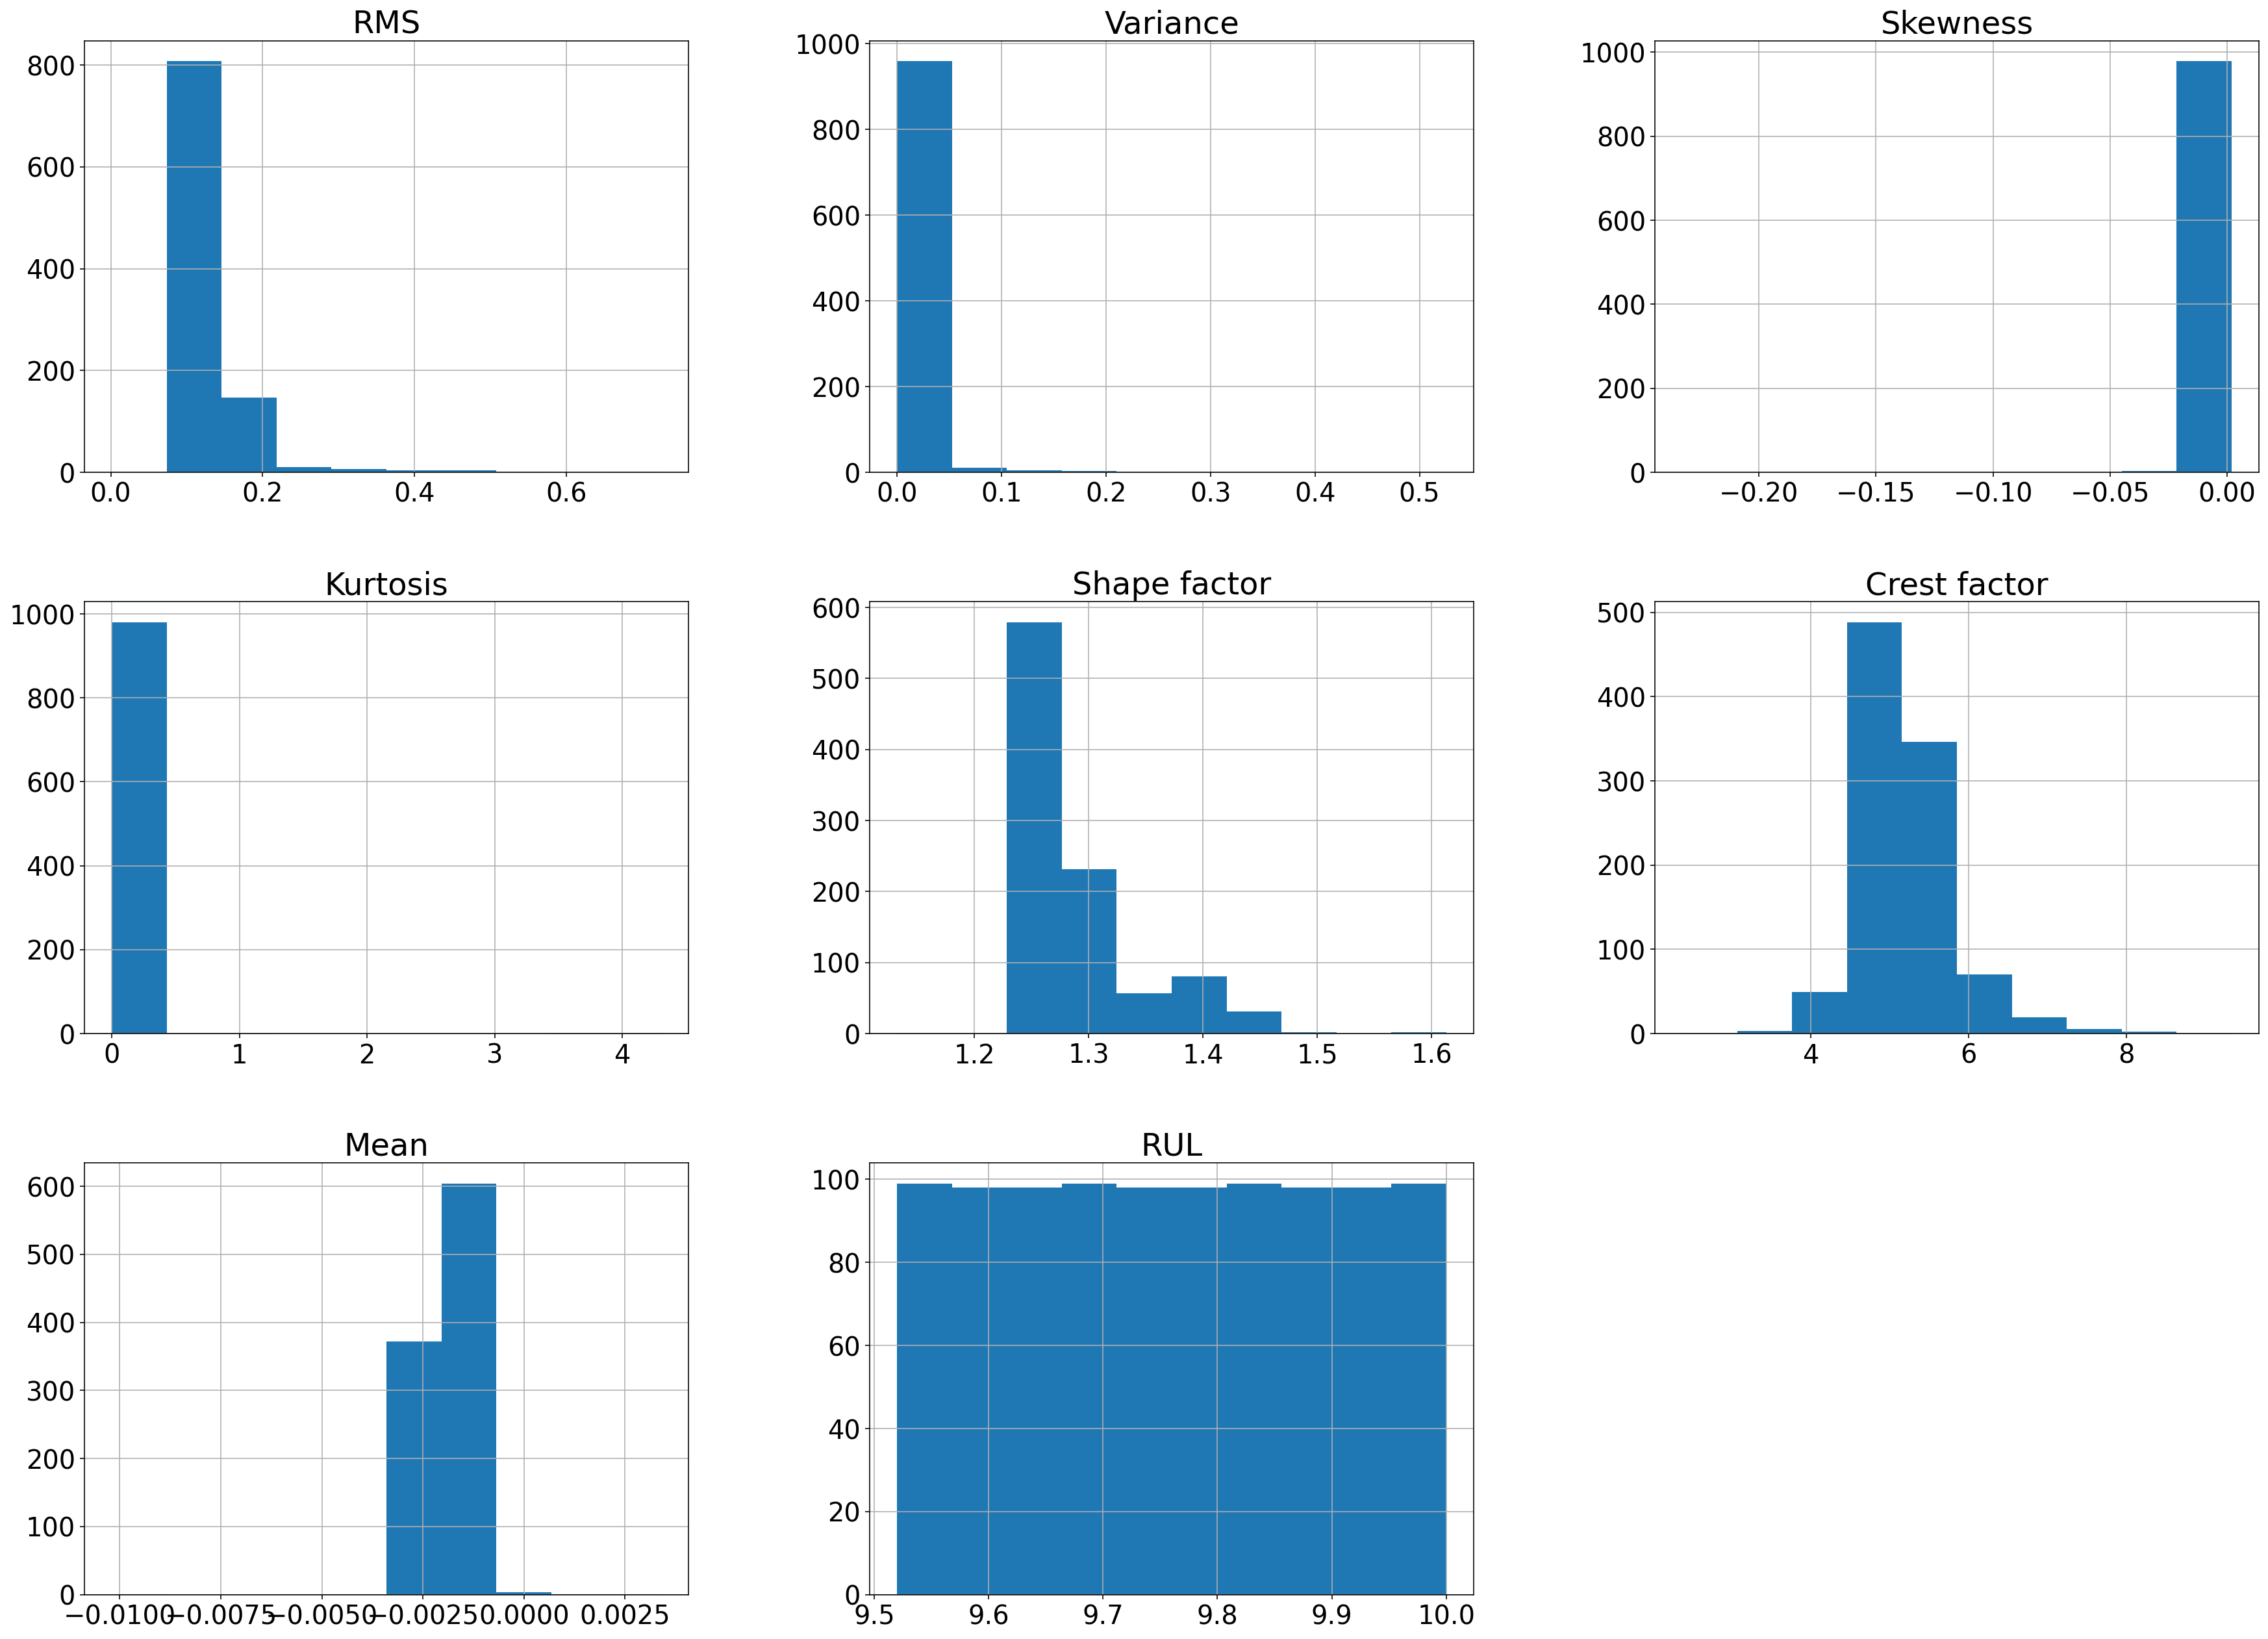

In [12]:
# Histograms
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [30, 22]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch1_features_df.select_dtypes('number').hist()

Histograms of features of Channel 2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b3a44ada0>,
      dtype=object)

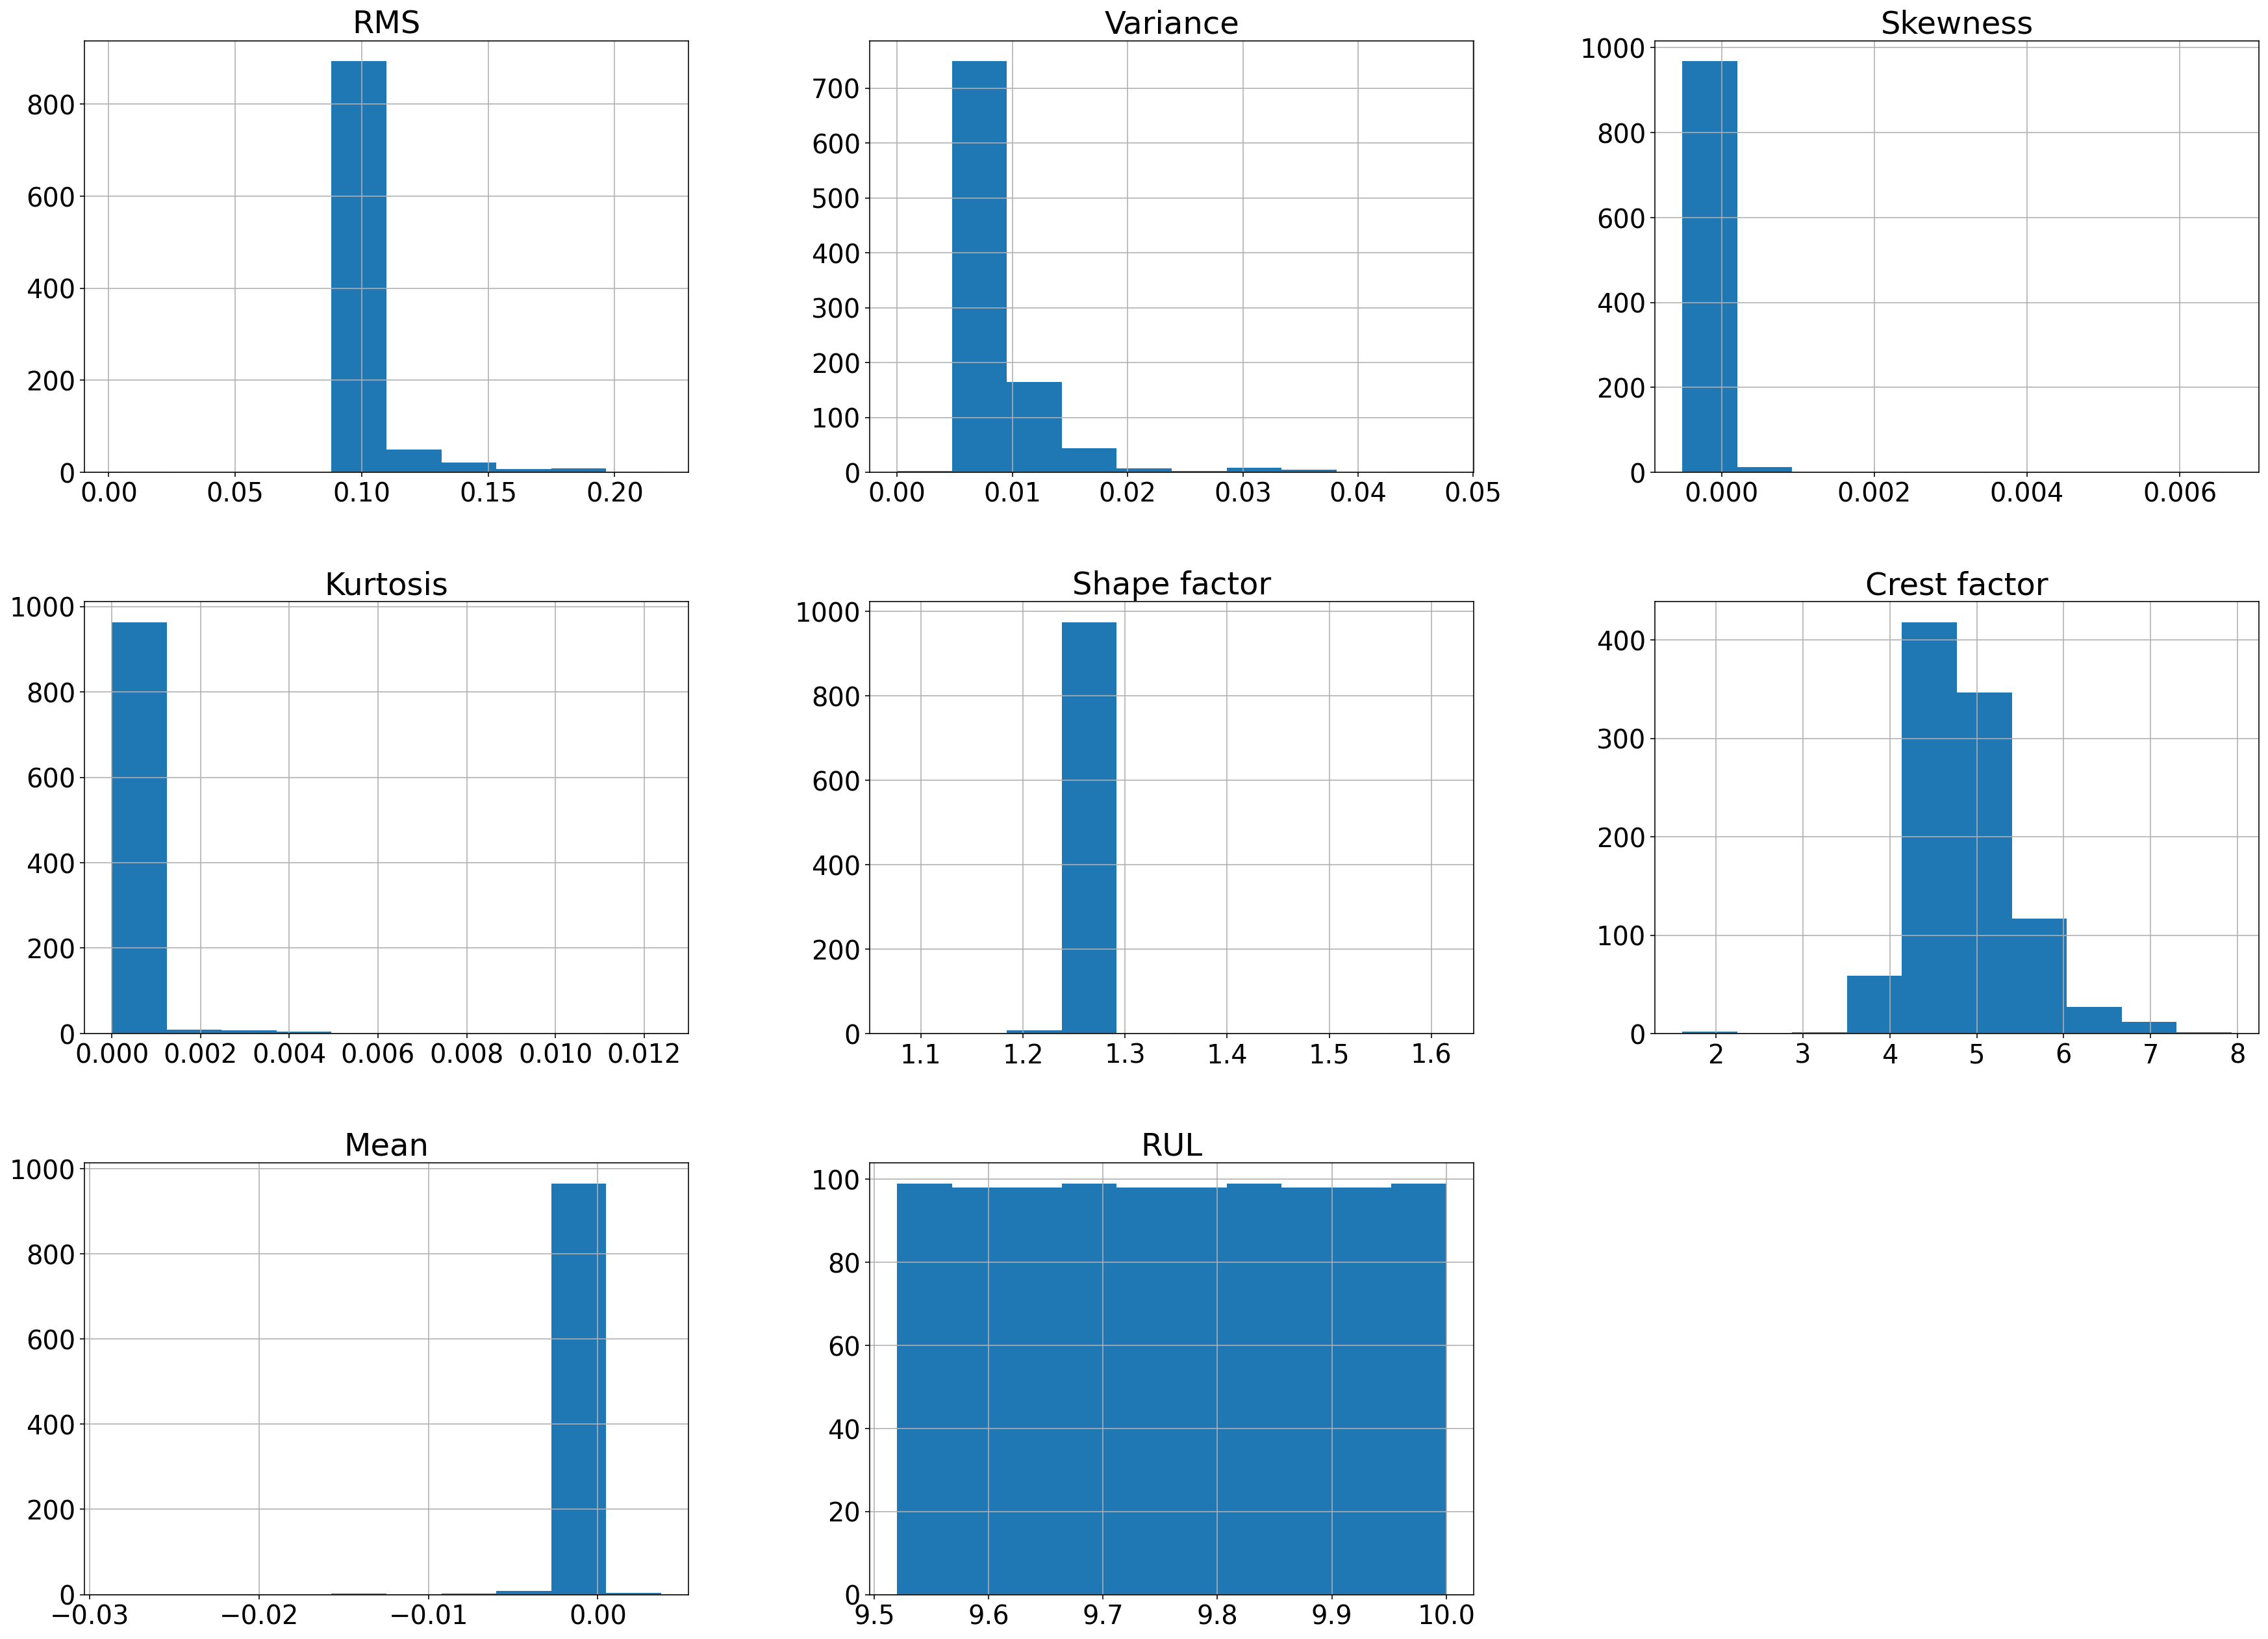

In [13]:
# Histograms
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [30, 22]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch2_features_df.select_dtypes('number').hist()

Histograms of features of Channel 3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b3832fc50>,
      dtype=object)

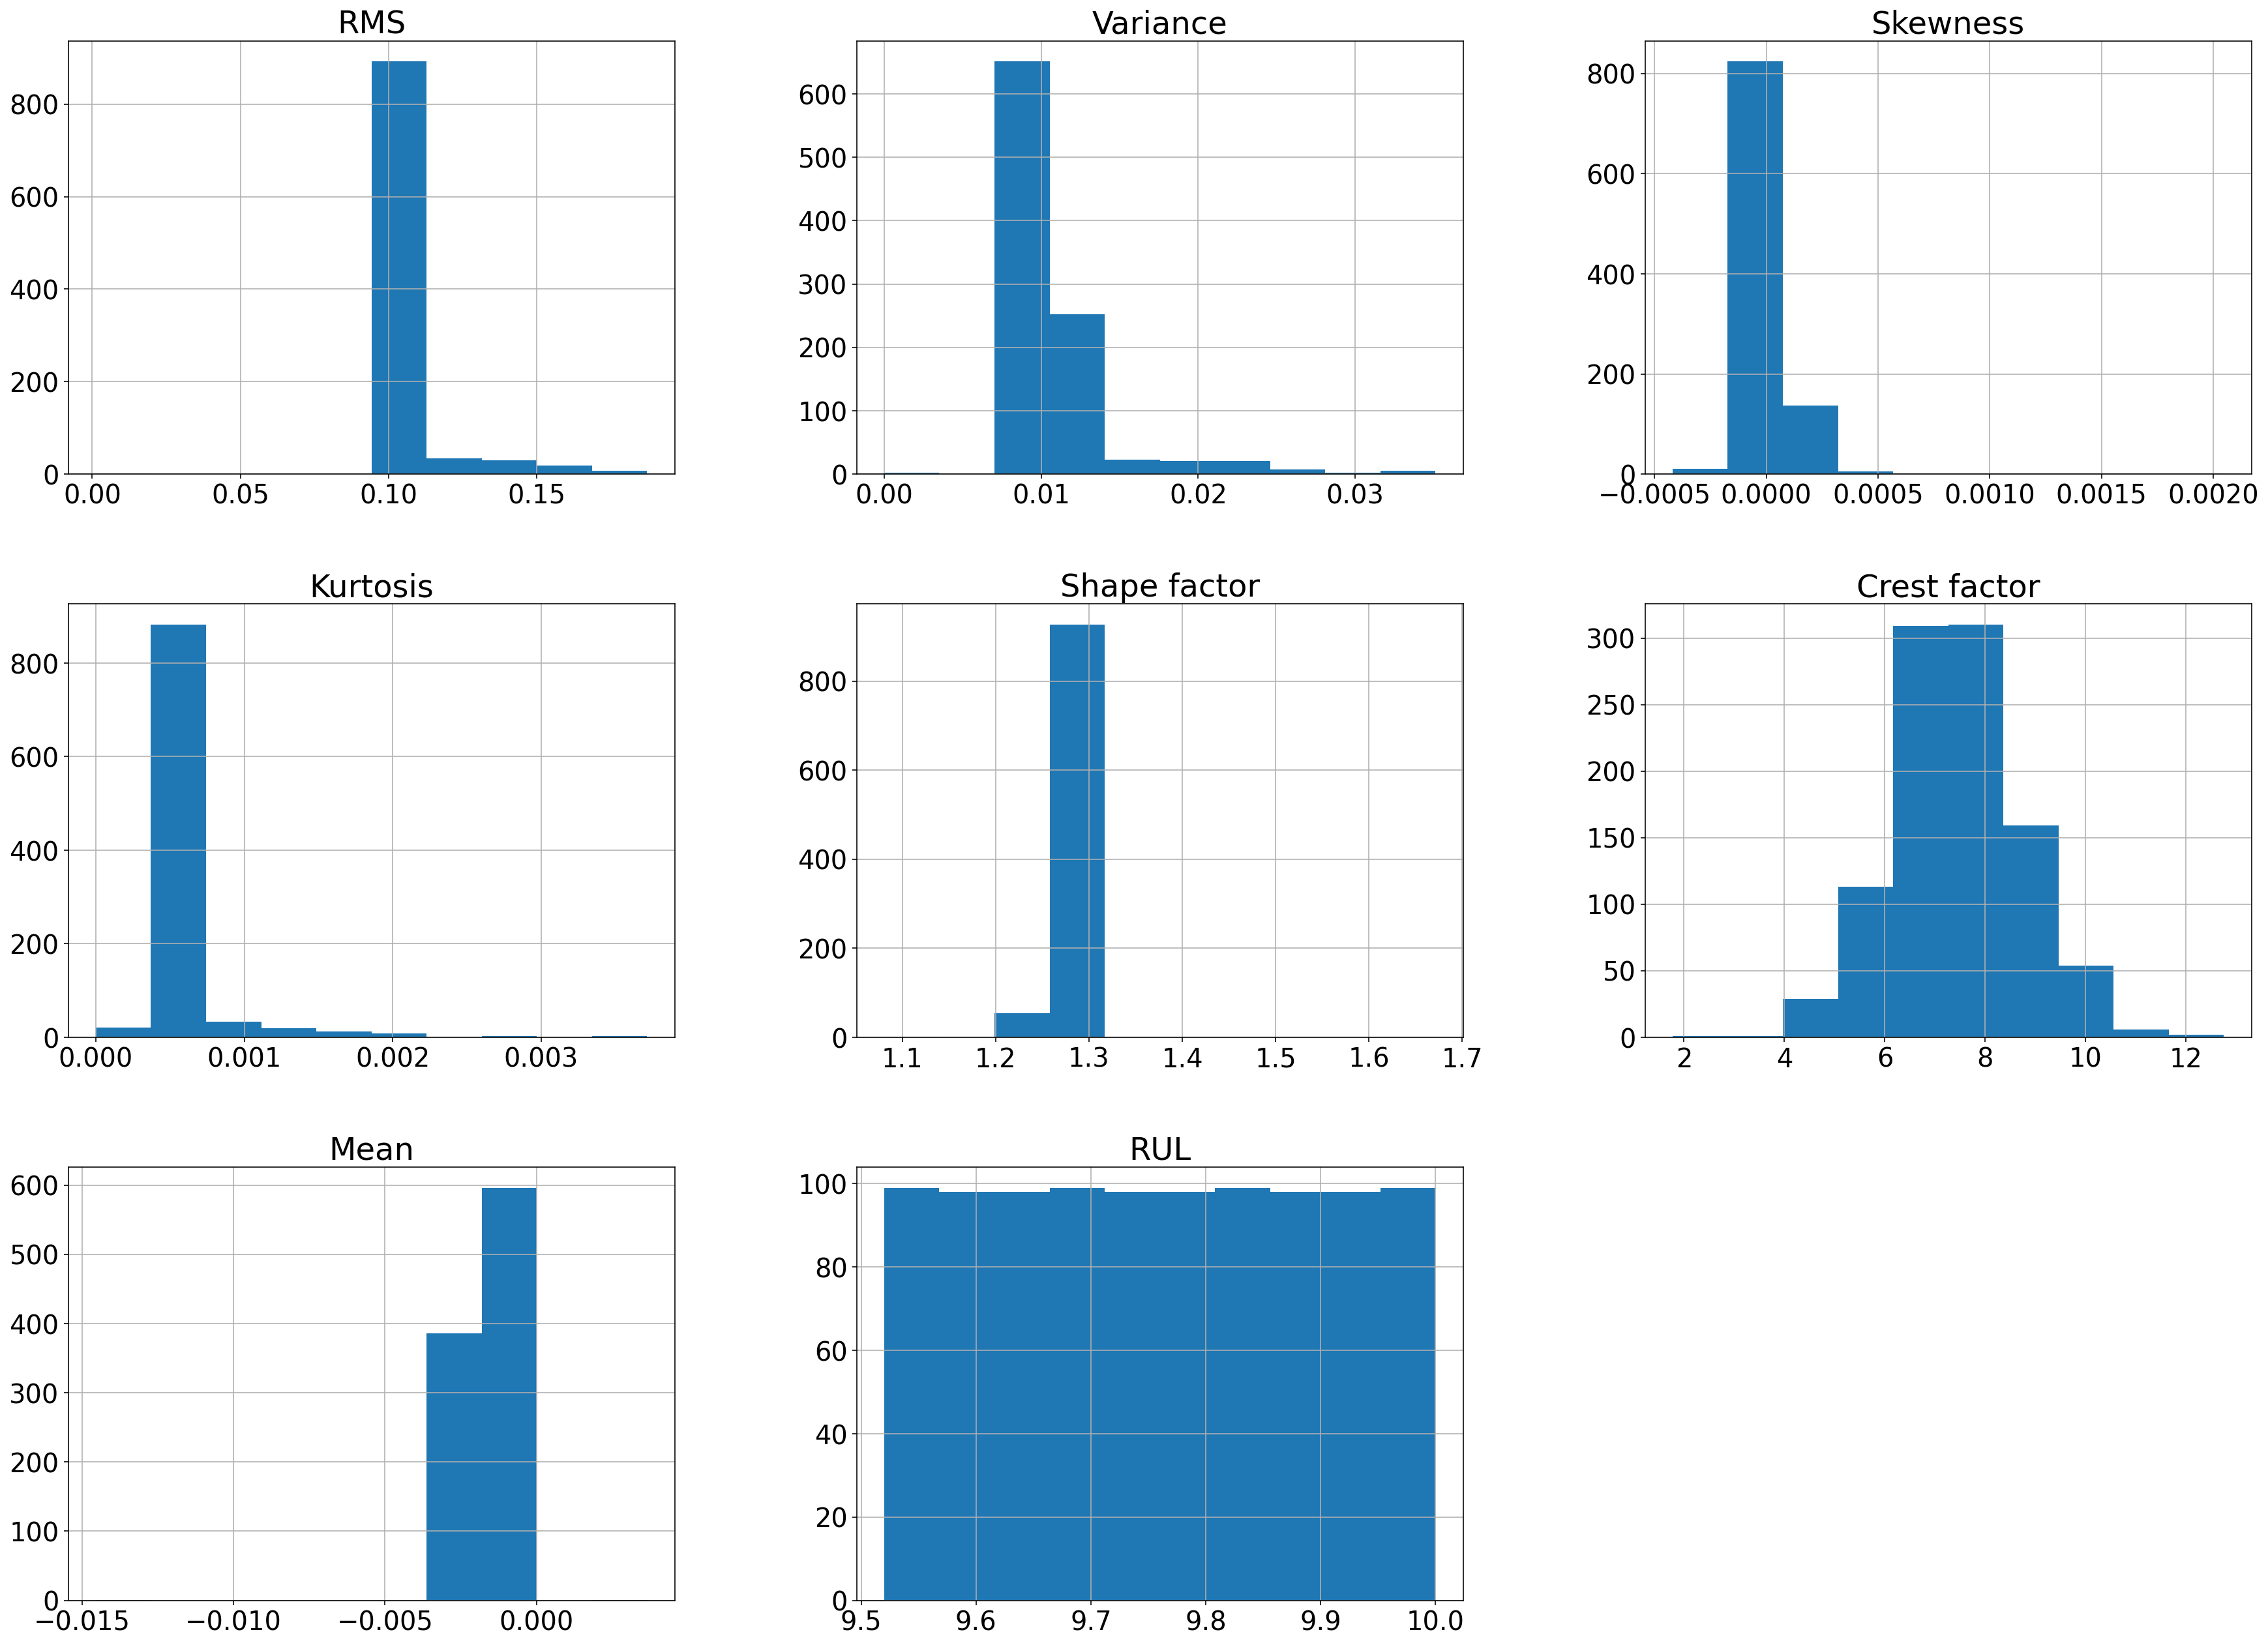

In [14]:
# Histograms
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [30, 22]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch3_features_df.select_dtypes('number').hist()

Histograms of features of Channel 4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b37f50048>,
      dtype=object)

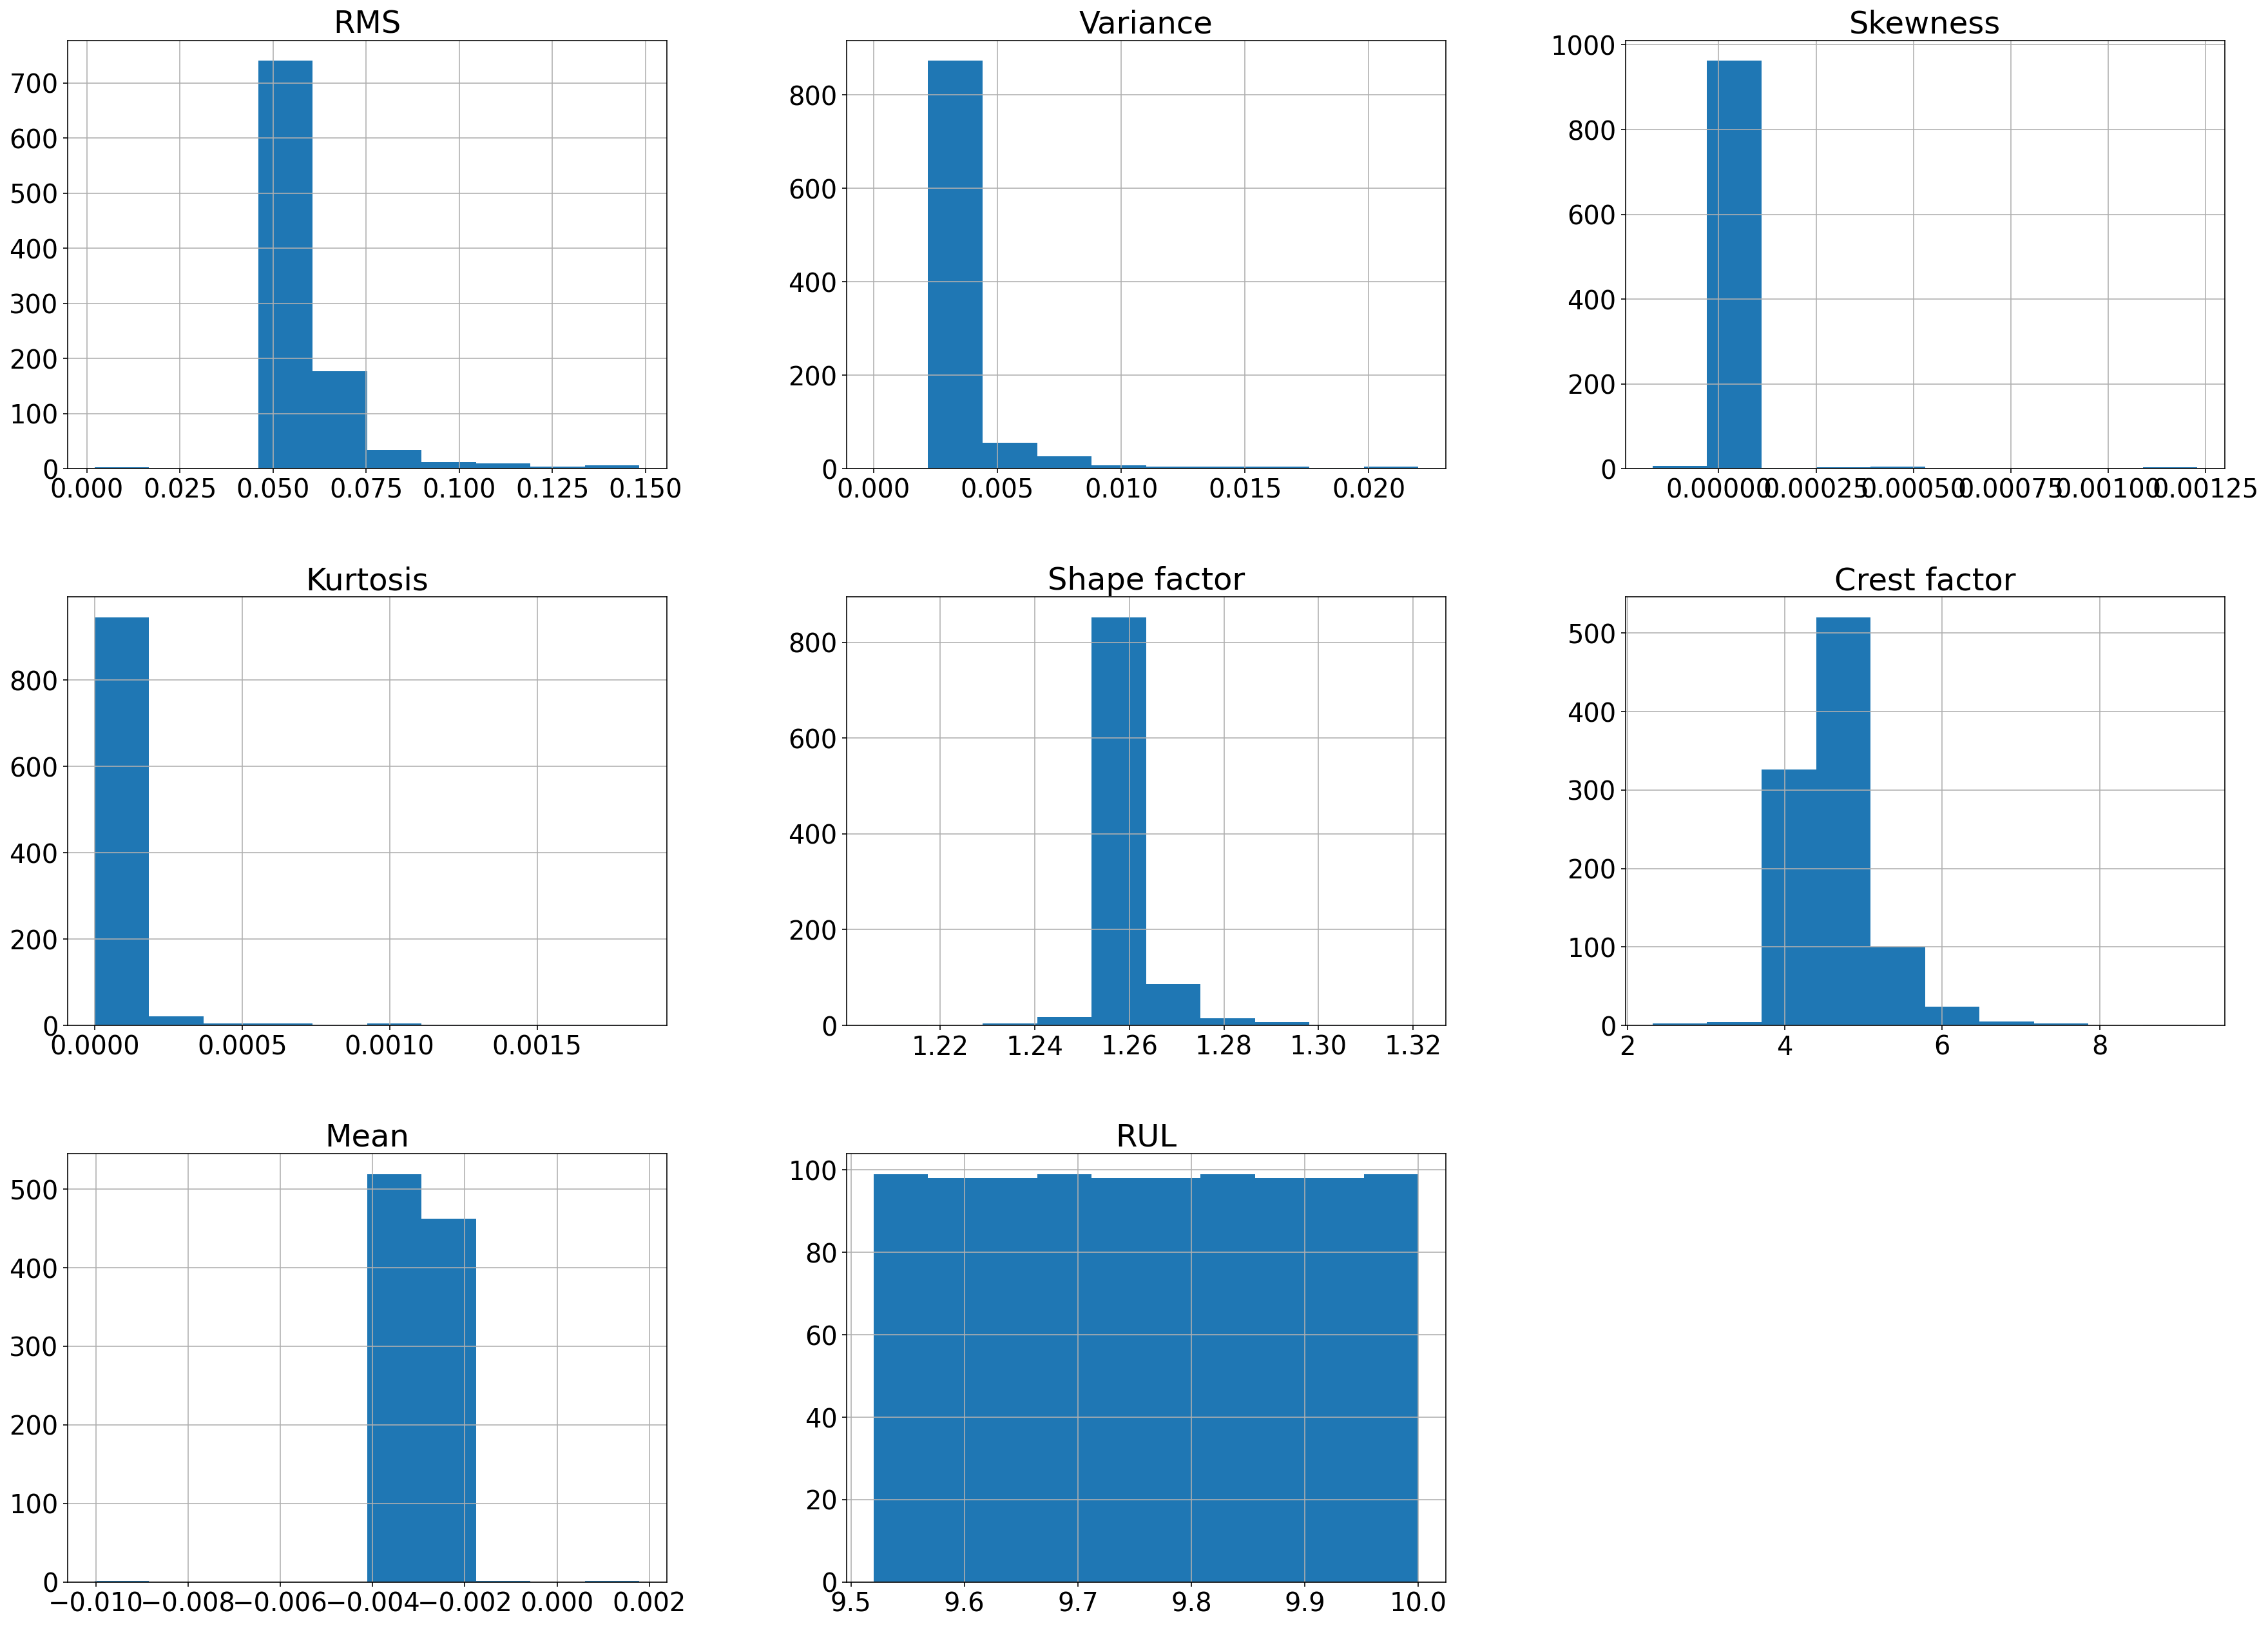

In [15]:
# Histograms
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [30, 22]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch4_features_df.select_dtypes('number').hist()

### Boxplot

Boxplot of features of Channel 1

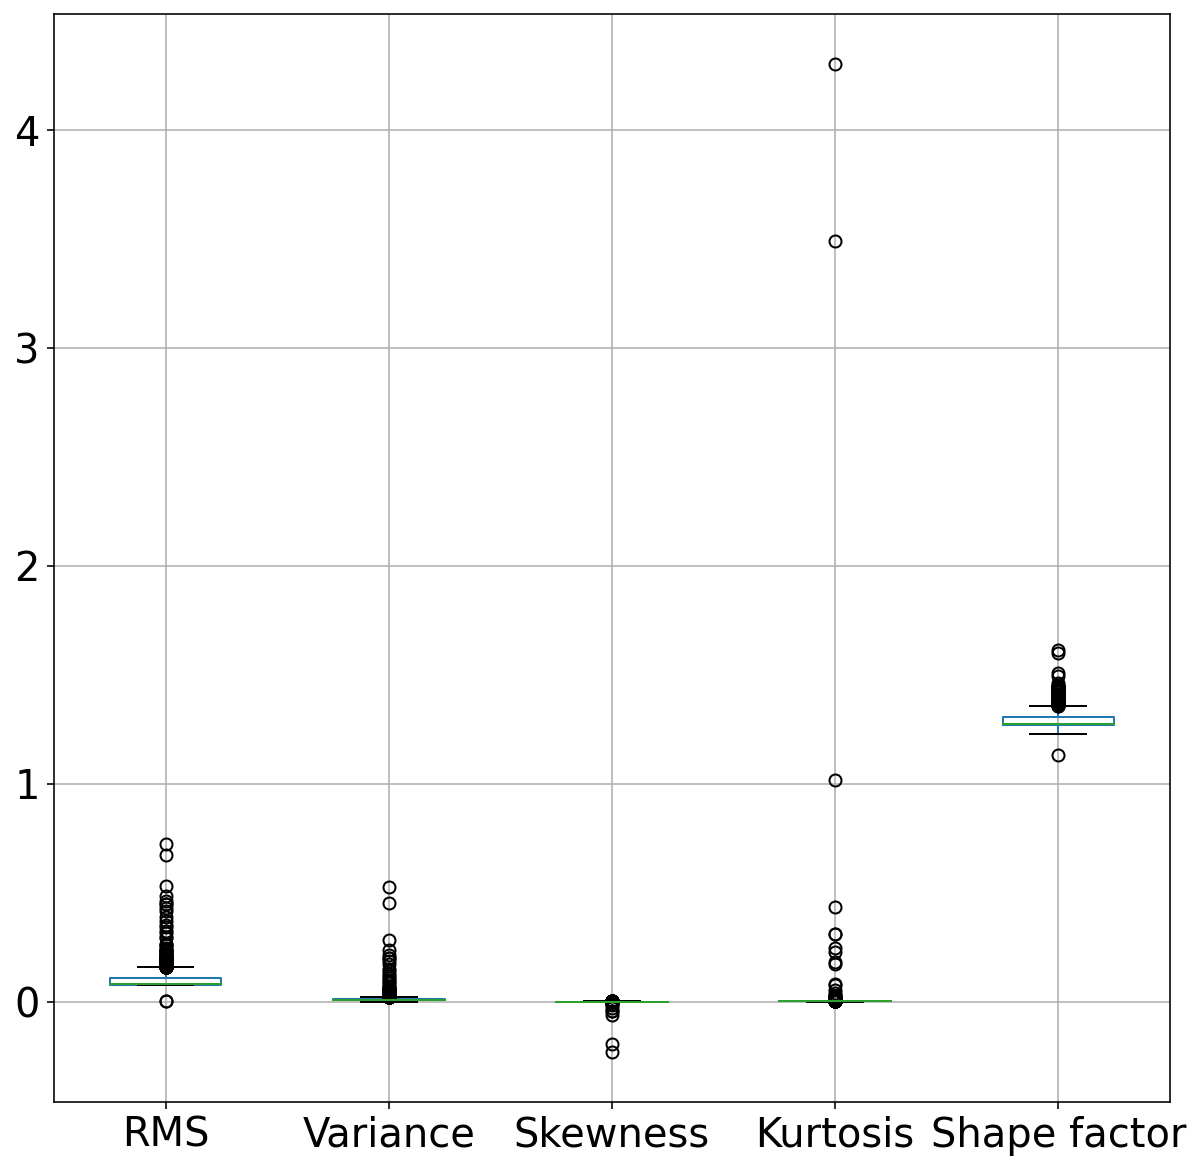

In [16]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch1_features_df.boxplot(column=['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor']);

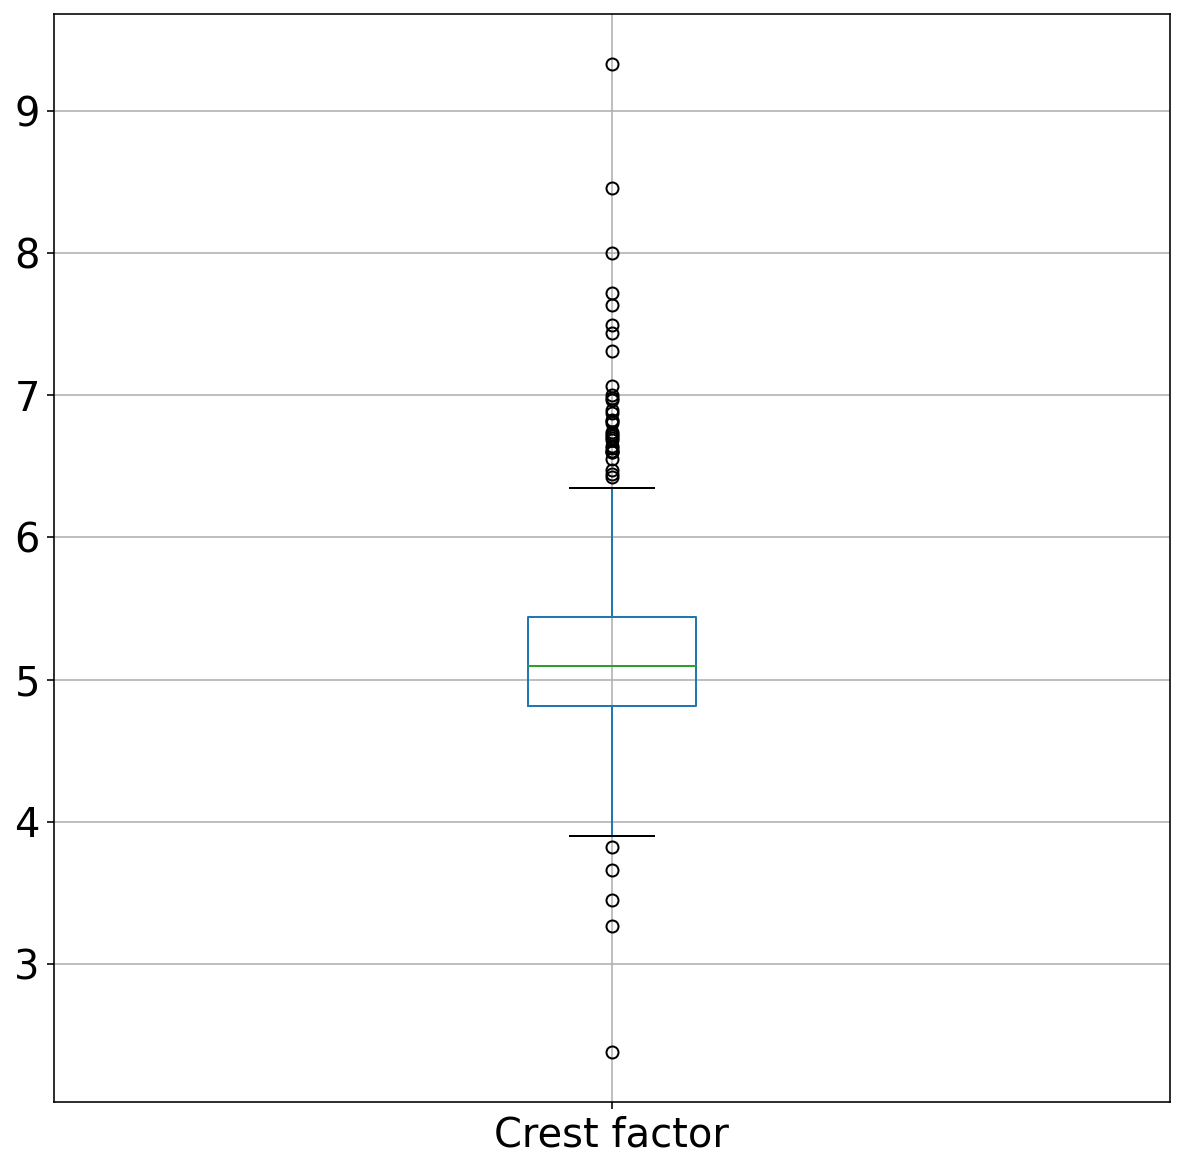

In [17]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch1_features_df.boxplot(column=['Crest factor']);

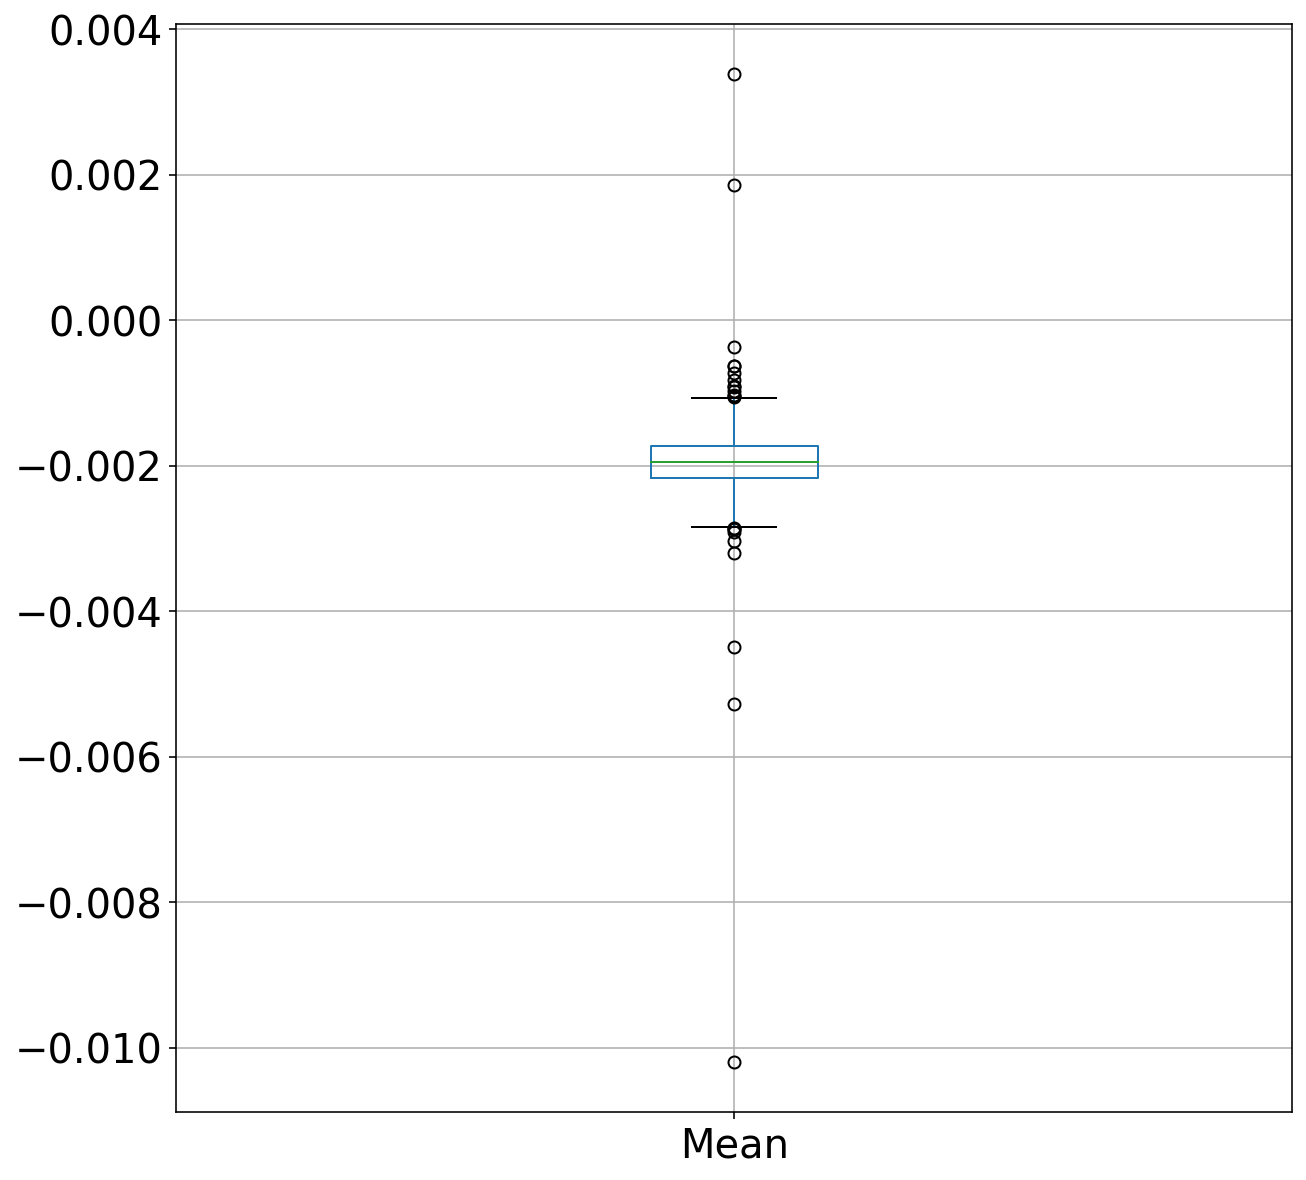

In [18]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch1_features_df.boxplot(column=['Mean']);

Boxplot of features of Channel 2

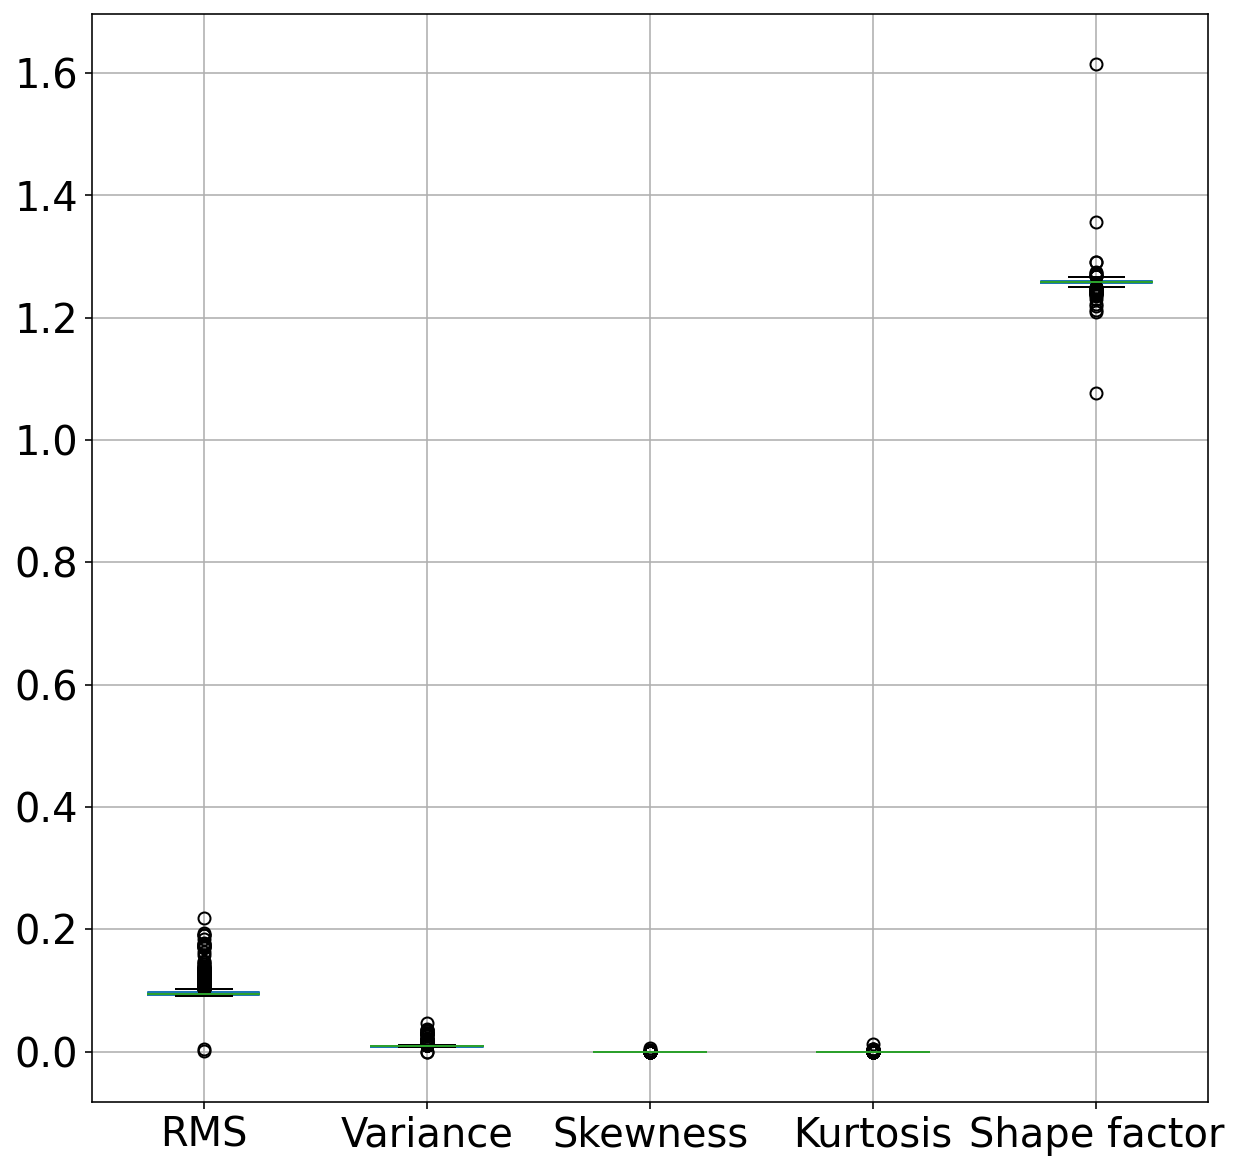

In [19]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch2_features_df.boxplot(column=['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor']);

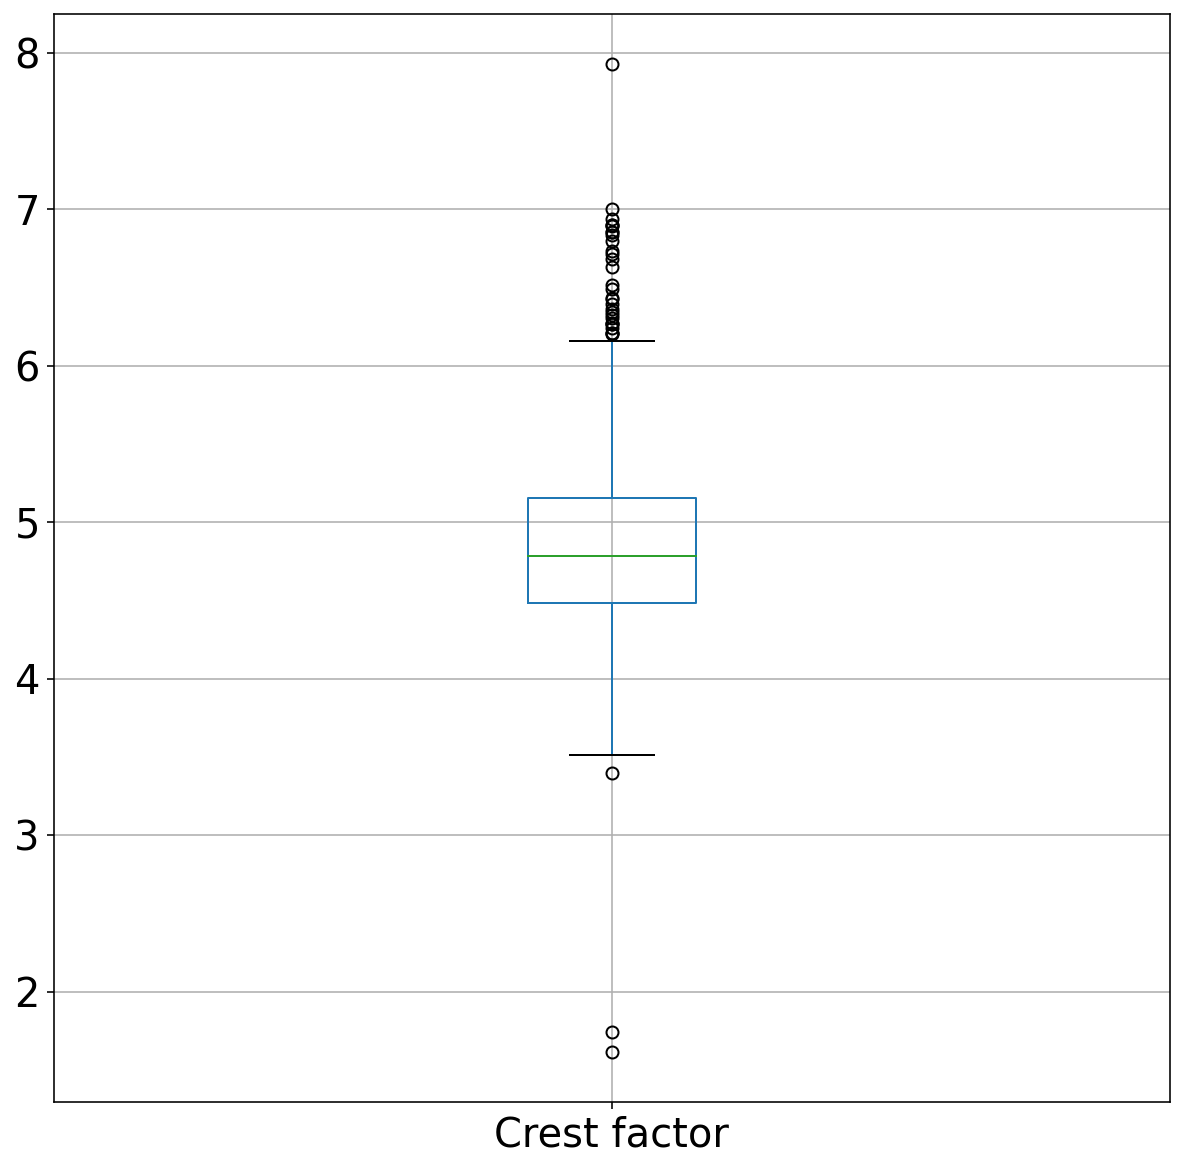

In [20]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch2_features_df.boxplot(column=['Crest factor']);

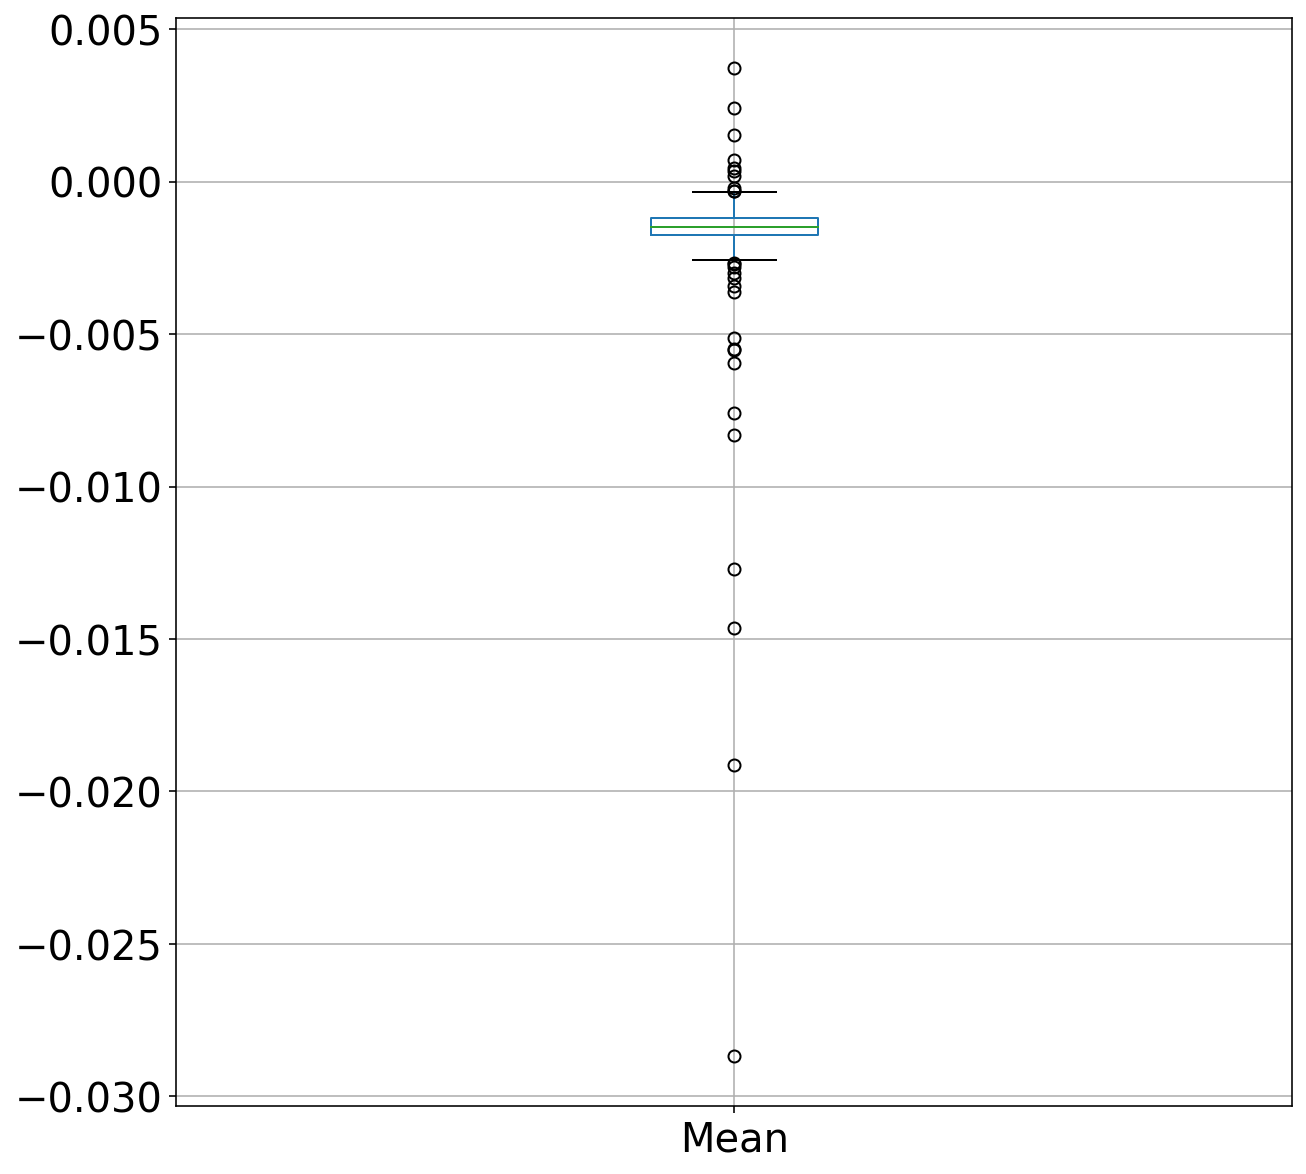

In [21]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch2_features_df.boxplot(column=['Mean']);

Boxplot of features of Channel 3

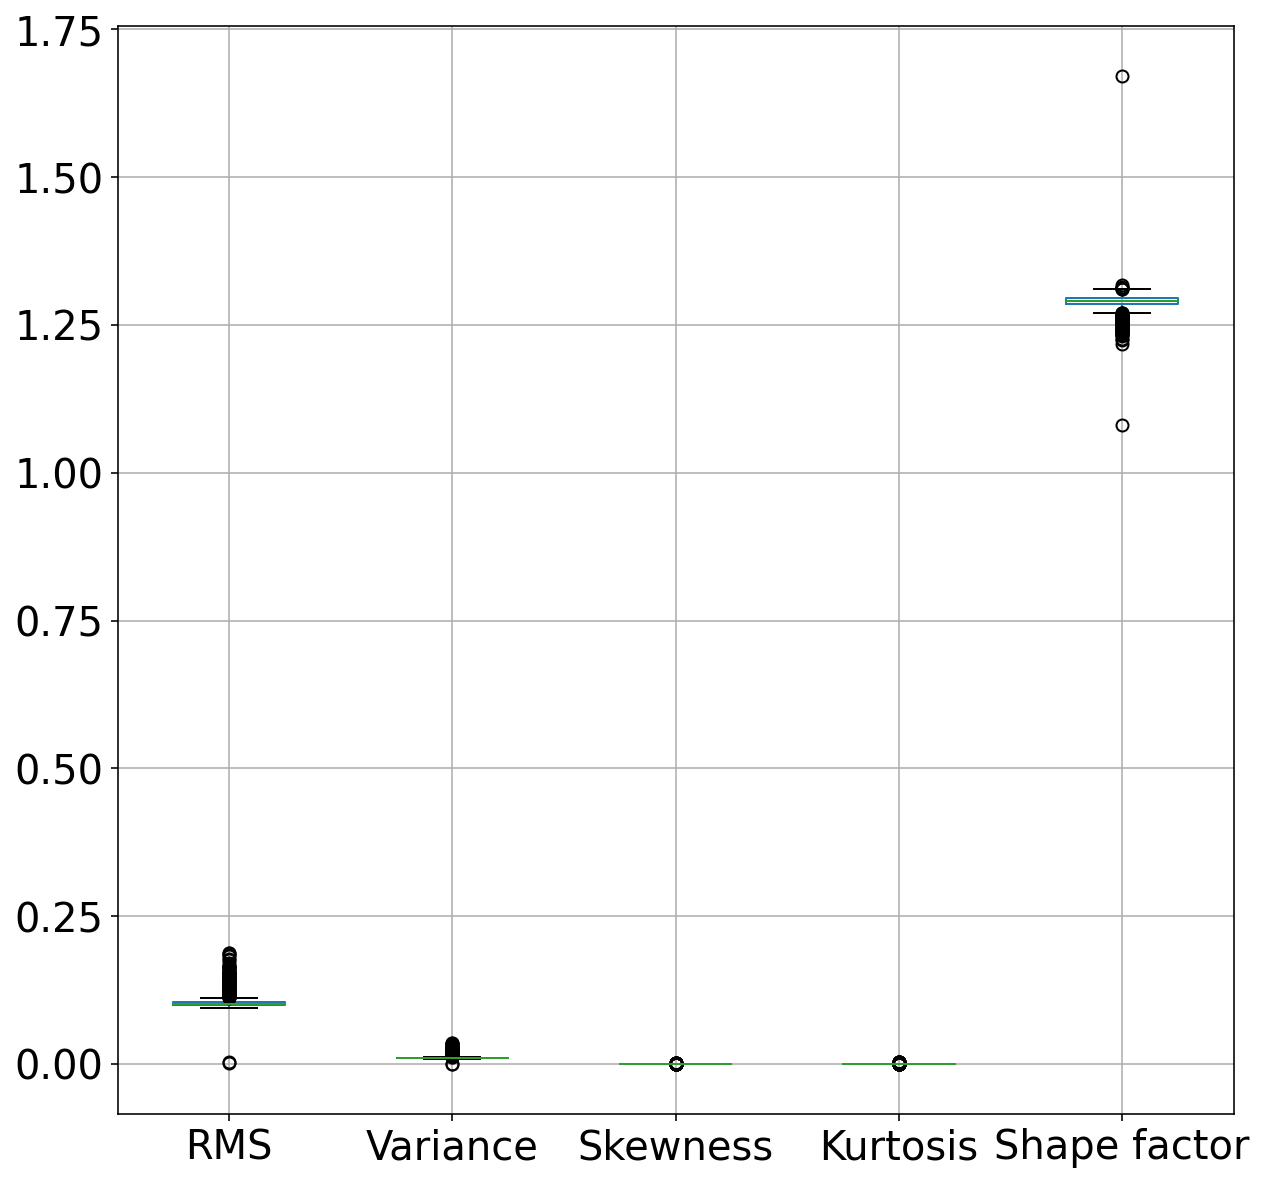

In [22]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch3_features_df.boxplot(column=['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor']);

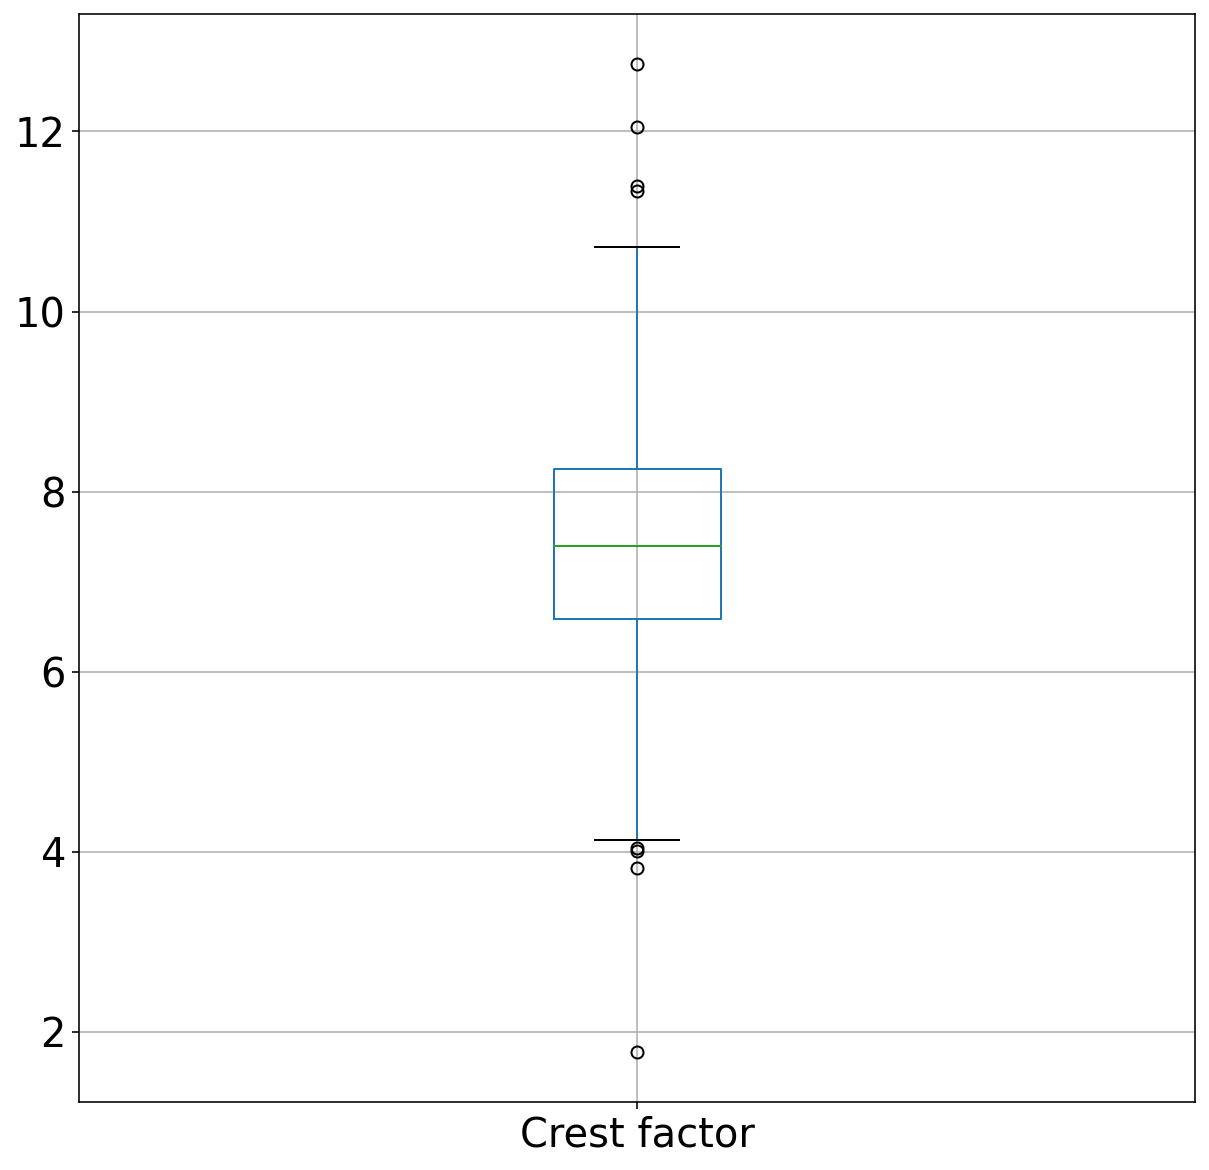

In [23]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch3_features_df.boxplot(column=['Crest factor']);

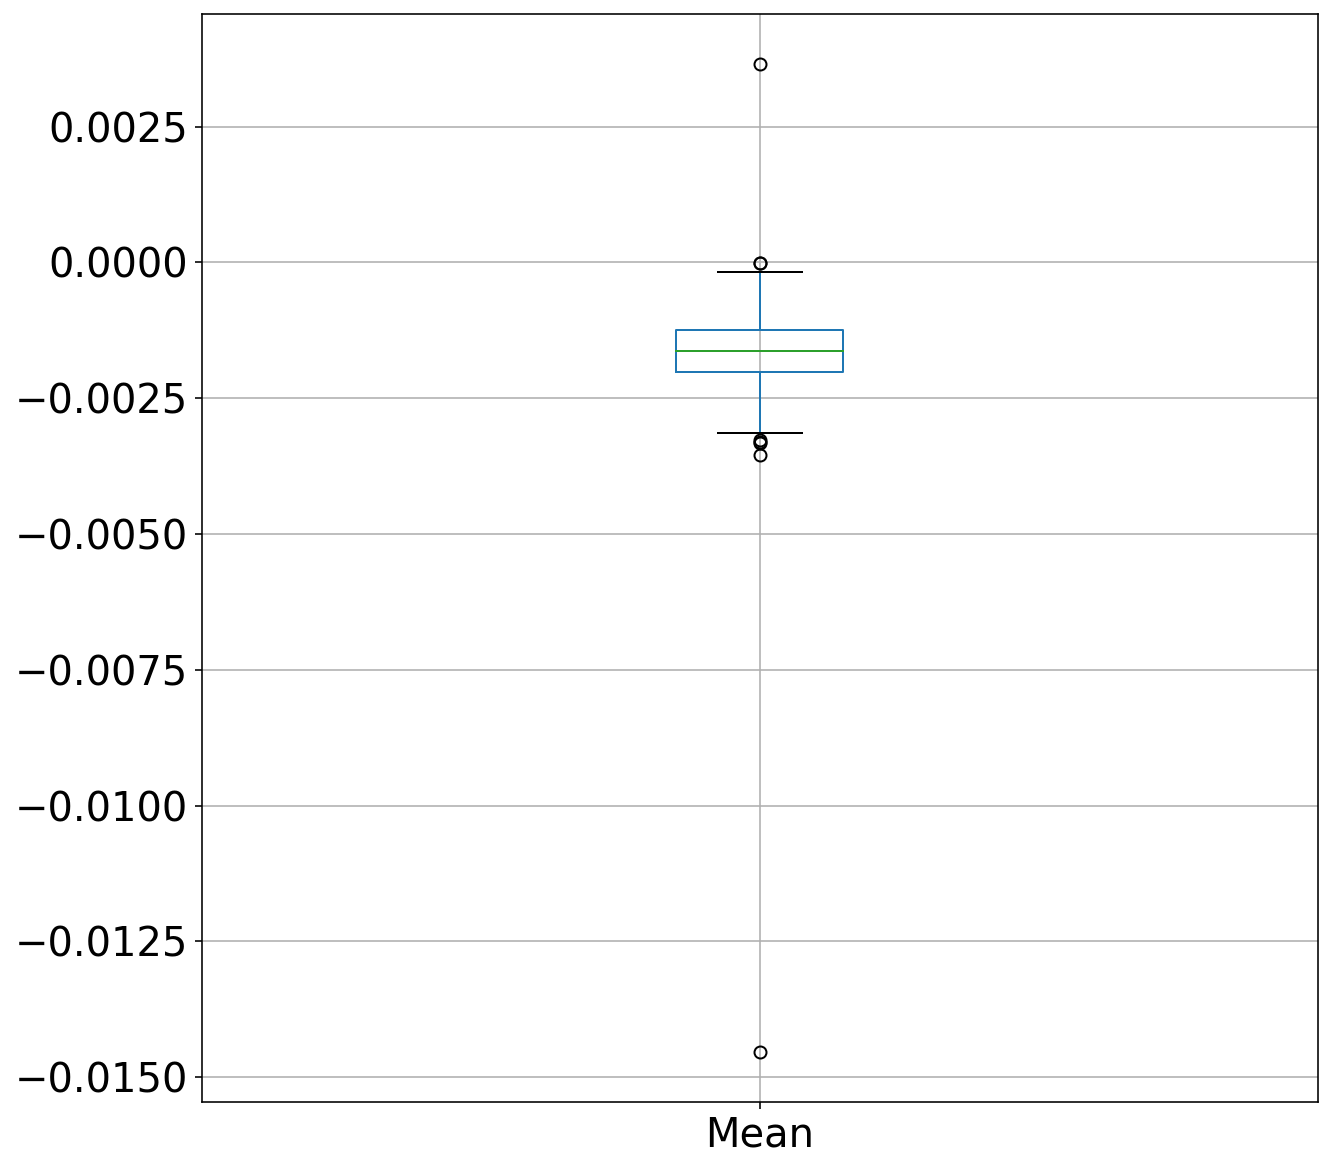

In [24]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch3_features_df.boxplot(column=['Mean']);

Boxplot of features of Channel 4

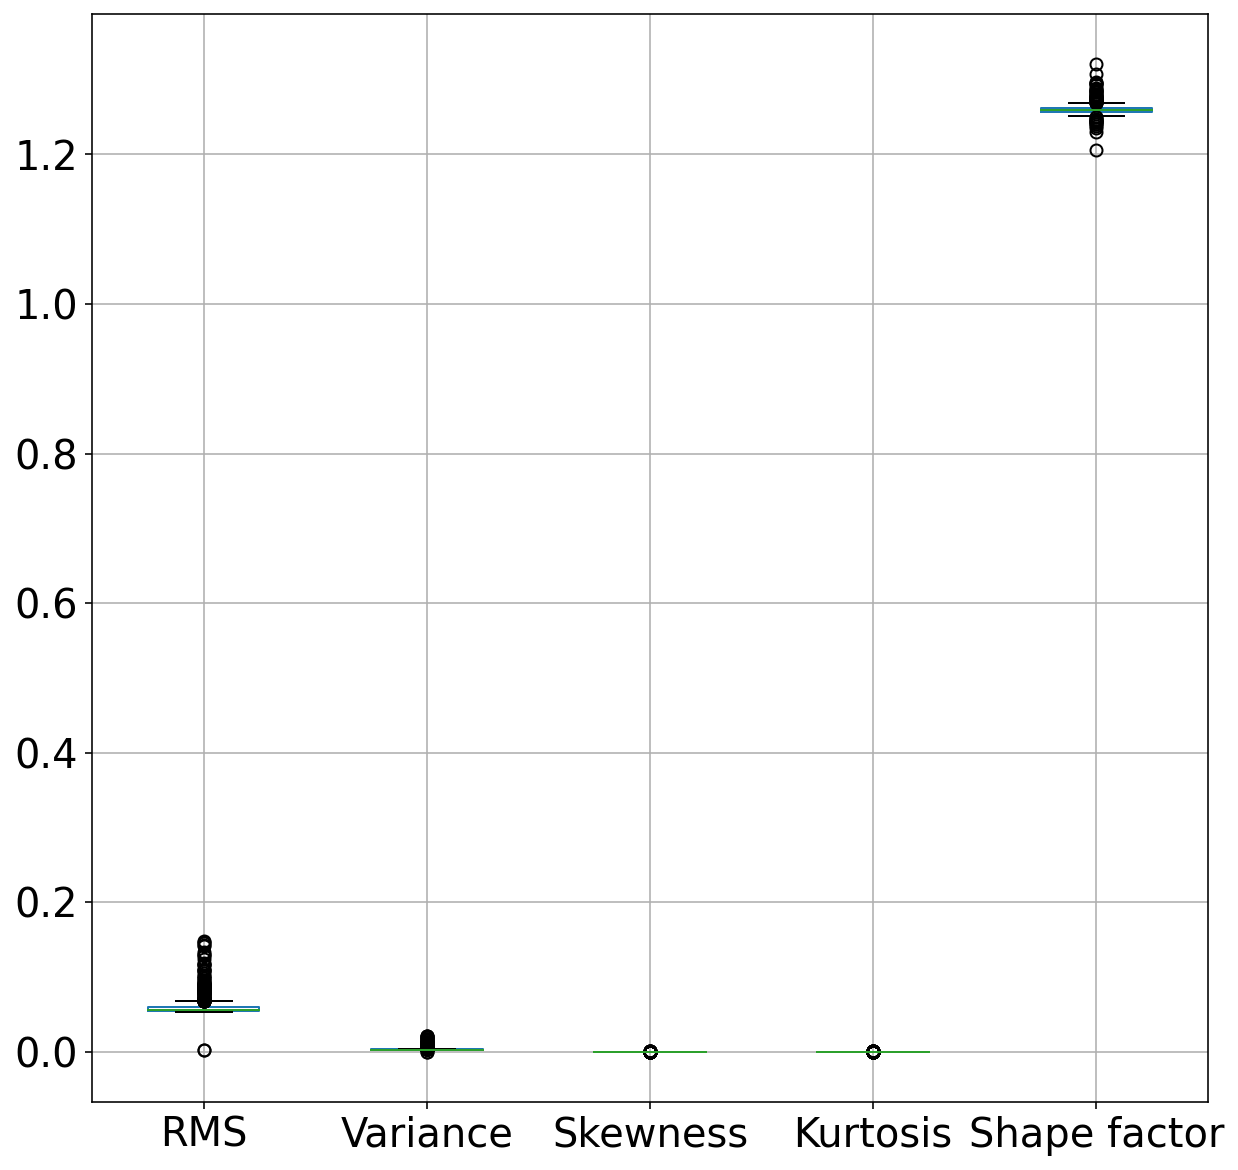

In [25]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch4_features_df.boxplot(column=['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor']);

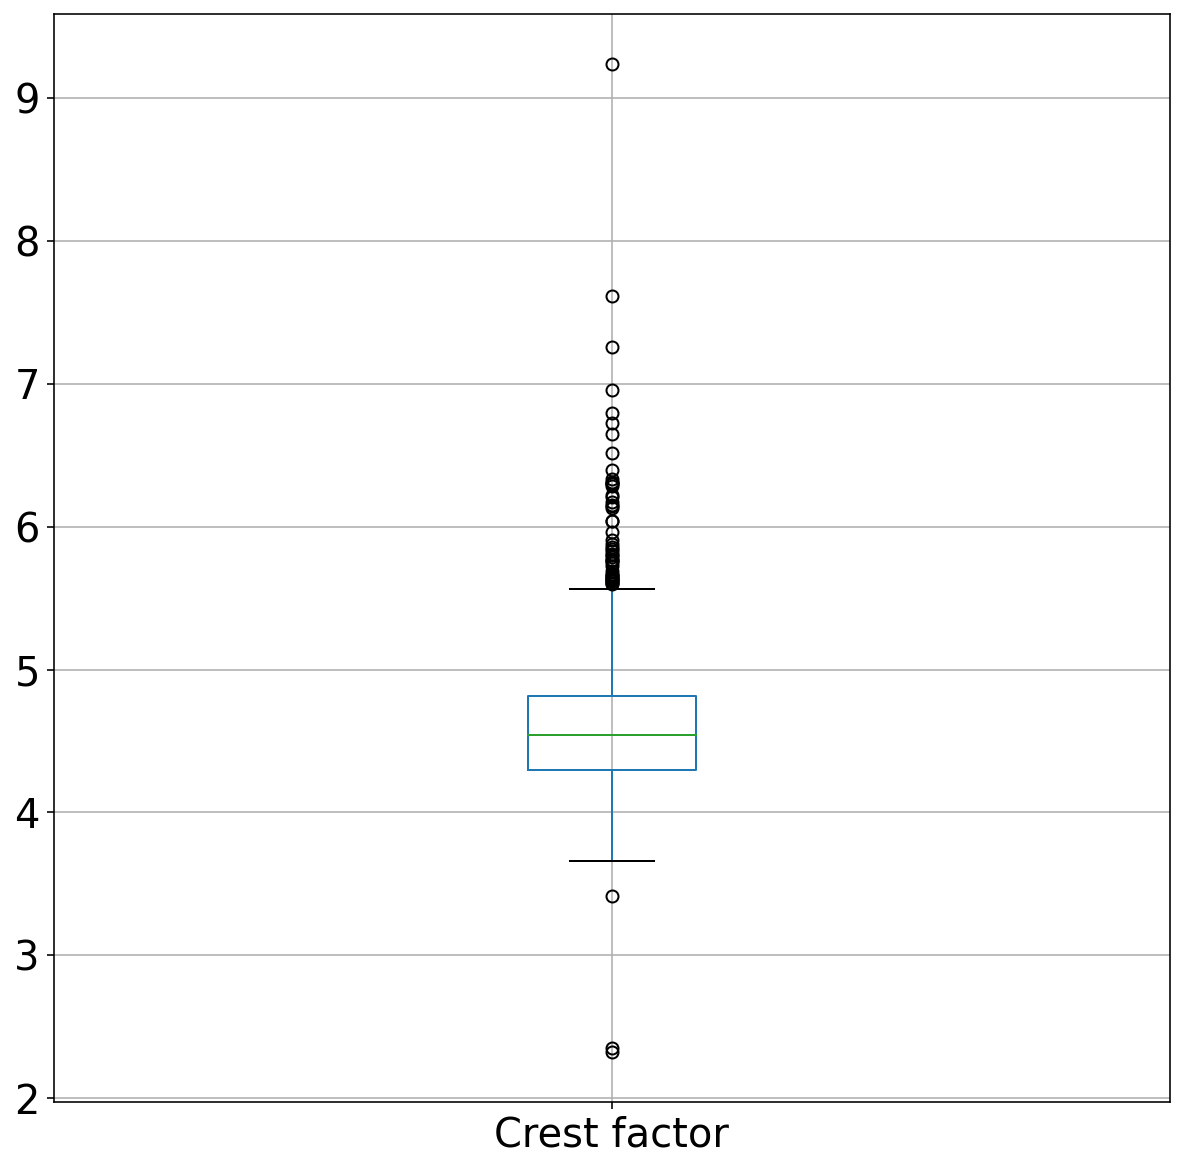

In [26]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch4_features_df.boxplot(column=['Crest factor']);

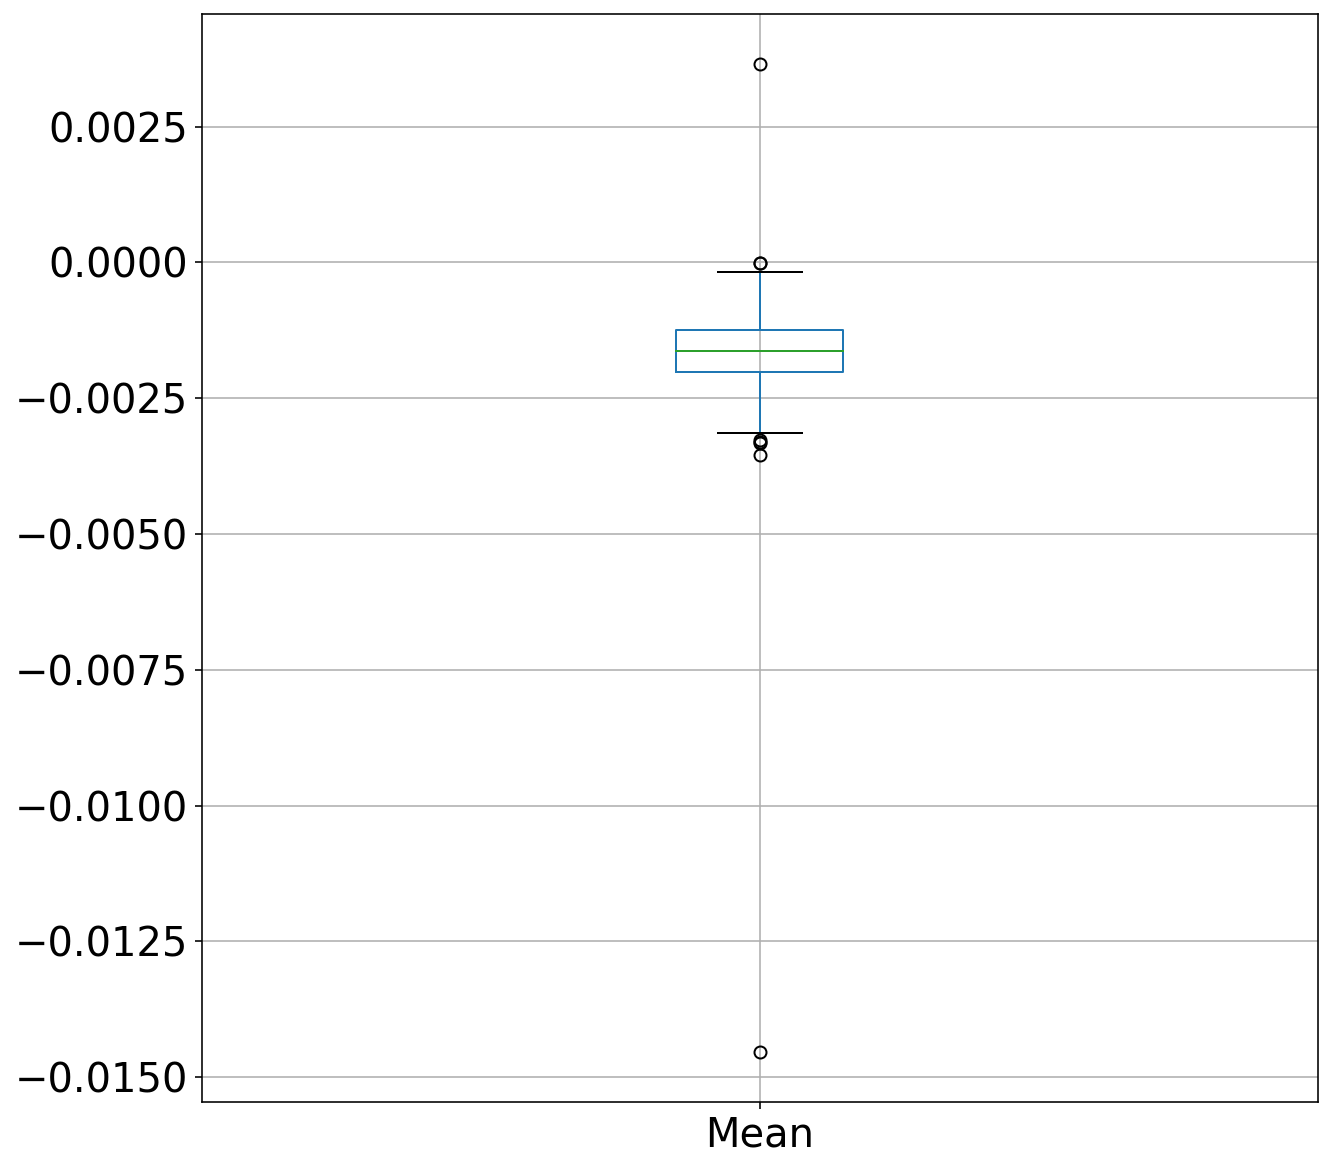

In [27]:
# Boxplot
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["font.size"] = 20
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

ch3_features_df.boxplot(column=['Mean']);

## 1c Data quality issue

The dataset needs normalization.

## 1d

Plot the six features as functions of time for each of the channels

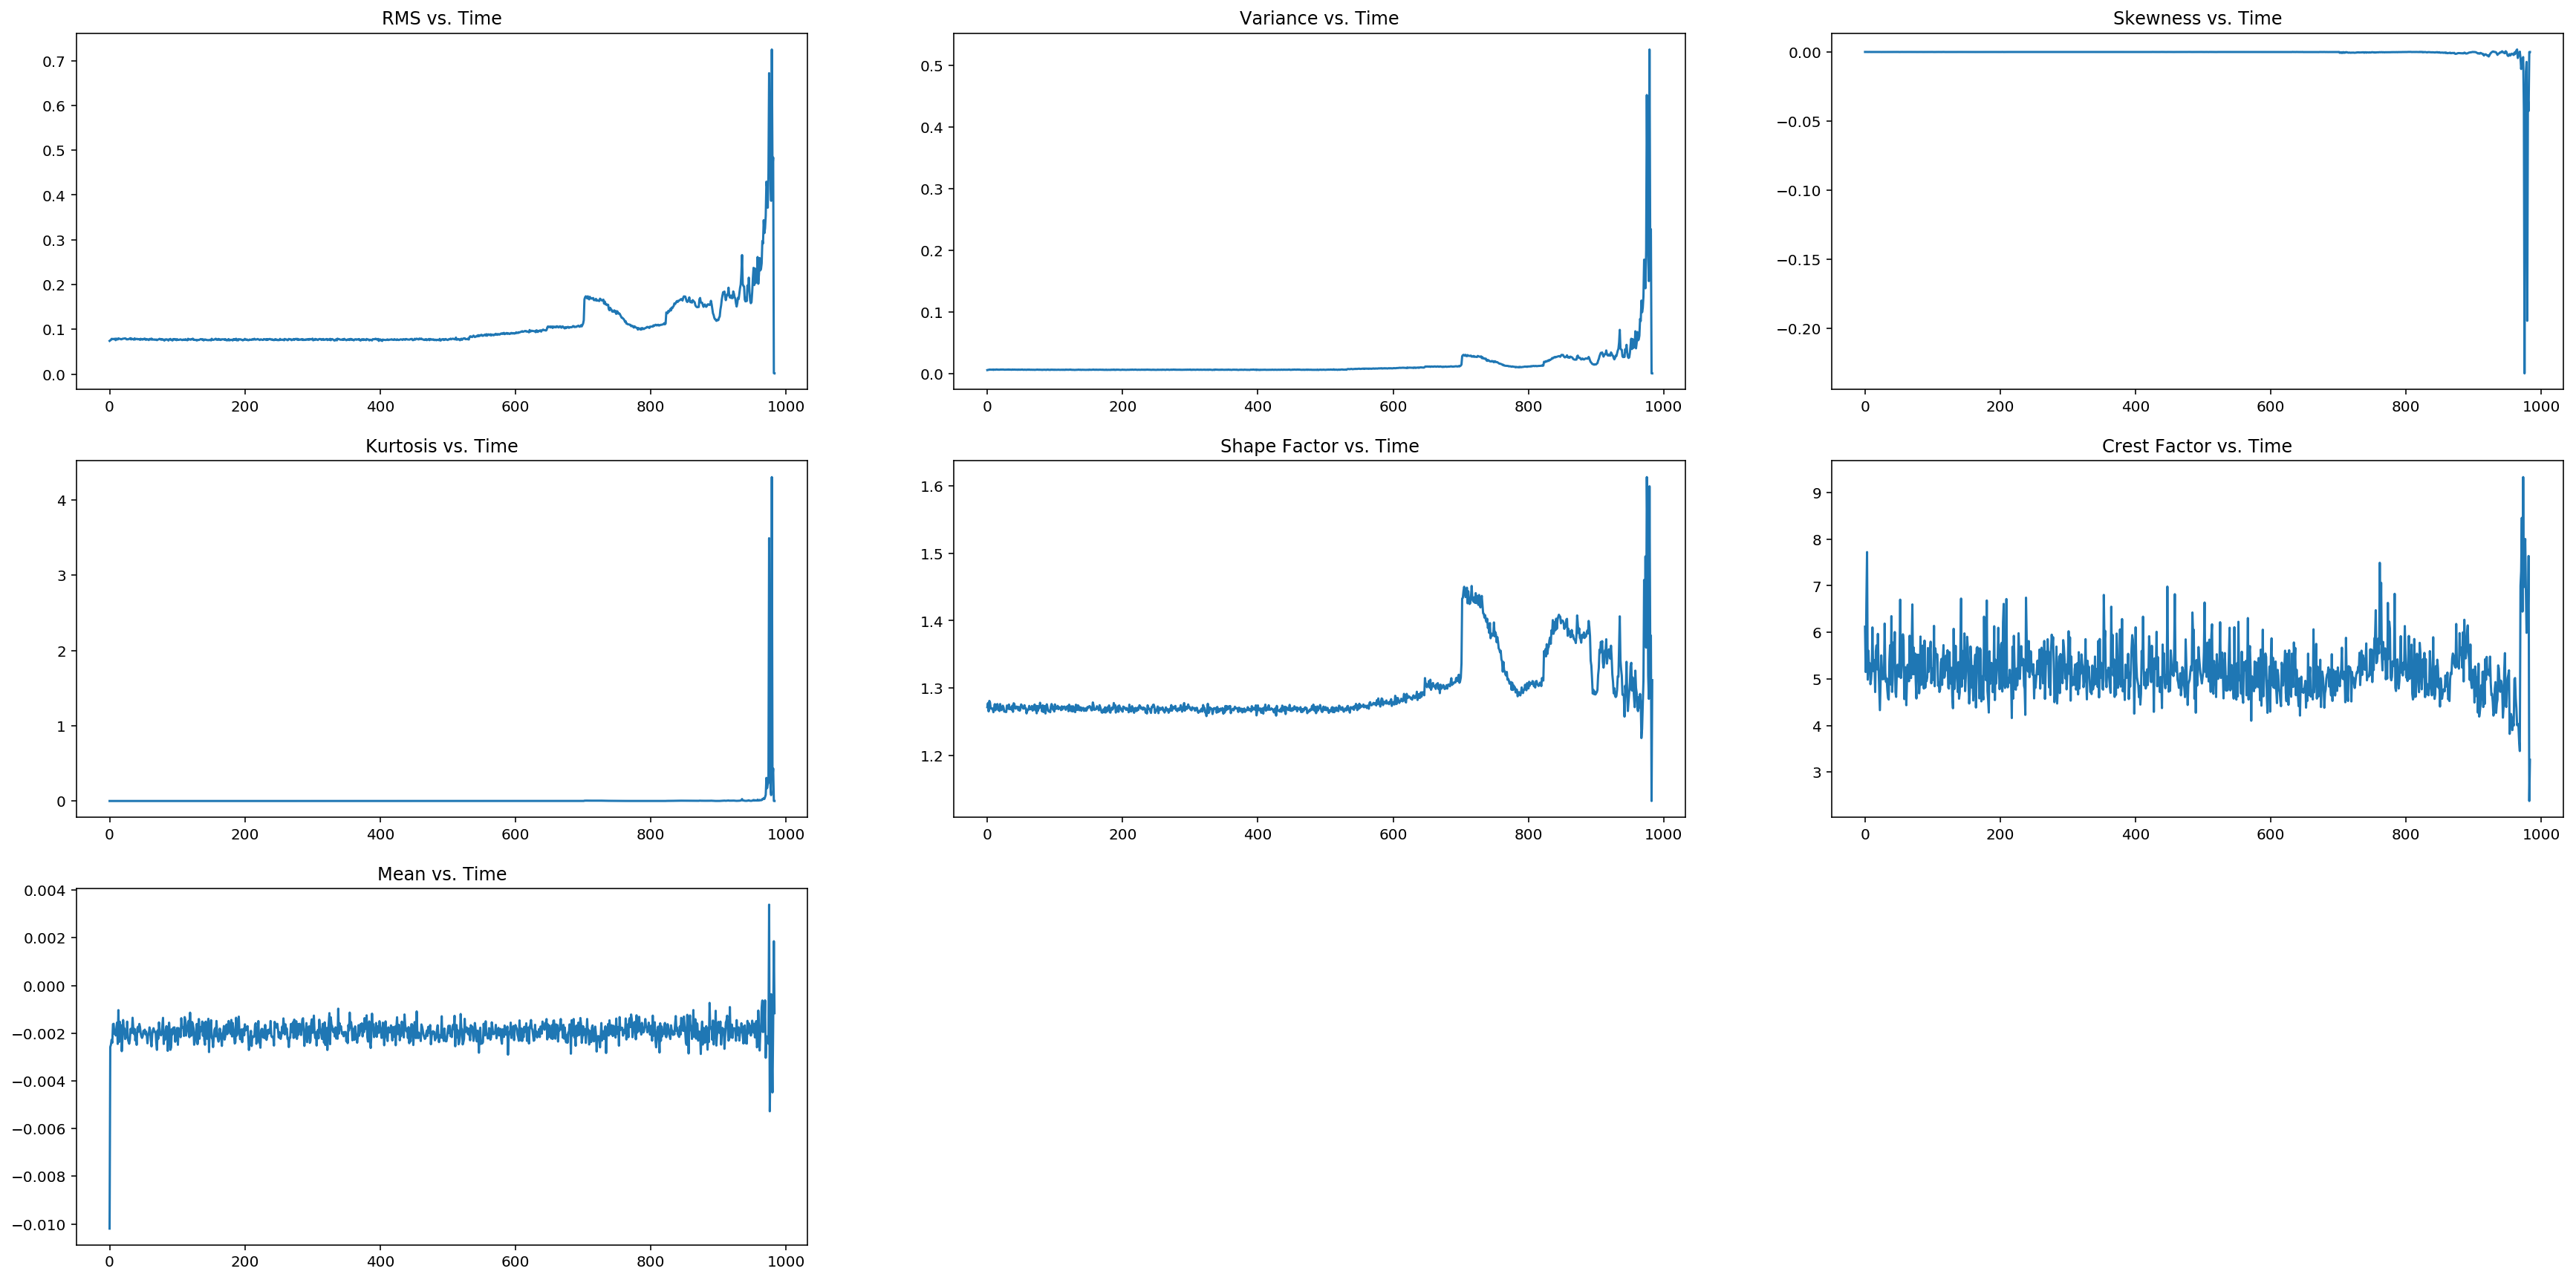

In [4]:
plt.figure(figsize=(30,15))

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(3, 3, 1)
plt.title("RMS vs. Time")
plt.plot(ch1_features_df['RMS'])
plt.subplot(3, 3, 2)
plt.title("Variance vs. Time")
plt.plot(ch1_features_df['Variance'])
plt.subplot(3, 3, 3)
plt.title("Skewness vs. Time")
plt.plot(ch1_features_df['Skewness'])
plt.subplot(3, 3, 4)
plt.title("Kurtosis vs. Time")
plt.plot(ch1_features_df['Kurtosis'])
plt.subplot(3, 3, 5)
plt.title("Shape Factor vs. Time")
plt.plot(ch1_features_df['Shape factor'])
plt.subplot(3, 3, 6)
plt.title("Crest Factor vs. Time")
plt.plot(ch1_features_df['Crest factor'])
plt.subplot(3, 3, 7)
plt.title("Mean vs. Time")
plt.plot(ch1_features_df['Mean'])

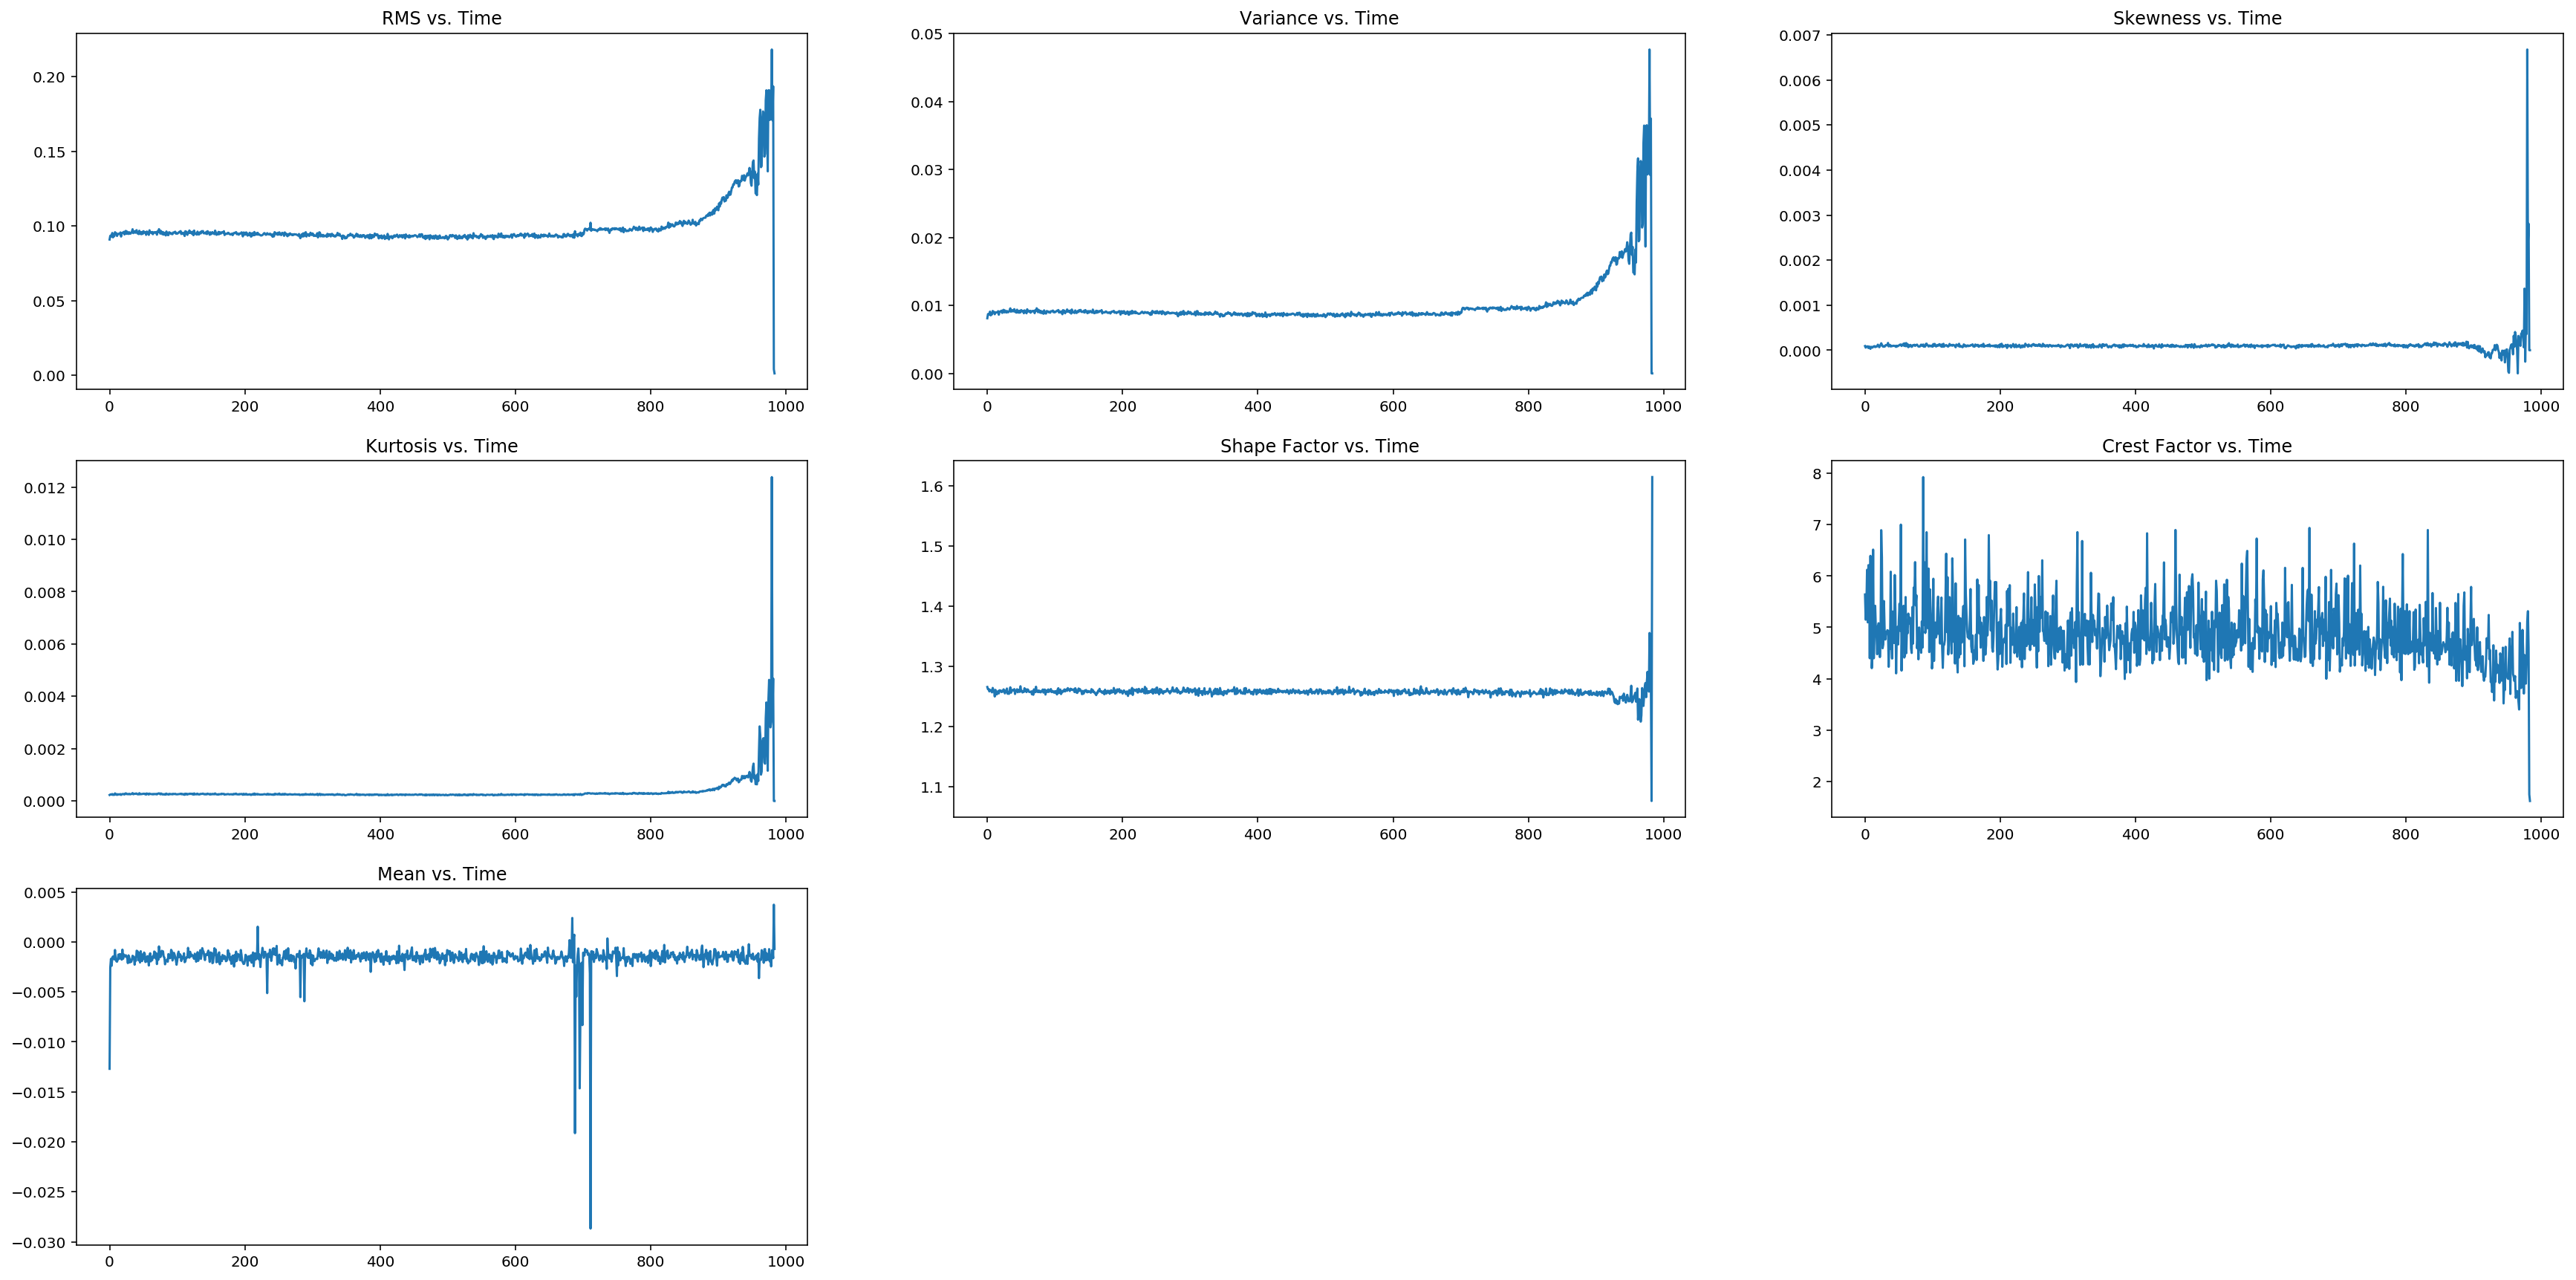

In [5]:
plt.figure(figsize=(30,15))

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(3, 3, 1)
plt.title("RMS vs. Time")
plt.plot(ch2_features_df['RMS'])
plt.subplot(3, 3, 2)
plt.title("Variance vs. Time")
plt.plot(ch2_features_df['Variance'])
plt.subplot(3, 3, 3)
plt.title("Skewness vs. Time")
plt.plot(ch2_features_df['Skewness'])
plt.subplot(3, 3, 4)
plt.title("Kurtosis vs. Time")
plt.plot(ch2_features_df['Kurtosis'])
plt.subplot(3, 3, 5)
plt.title("Shape Factor vs. Time")
plt.plot(ch2_features_df['Shape factor'])
plt.subplot(3, 3, 6)
plt.title("Crest Factor vs. Time")
plt.plot(ch2_features_df['Crest factor'])
plt.subplot(3, 3, 7)
plt.title("Mean vs. Time")
plt.plot(ch2_features_df['Mean'])

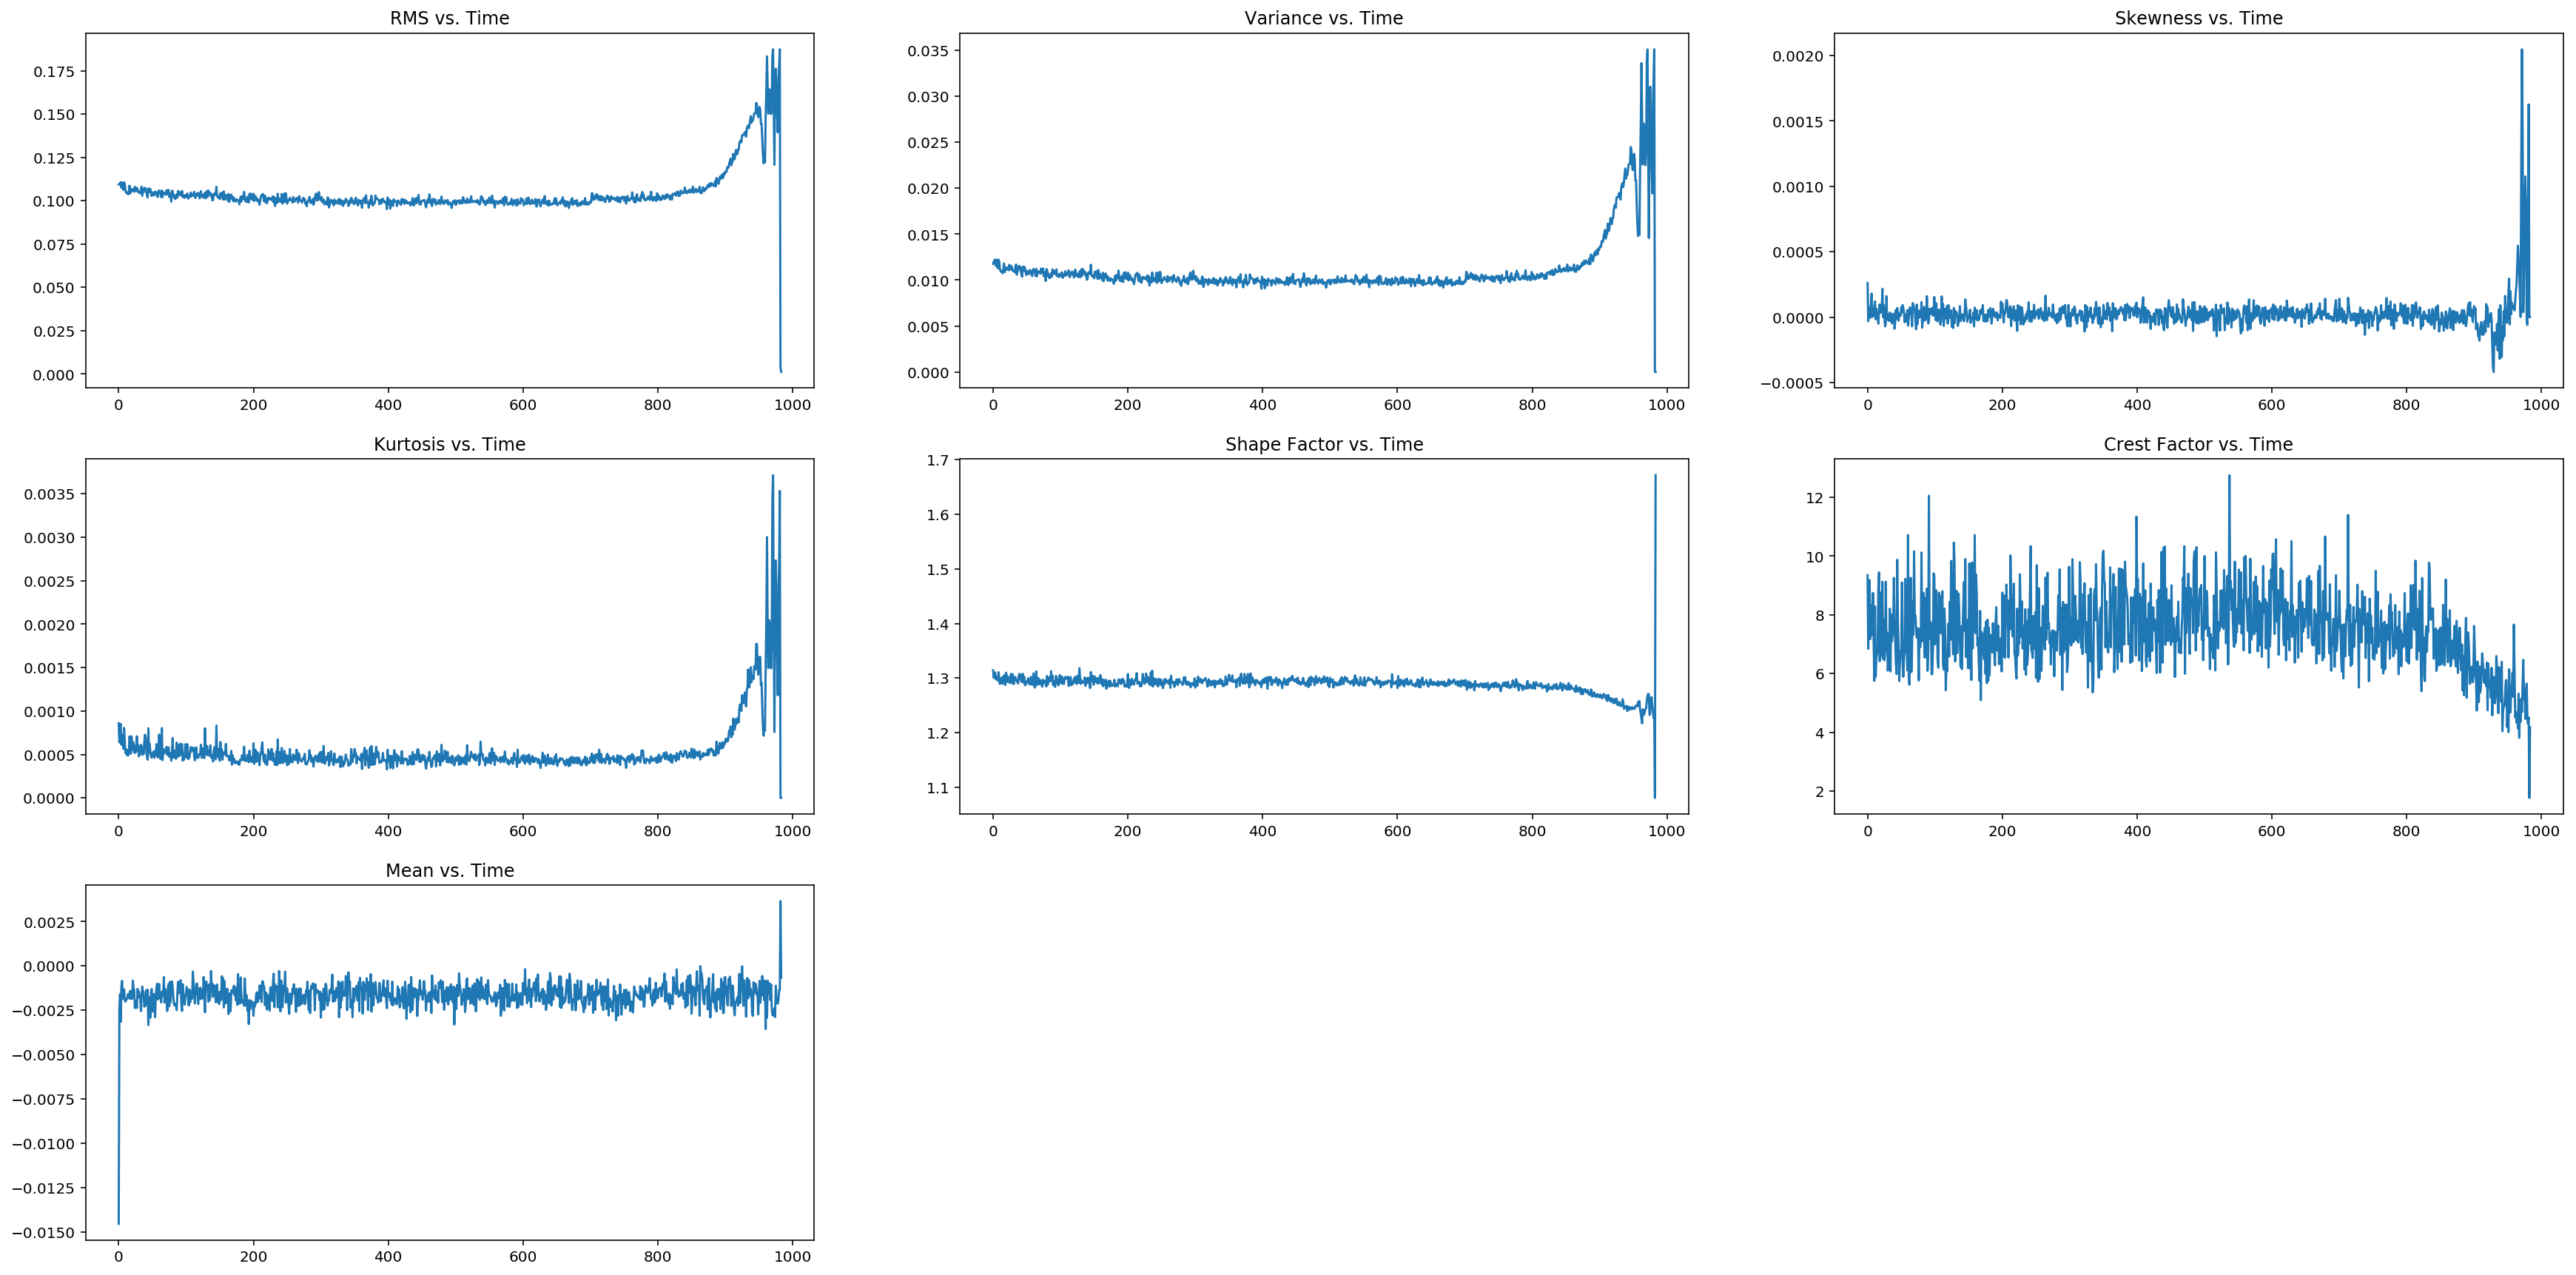

In [6]:
plt.figure(figsize=(30,15))

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(3, 3, 1)
plt.title("RMS vs. Time")
plt.plot(ch3_features_df['RMS'])
plt.subplot(3, 3, 2)
plt.title("Variance vs. Time")
plt.plot(ch3_features_df['Variance'])
plt.subplot(3, 3, 3)
plt.title("Skewness vs. Time")
plt.plot(ch3_features_df['Skewness'])
plt.subplot(3, 3, 4)
plt.title("Kurtosis vs. Time")
plt.plot(ch3_features_df['Kurtosis'])
plt.subplot(3, 3, 5)
plt.title("Shape Factor vs. Time")
plt.plot(ch3_features_df['Shape factor'])
plt.subplot(3, 3, 6)
plt.title("Crest Factor vs. Time")
plt.plot(ch3_features_df['Crest factor'])
plt.subplot(3, 3, 7)
plt.title("Mean vs. Time")
plt.plot(ch3_features_df['Mean'])

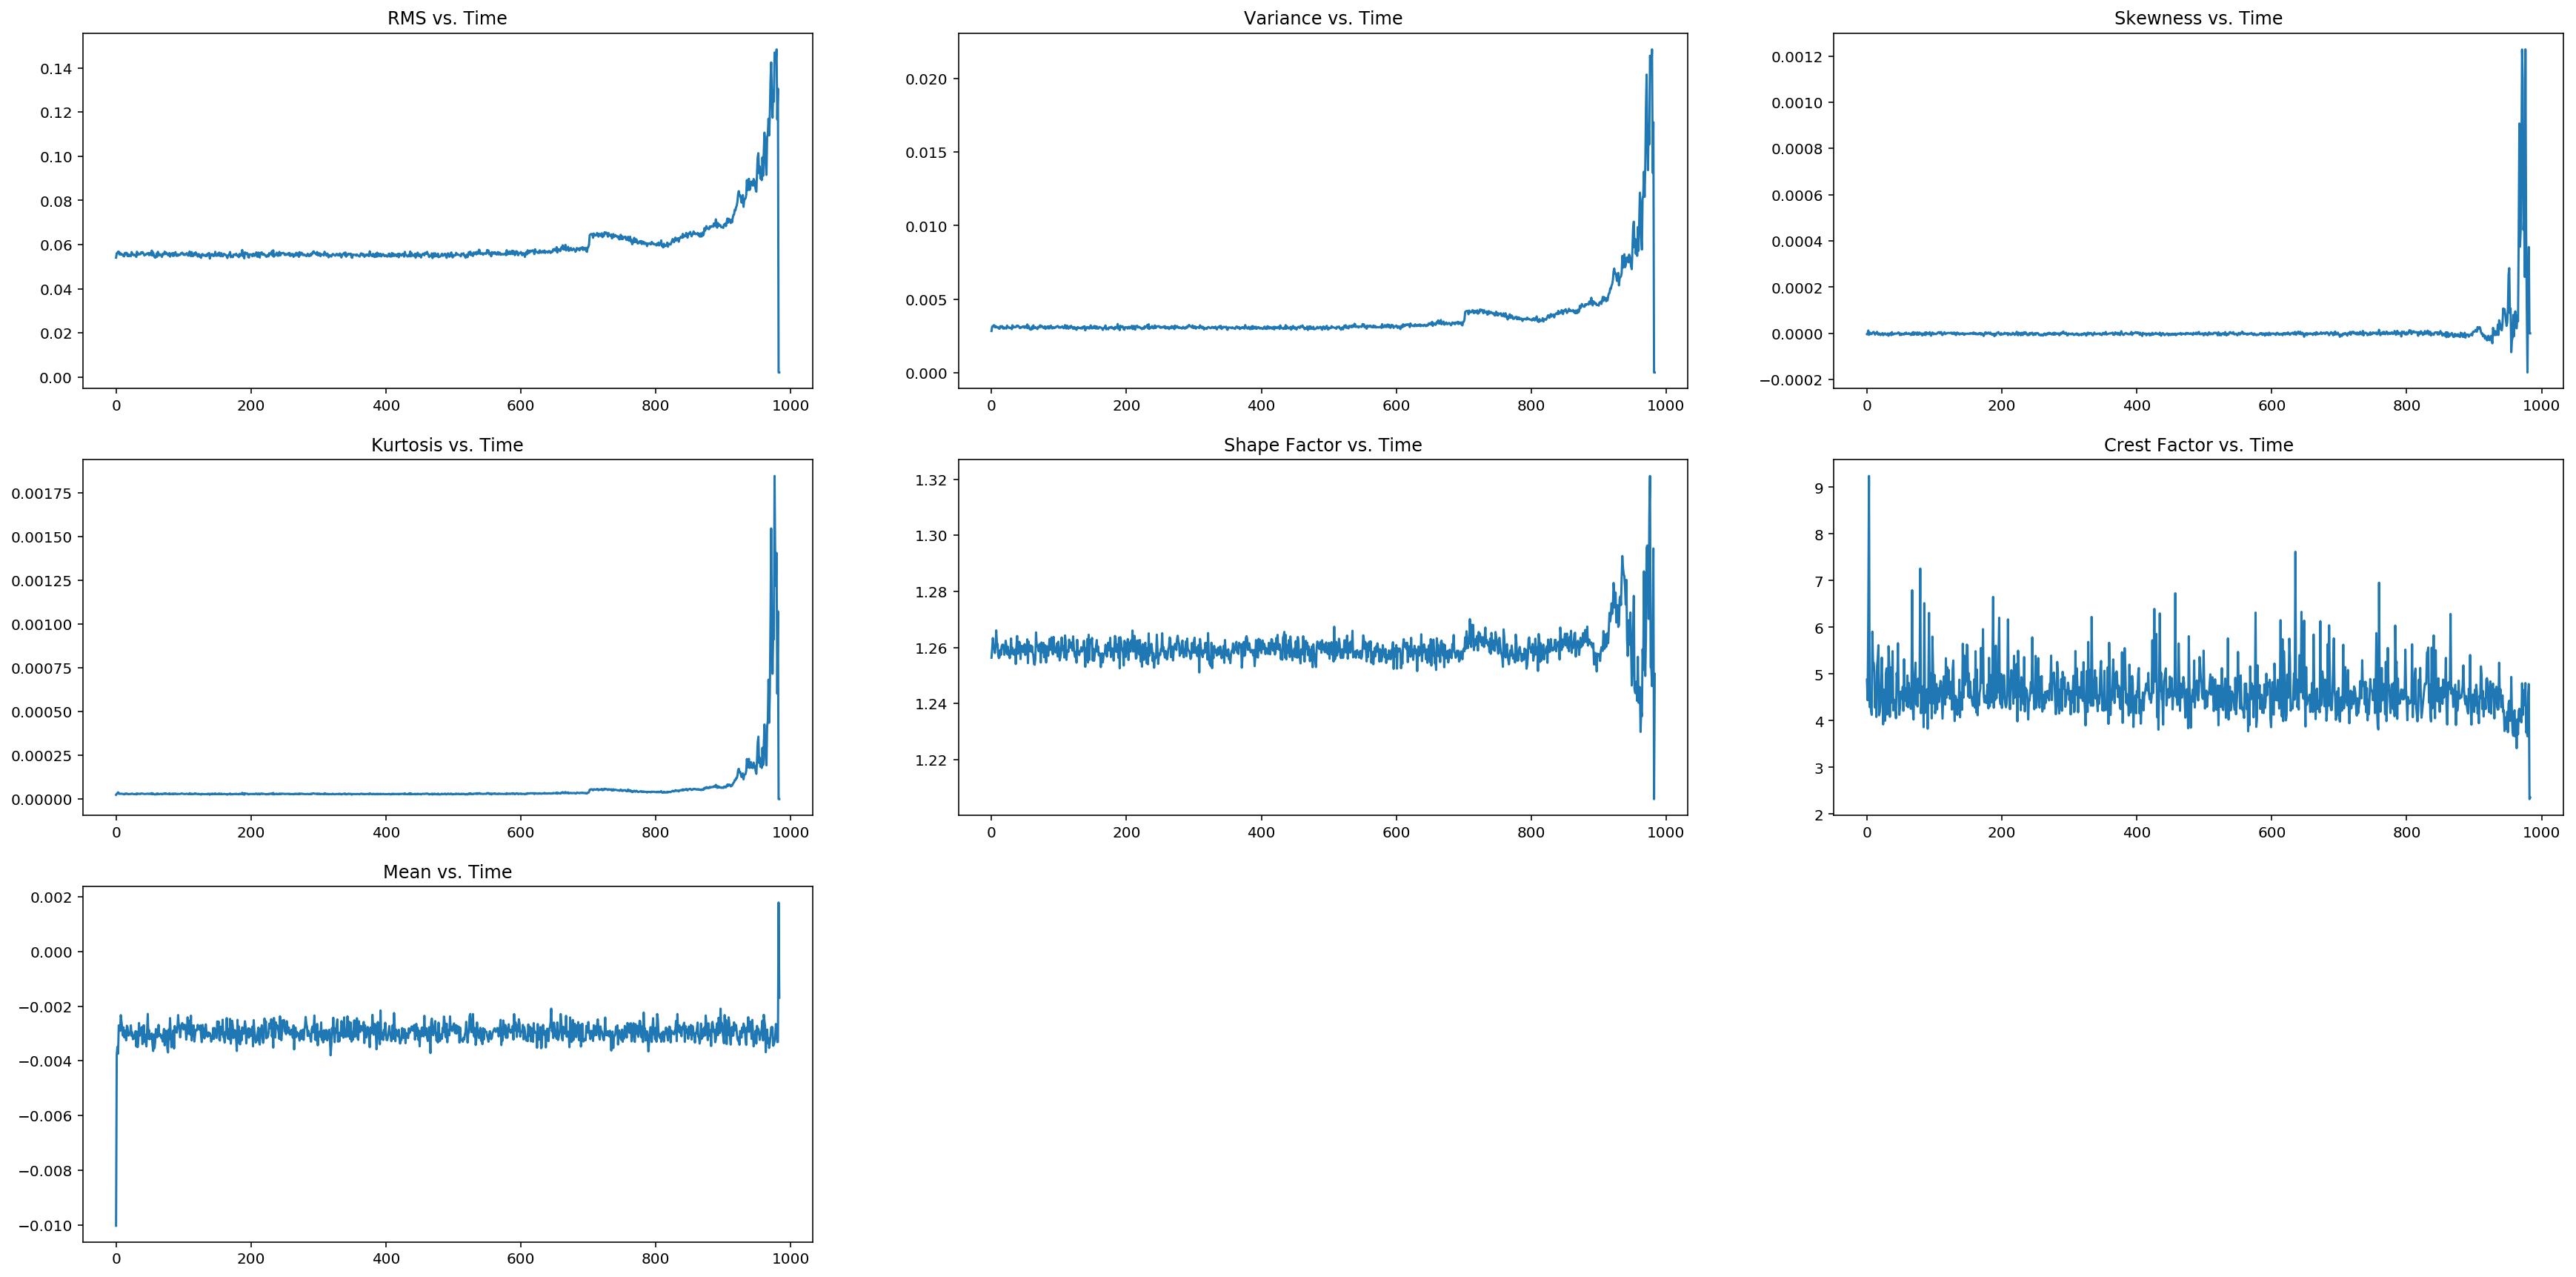

In [7]:
plt.figure(figsize=(30,15))

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(3, 3, 1)
plt.title("RMS vs. Time")
plt.plot(ch4_features_df['RMS'])
plt.subplot(3, 3, 2)
plt.title("Variance vs. Time")
plt.plot(ch4_features_df['Variance'])
plt.subplot(3, 3, 3)
plt.title("Skewness vs. Time")
plt.plot(ch4_features_df['Skewness'])
plt.subplot(3, 3, 4)
plt.title("Kurtosis vs. Time")
plt.plot(ch4_features_df['Kurtosis'])
plt.subplot(3, 3, 5)
plt.title("Shape Factor vs. Time")
plt.plot(ch4_features_df['Shape factor'])
plt.subplot(3, 3, 6)
plt.title("Crest Factor vs. Time")
plt.plot(ch4_features_df['Crest factor'])
plt.subplot(3, 3, 7)
plt.title("Mean vs. Time")
plt.plot(ch4_features_df['Mean'])

Compute and plot the histograms of the vibration signals for each data
file.

In [9]:
all_files_df = pd.DataFrame()
 
for filename in os.listdir('2nd_test'): # get a list of files in the directory
    with open(os.path.join('2nd_test', filename), 'r') as f: # open in readonly mode
        tsv_file = pd.read_csv(f,delimiter='\t',encoding='utf-8',header=None)
        all_files_df = all_files_df.append(tsv_file)

all_files_df.columns = ['Ch1', 'Ch2', 'Ch3', 'Ch4']

In [10]:
all_files_df.head()

Ch1    Ch2    Ch3    Ch4
0 -0.049 -0.071 -0.132 -0.010
1 -0.042 -0.073 -0.007 -0.105
2  0.015  0.000  0.007  0.000
3 -0.051  0.020 -0.002  0.100
4 -0.107  0.010  0.127  0.054

In [11]:
np.savetxt('all_files.txt', all_files_df.values, delimiter ='\t')

In [12]:
all_files = np.loadtxt('all_files.txt')

No handles with labels found to put in legend.


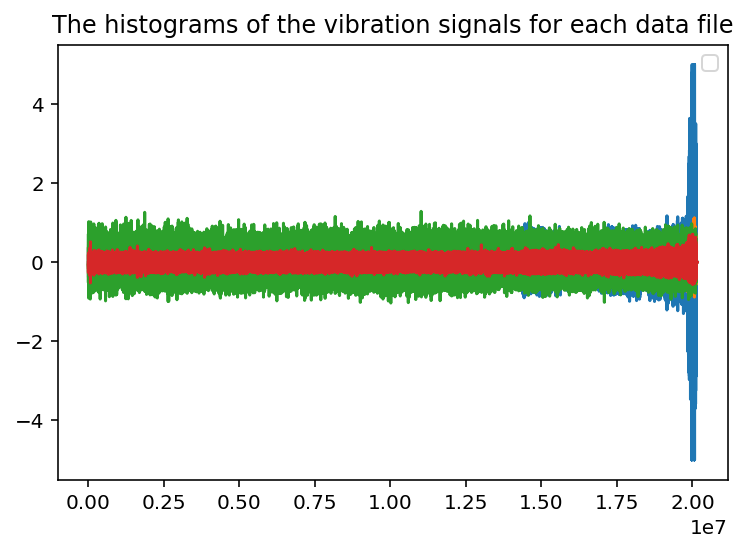

In [13]:
plt.plot(all_files)
plt.title("The histograms of the vibration signals for each data file")
plt.legend()

#### Describe your observations. How similar are the plots of the different channels? Is there any evidence in the plots for which features are the most useful for the RUL prediction task? Is the normalization of the data useful?

We can see that the blue plot has an obvious huge spike towards the end of the 2nd test, as we know, bearing 1 failed at the end of the test, therefore, we can conclude that blue plot corresponds to the vibration signal in channel 1( bearing 1). Other channels express similar behavior where the vibration signal is uniform and starting to have the trend to fail but not as server as channel 1 plot.

We can see that the trend of RMS and Variance over time look more similar to the HIs of vibration signals, which can be considered as the evidence.

The normalization of the data is very useful in terms of  removes some aspect of the data that is irrelevant.

## 1e. Normalization (Min-Max)

In [24]:
x1 = ch1_features_df.loc[:,['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean']].to_numpy() #returns a numpy array
x2 = ch2_features_df.loc[:,['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean']].to_numpy() #returns a numpy array
x3 = ch3_features_df.loc[:,['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean']].to_numpy() #returns a numpy array
x4 = ch4_features_df.loc[:,['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean']].to_numpy() #returns a numpy array

In [15]:
# Use min_max_scaler to normalize to range 0-1
min_max_scaler = preprocessing.MinMaxScaler()

x1_scaled = min_max_scaler.fit_transform(x1)
x2_scaled = min_max_scaler.fit_transform(x2)
x3_scaled = min_max_scaler.fit_transform(x3)
x4_scaled = min_max_scaler.fit_transform(x4)

In [16]:
# add column names back
ch1_df = pd.DataFrame(x1_scaled, columns = {'RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean'})
ch2_df = pd.DataFrame(x2_scaled, columns = {'RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean'})
ch3_df = pd.DataFrame(x3_scaled, columns = {'RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean'})
ch4_df = pd.DataFrame(x4_scaled, columns = {'RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean'})

In [17]:
# append RUL to normalized dataframe
ch1_df['RUL'] = ch1_features_df.loc[:,['RUL']].to_numpy()
ch2_df['RUL'] = ch2_features_df.loc[:,['RUL']].to_numpy()
ch3_df['RUL'] = ch3_features_df.loc[:,['RUL']].to_numpy()
ch4_df['RUL'] = ch4_features_df.loc[:,['RUL']].to_numpy()

In [41]:
ch1_df.head()

RMS  Kurtosis  Crest factor  ...  Variance  Shape factor        RUL
0  0.104789  0.011372      0.992181  ...  0.457468      0.605074  10.000000
1  0.234263  0.055638      0.985125  ...  0.438327      0.683932   9.999512
2  0.133959  0.018433      0.992200  ...  0.325559      0.639151   9.999023
3  0.102924  0.010974      0.992208  ...  0.286265      0.569290   9.998535
4  0.209452  0.044560      0.990544  ...  0.323181      0.567982   9.998047

[5 rows x 8 columns]

In [42]:
# Display Data Quality Report after normalizing
with pd.option_context('display.float_format', '{:.2f}'.format):
    print("Data quality report for Channel 1")
    display(buildContinuousFeaturesReport(ch1_features_df.select_dtypes('number').columns.to_list(), ch1_df))
    print("\nData quality report for Channel 2")
    display(buildContinuousFeaturesReport(ch2_features_df.select_dtypes('number').columns.to_list(), ch2_df))
    print("\nData quality report for Channel 3")
    display(buildContinuousFeaturesReport(ch3_features_df.select_dtypes('number').columns.to_list(), ch3_df))
    print("\nData quality report for Channel 4")
    display(buildContinuousFeaturesReport(ch4_features_df.select_dtypes('number').columns.to_list(), ch4_df))

Data quality report for Channel 1


Count  Miss %  Card.  Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984 0.00  ...    0.11     0.15  1.00       0.08
Variance        984    0.00    984 0.00  ...    0.39     0.44  1.00       0.08
Skewness        984    0.00    984 0.00  ...    0.29     0.36  1.00       0.10
Kurtosis        984    0.00    984 0.00  ...    0.01     0.02  1.00       0.06
Shape factor    984    0.00    982 0.00  ...    0.61     0.62  1.00       0.04
Crest factor    984    0.00    984 0.00  ...    0.99     0.99  1.00       0.04
Mean            984    0.00    984 0.00  ...    0.00     0.00  1.00       0.04
RUL             984    0.00    984 9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]


Data quality report for Channel 2


Count  Miss %  Card.  Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984 0.00  ...    0.43     0.44  1.00       0.07
Variance        984    0.00    984 0.00  ...    0.50     0.56  1.00       0.09
Skewness        984    0.00    984 0.00  ...    0.34     0.34  1.00       0.03
Kurtosis        984    0.00    984 0.00  ...    0.19     0.20  1.00       0.08
Shape factor    984    0.00    979 0.00  ...    0.84     0.85  1.00       0.04
Crest factor    984    0.00    984 0.00  ...    0.09     0.09  1.00       0.03
Mean            984    0.00    984 0.00  ...    0.02     0.02  1.00       0.04
RUL             984    0.00    984 9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]


Data quality report for Channel 3


Count  Miss %  Card.  Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984 0.00  ...    0.54     0.55  1.00       0.07
Variance        984    0.00    984 0.00  ...    0.51     0.59  1.00       0.12
Skewness        984    0.00    984 0.00  ...    0.36     0.36  1.00       0.03
Kurtosis        984    0.00    984 0.00  ...    0.29     0.31  1.00       0.10
Shape factor    984    0.00    981 0.00  ...    0.71     0.73  1.00       0.04
Crest factor    984    0.00    984 0.00  ...    0.18     0.19  1.00       0.05
Mean            984    0.00    984 0.00  ...    0.13     0.14  1.00       0.09
RUL             984    0.00    984 9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]


Data quality report for Channel 4


Count  Miss %  Card.  Min  ...  Median  3rd Qrt   Max  Std. Dev.
RMS             984    0.00    984 0.00  ...    0.37     0.40  1.00       0.08
Variance        984    0.00    984 0.00  ...    0.32     0.36  1.00       0.08
Skewness        984    0.00    984 0.00  ...    0.46     0.48  1.00       0.05
Kurtosis        984    0.00    984 0.00  ...    0.14     0.17  1.00       0.09
Shape factor    984    0.00    983 0.00  ...    0.60     0.61  1.00       0.03
Crest factor    984    0.00    984 0.00  ...    0.12     0.12  1.00       0.06
Mean            984    0.00    984 0.00  ...    0.02     0.02  1.00       0.07
RUL             984    0.00    984 9.52  ...    9.76     9.88 10.00       0.14

[8 rows x 10 columns]

In [18]:
# Get features from all channels for later use
ch1 = ch1_df.copy()
ch2 = ch2_df.copy()
ch3 = ch3_df.copy()
ch4 = ch4_df.copy()

In [19]:
#rename dataframe column names
ch1 = ch1.rename(columns = {'RMS':'RMS1', 'Variance':'Variance1', 'Skewness':'Skewness1', 
                                  'Kurtosis':'Kurtosis1', 'Shape factor':'Shape factor1', 
                                  'Crest factor':'Crest factor1', 'Mean':'Mean1', 'RUL':'RUL1'}) 
ch2 = ch2.rename(columns = {'RMS':'RMS2', 'Variance':'Variance2', 'Skewness':'Skewness2', 
                                  'Kurtosis':'Kurtosis2', 'Shape factor':'Shape factor2', 
                                  'Crest factor':'Crest factor2', 'Mean':'Mean2', 'RUL':'RUL2'})
ch3 = ch3.rename(columns = {'RMS':'RMS3', 'Variance':'Variance3', 'Skewness':'Skewness3', 
                                  'Kurtosis':'Kurtosis3', 'Shape factor':'Shape factor3', 
                                  'Crest factor':'Crest factor3', 'Mean':'Mean3', 'RUL':'RUL3'})
ch4 = ch4.rename(columns = {'RMS':'RMS4', 'Variance':'Variance4', 'Skewness':'Skewness4', 
                                  'Kurtosis':'Kurtosis4', 'Shape factor':'Shape factor4',
                                  'Crest factor':'Crest factor4', 'Mean':'Mean4', 'RUL':'RUL4'}) 

In [20]:
# making a dataframe combining features from all channels
all_features_df = ch1.copy()
all_features_df = all_features_df.join(ch2)
all_features_df = all_features_df.join(ch3)
all_features_df = all_features_df.join(ch4)

In [46]:
all_features_df.head()

RMS1  Kurtosis1  Crest factor1  ...  Variance4  Shape factor4       RUL4
0  0.104789   0.011372       0.992181  ...   0.636932       0.649537  10.000000
1  0.234263   0.055638       0.985125  ...   0.278799       0.604217   9.999512
2  0.133959   0.018433       0.992200  ...   0.277244       0.575263   9.999023
3  0.102924   0.010974       0.992208  ...   0.241414       0.607578   9.998535
4  0.209452   0.044560       0.990544  ...   0.330192       0.636829   9.998047

[5 rows x 32 columns]

# 2. Build a baseline model to predict RLU (0.35)

### 2a. Explain what is the task you’re solving (e.g., supervised x unsupervised, classification x regression x clustering or similarity matching x etc)

The task that we are solving is a supervised task. A regression model will suit more because the data (vibration signal) is continuous. Using a neural network like CNN and RNN is more useful. This kind of model suits very well the analysis of time series data from sensors and imposes to reshape the data in short fixed-length.

### 2b. Feature Selection


#### Feature Selection with Channel 1 data only

We will try to see how choosing different dataset and feature affects the model performance. First we used LassoCV model to select features based on feature importance (https://bit.ly/3gaJOZv).

In [25]:
# Features and Target
X = ch1_df.drop(['RUL'], axis=1)
y = ch1_df.RUL

# Using LassoCV for feature selection
clf = LassoCV(cv = 10).fit(X, y)
importance = np.abs(clf.coef_)
print(importance)

[0.70368123 0.         0.05407913 0.22509084 0.4641883  0.20751085
 0.        ]


**Comment**: The importance of the features indicates that Variance and Mean are not that important for RUL prediction.

In [26]:
# Get important features names from channel 1 dataset using LassoCV
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
feature_names = list(ch1_df.columns) 
idx_features = (-importance).argsort()[:5]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

Selected features: ['Mean' 'Kurtosis' 'Crest factor' 'Skewness' 'Shape factor']


In [33]:
# Training on 2nd Test Channel 1 data only with only important feature selected above
X_sel_f = ch1_df.drop(['RUL', 'Variance', 'Skewness','Mean'], axis=1)
y_sel_f = ch1_features_df.RUL

X_train, X_test, y_train, y_test = train_test_split(X_sel_f, y_sel_f, test_size=0.1, random_state=10)

In [34]:
clf = LassoCV(cv = 10).fit(X_sel_f, y_sel_f)

In [35]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.45994406534213184, 0.5116036798732571)

In [36]:
y_pred = clf.predict(X_sel_f)

**Comment**: The performance score above is base on R^2. As we know the better the linear regression fits the data in comparison to the simple average, the closer the value R^2 is to 1. In the previous model, the model underfits with We shall see whether using features from all channels will help improving the score. We are not going to experienment with different subsets of the six features since it might eliminate some useful data in the dataset.

In [37]:
pred = clf.predict(X_test)
mse = np.mean(sum((pred - y_test)**2))
mse

0.8583838217237789

#### Feature Selection with all features from all channels

In [52]:
# Features and Target
X_a = all_features_df.drop(['RUL1','RUL2','RUL3','RUL4'], axis=1)
y_a = all_features_df.RUL1

# Using LassoCV for feature selection
lassocv = LassoCV(cv = 30, tol = 0.08).fit(X_a, y_a)
importance = np.abs(lassocv.coef_)
print(importance)
X_a.head()

[0.45145905 0.         0.         0.         0.4416657  0.04658337
 0.         0.         0.         0.         0.         0.
 0.10378515 0.         0.         0.         0.         0.
 0.         0.         0.         0.01958719 0.         0.
 0.         0.         0.         0.        ]


Mean1      RMS1  Shape factor1  Crest factor1  Kurtosis1  Skewness1  \
0  0.100414  0.010269       0.992403       0.000025   0.289522   0.538087   
1  0.102077  0.010797       0.992356       0.000027   0.302182   0.398167   
2  0.103248  0.011042       0.992323       0.000028   0.276608   0.606828   
3  0.106696  0.011779       0.992347       0.000037   0.309034   0.768528   
4  0.106351  0.011703       0.992319       0.000032   0.304584   0.374509   

   Variance1     Mean2      RMS2  Shape factor2  ...  Kurtosis3  Skewness3  \
0   0.000000  0.413282  0.170167       0.084486  ...   0.395468   0.690235   
1   0.560247  0.424684  0.182987       0.079535  ...   0.372290   0.462277   
2   0.567683  0.426062  0.184239       0.082647  ...   0.386717   0.612081   
3   0.582948  0.422511  0.181160       0.083403  ...   0.388687   0.674760   
4   0.573582  0.433572  0.190716       0.083401  ...   0.367631   0.491784   

   Variance3     Mean4      RMS4  Shape factor4  Crest factor4  Kurtosis4  \
0   0.000000  0.355470  0.128431       0.118842       0.013265   0.437513   
1   0.663863  0.369130  0.142356       0.121414       0.016517   0.465629   
2   0.711418  0.369433  0.142681       0.130080       0.017392   0.498379   
3   0.626101  0.373962  0.145997       0.116484       0.021278   0.470430   
4   0.735431  0.374191  0.146474       0.123703       0.017663   0.467858   

   Skewness4  Variance4  
0   0.369634   0.000000  
1   0.305892   0.528491  
2   0.575633   0.553749  
3   1.000000   0.532125  
4   0.284830   0.620021  

[5 rows x 28 columns]

In [53]:
# Get important features names from channel 1 dataset using LassoCV
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
feature_names = list(all_features_df.columns) 
idx_features = (-importance).argsort()[:6]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(lassocv, threshold=threshold)
sfm.fit(X_a, y_a)
X_transform = sfm.transform(X_a)

n_features = sfm.transform(X_a).shape[1]

Selected features: ['Mean1' 'Kurtosis1' 'Kurtosis2' 'Skewness1' 'Skewness3' 'RMS4']


In [73]:
# Training on 2nd Test Channel 1 data only with only important feature selected above
X_sf = all_features_df.drop(['RUL1', 'RUL2', 'RUL3', 'RUL4',      
                       'Mean1', 'Mean2', 'Mean3','Mean4',
                       'Skewness3','Skewness4',
                      'Crest factor2','Crest factor4',
                      'Shape factor4'], axis=1)
y_sf = all_features_df.RUL1

X_train, X_test, y_train, y_test = train_test_split(X_sf, y_sf, test_size=0.1, random_state=10)

In [74]:
lassocv = LassoCV(cv = 30).fit(X_sf, y_sf)

In [75]:
lassocv.score(X_train, y_train), lassocv.score(X_test, y_test)

(0.4670264076063702, 0.4896297441858706)

In [57]:
pred = lassocv.predict(X_test)
mse = np.mean(sum((pred - y_test)**2))
mse

0.9211643268559577

#### Analyze the result

We actually discovered that the model yield different result for different runtime on different platforms (Juypter vs. Collab). Initially, model performs better on the dataset with only channel 1 data. However, the results changed after running the model multiple times more. We assumed that the model with more features from across the channels produce better result, however, it is not always the case during runtime. Therefore, even though we should use more features from across the channels when applying our model to test dataset (1st Test), we only used features from one channel due to this uncertainty of results our baseline model produced.

**Comment Earlier**: By comparing the R^2 Scores of both feature selection method, it shows that by selecting features using the same feature selection method (LassoCV) and same parameter, using features from all four channels reduce the model's performance. We also actually tuned down the test size for using all features because it was overfitting when test size is larger than 10% of the dataset. However, it could be that LassoCV's evaluation metrics for feature selection is not suitable in this case.

### 2e. Train and evaluate your model on test data from Test set 1

##### Apply on Test Set 1

Load '1st_test.rar' and exteact features

In [60]:
# load data files of Test set 1
import patoolib
patoolib.extract_archive("1st_test.rar")

patool: Extracting 1st_test.rar ...
patool: running /usr/bin/unrar x -- /content/1st_test.rar
patool:     with cwd='./Unpack_9w1ipq7t'
patool: ... 1st_test.rar extracted to `1st_test'.


'1st_test'

In [61]:
# write features data for channel 1 into seperate csv file
feature_extraction(channel=0,output_file='ch1_test1_features.csv',test_set='1st_test') # 1st channel
feature_extraction(channel=0,output_file='ch1_test1_features.csv',test_set='1st_test') # 1st channel
feature_extraction(channel=0,output_file='ch1_test1_features.csv',test_set='1st_test') # 1st channel
feature_extraction(channel=0,output_file='ch1_test1_features.csv',test_set='1st_test') # 1st channel


In [62]:
# reload features data for channel 1 into seperate dataframe
ch1_test1_features_df = pd.read_csv('ch1_test1_features.csv')

# drop index column
ch1_test1_features_df = ch1_test1_features_df.drop(ch1_test1_features_df.columns[0], axis=1)

**Apply normalization techniques to all features of 1st_test dataset**

In [63]:
x1_test1 = ch1_test1_features_df.loc[:,['RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean']].to_numpy() #returns a numpy array

In [64]:
# Use min_max_scaler to normalize to range 0-1
min_max_scaler = preprocessing.MinMaxScaler()

x1_test1_scaled = min_max_scaler.fit_transform(x1_test1)

In [65]:
# add column names back
ch1_test1_df = pd.DataFrame(x1_test1_scaled, columns = {'RMS', 'Variance', 'Skewness', 'Kurtosis', 'Shape factor', 'Crest factor', 'Mean'})

# append RUL to normalized dataframe
ch1_test1_df['RUL'] = ch1_test1_features_df.loc[:,['RUL']].to_numpy()

**Select only important features for RUL prediction**

In [66]:
# Training on 2nd Test Channel 1 data only with only important feature selected above
X_sel_f = ch1_test1_df.drop(['RUL', 'Variance', 'Mean'], axis=1)
y_sel_f = ch1_test1_features_df.RUL

X_train, X_test, y_train, y_test = train_test_split(X_sel_f, y_sel_f, test_size=0.4, random_state=100)

**Evaluate**

In [67]:
clf = LassoCV(cv = 10).fit(X_sel_f, y_sel_f)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10699495959951832, tolerance: 0.014506542801856995
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5718652420518708, tolerance: 0.014506542801856995
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.125276196955042, tolerance: 0.014506542801856995
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

In [68]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(-0.0013005179539138378, -0.0029091154074509795)

In [69]:
y_pred = clf.predict(X_sel_f)

**Comment**: (Our model uses features from channel 1 only.) As we get negative R^2 values here, it indicates our model has a poor prediction on RUL with respect to 1st_test dataset. Back to the 1st_test dataset, we have 8 channels in total, where ch1&2 are related to Bearing 1. Using a model only focusing on features of channel 1 will cause an underfitting.

Another reason for the problem could rise from the platform we use, Lingye used google collab, while Katherine used Jupyter Notebook. The results from our baseline model is significantly different. However due to memory constraints, katherine is not able to run the blocks above to apply model on 1st test data. 

#### Learning Curve

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2957919344563682, tolerance: 0.00045319104194641117
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29605020033132723, tolerance: 0.00045319104194641117
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2962446843881912, tolerance: 0.00045319104194641117
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: Co

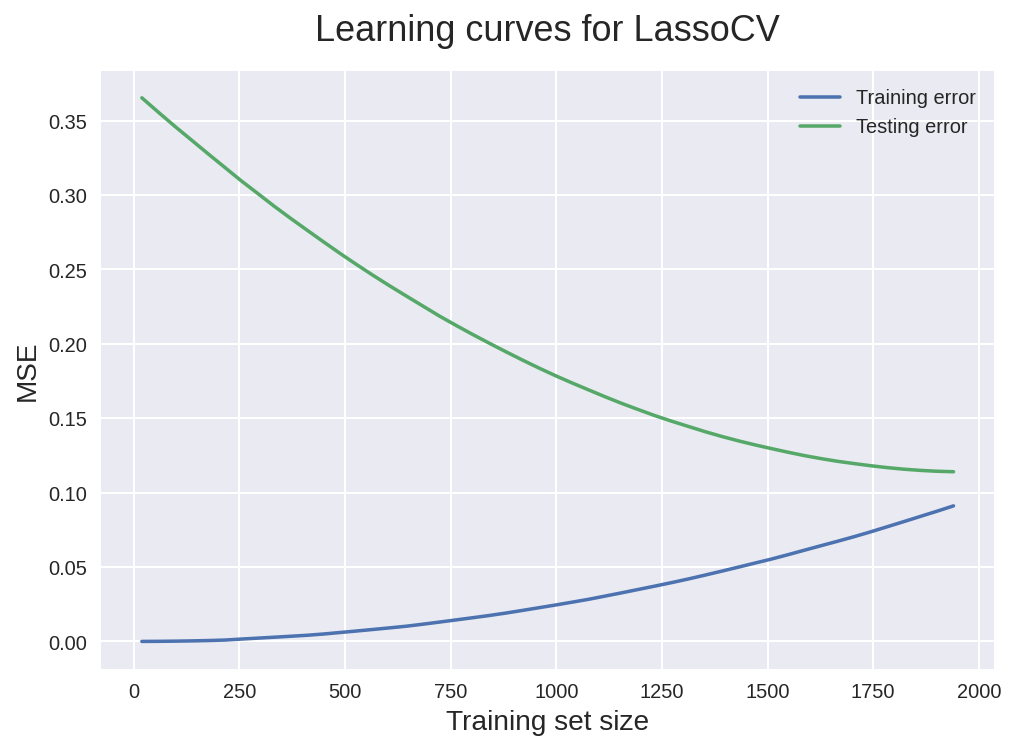

In [70]:
train_sizes = np.linspace(0.01, 1.0, 50)
train_sizes, train_scores, test_scores = learning_curve(LassoCV(), X_sel_f, y_sel_f, 
                                                        train_sizes = train_sizes, cv = 10, 
                                                        scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
test_scores_mean = -test_scores.mean(axis = 1)

#plot
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, test_scores_mean, label = 'Testing error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for LassoCV', fontsize = 18, y = 1.03)
plt.legend()

# 3. Build a NN model to predict RLU (0.35)

In [76]:
# load data
y = ch1_df['RUL']
X = ch1_df.drop(['RUL'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.to_numpy().reshape(X_train.shape[0], 7, 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 7, 1)
y_train = y_train.to_numpy().reshape(y_train.shape[0],1)
y_test = y_test.to_numpy().reshape(y_test.shape[0],1)

In [72]:
# train model
verbose, epochs, batch_size = 1, 10, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
adam = keras.optimizers.Adam(learning_rate=0.001)

model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softplus'))
model.compile(loss='mse', optimizer = adam, metrics=['mean_squared_error'])

# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)

Epoch 1/10
20/20 [==============================] - 0s 12ms/step - loss: 71.1002 - mean_squared_error: 71.1002 - val_loss: 56.0805 - val_mean_squared_error: 56.0805
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 16.6161 - mean_squared_error: 16.6161 - val_loss: 1.5986 - val_mean_squared_error: 1.5986
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 2.8925 - mean_squared_error: 2.8925 - val_loss: 11.4804 - val_mean_squared_error: 11.4804
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 1.5925 - mean_squared_error: 1.5925 - val_loss: 7.6267 - val_mean_squared_error: 7.6267
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 1.5270 - mean_squared_error: 1.5270 - val_loss: 7.9732 - val_mean_squared_error: 7.9732
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 1.2419 - mean_squared_error: 1.2419 - val_loss: 9.0870 - val_mean_squared_error: 9.0870
Epoch 7/10
20/20 [=============

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


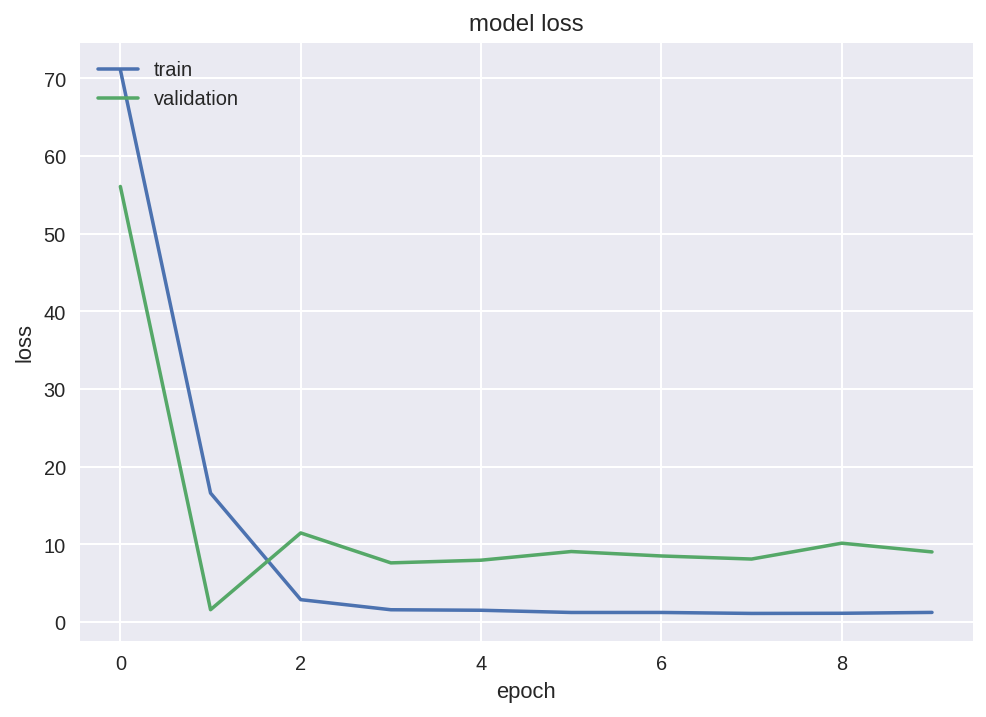

In [73]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [74]:
# evaluate model on the splitted test dataset drawn from 2nd_test dataset
_, mse = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print('Test MSE:', mse)

Test MSE: 8.988797187805176


#### Train and evaluate the model on test data from Test set 1

In [75]:
# load data
y_test1 = ch1_test1_df['RUL']
X_test1 = ch1_test1_df.drop(['RUL'], axis=1)
X_test1_train, X_test1_test, y_test1_train, y_test1_test = train_test_split(X_test1, y_test1, test_size=0.3, random_state=42)
X_test1_train = X_test1_train.to_numpy().reshape(X_test1_train.shape[0], 7, 1)
X_test1_test = X_test1_test.to_numpy().reshape(X_test1_test.shape[0], 7, 1)
y_test1_train = y_test1_train.to_numpy().reshape(y_test1_train.shape[0],1)
y_test1_test = y_test1_test.to_numpy().reshape(y_test1_test.shape[0],1)

In [76]:
# evaluate model on the 1st_test dataset
_, mse = model.evaluate(X_test1_test, y_test1_test, batch_size=batch_size, verbose=0)
print('Test MSE:', mse)

Test MSE: 12.477103233337402


#### How do you make sure not to overfit?

We can tune learing rate to avoid overfitting. Also, since we used channel 1 data for modeling only, the data is not enough; instead, we should use data from all channels. Even though the second point is theoretically possible, due to extracting data from all channels from test set 1 almost crippled our laptops, we did not fit the model onto the data.

#### Analyze the result

This model did not show the full advantages of a CNN model when comparing the MSE from LassoCV model and the 1D CNN model, mostly due to the fact that the data is biased (only from Channel 1). If there are more time, more extensive hyperparameter tuning should be done to boost model performance.

# 4. Concept drift detection (0.2)

In [ ]:
!pip install scikit-multiflow

In [64]:
# dataframe for plotting concept drift
cd_df = pd.DataFrame()
max_ch1 = np.array([])
max_ch2 = np.array([])
max_ch3 = np.array([])
max_ch4 = np.array([])
 
for filename in os.listdir('2nd_test'): # get a list of files in the directory
     with open(os.path.join('2nd_test', filename), 'r') as f: # open in readonly mode
        tsv_file = pd.read_csv(f,delimiter='\t',encoding='utf-8',header=None)
        ch1 = tsv_file.iloc[:, 0].to_numpy() # col = Channel 1
        ch2 = tsv_file.iloc[:, 1].to_numpy() # col = Channel 2
        ch3 = tsv_file.iloc[:, 2].to_numpy() # col = Channel 3
        ch4 = tsv_file.iloc[:, 3].to_numpy() # col = Channel 4
 
        max_ch1 = np.append(max_ch1,max(ch1))
        max_ch2 = np.append(max_ch2,max(ch2))
        max_ch3 = np.append(max_ch3,max(ch3))
        max_ch4 = np.append(max_ch4,max(ch4))

cd_df['Ch1'] = max_ch1
cd_df['Ch2'] = max_ch2 
cd_df['Ch3'] = max_ch3 
cd_df['Ch4'] = max_ch4

In [65]:
# Code from Tutorial 10
def detector(channel):
 
    %matplotlib inline
     # Import ADWIN
    from skmultiflow.drift_detection import ADWIN

    drift_stream = channel.to_numpy()

    plt.figure(figsize=(20, 10))
    plt.plot(drift_stream)
    plt.xlabel('Time')
    plt.ylabel('Ch1 Vibration Signal')

     # instantiate ADWIN object 
    adwin = ADWIN()

     # for each data point in stream 
    for i in range(drift_stream.size):
     # add a new point to adwin object
         adwin.add_element(drift_stream[i])

     # if adwin detects change, print at what point in the stream 
     # the change was detected
         if adwin.detected_change():
                print('Change detected at index {}'.format(i))
                # x coordinates for the lines
                xcoords = [i]
                # colors for the lines
                colors = ['r']
                for xc,c in zip(xcoords,colors):
                    plt.axvline(x=xc, label='x = {}'.format(xc), c=c)
                    plt.legend()

Change detected at index 735
Change detected at index 767
Change detected at index 831
Change detected at index 895
Change detected at index 959


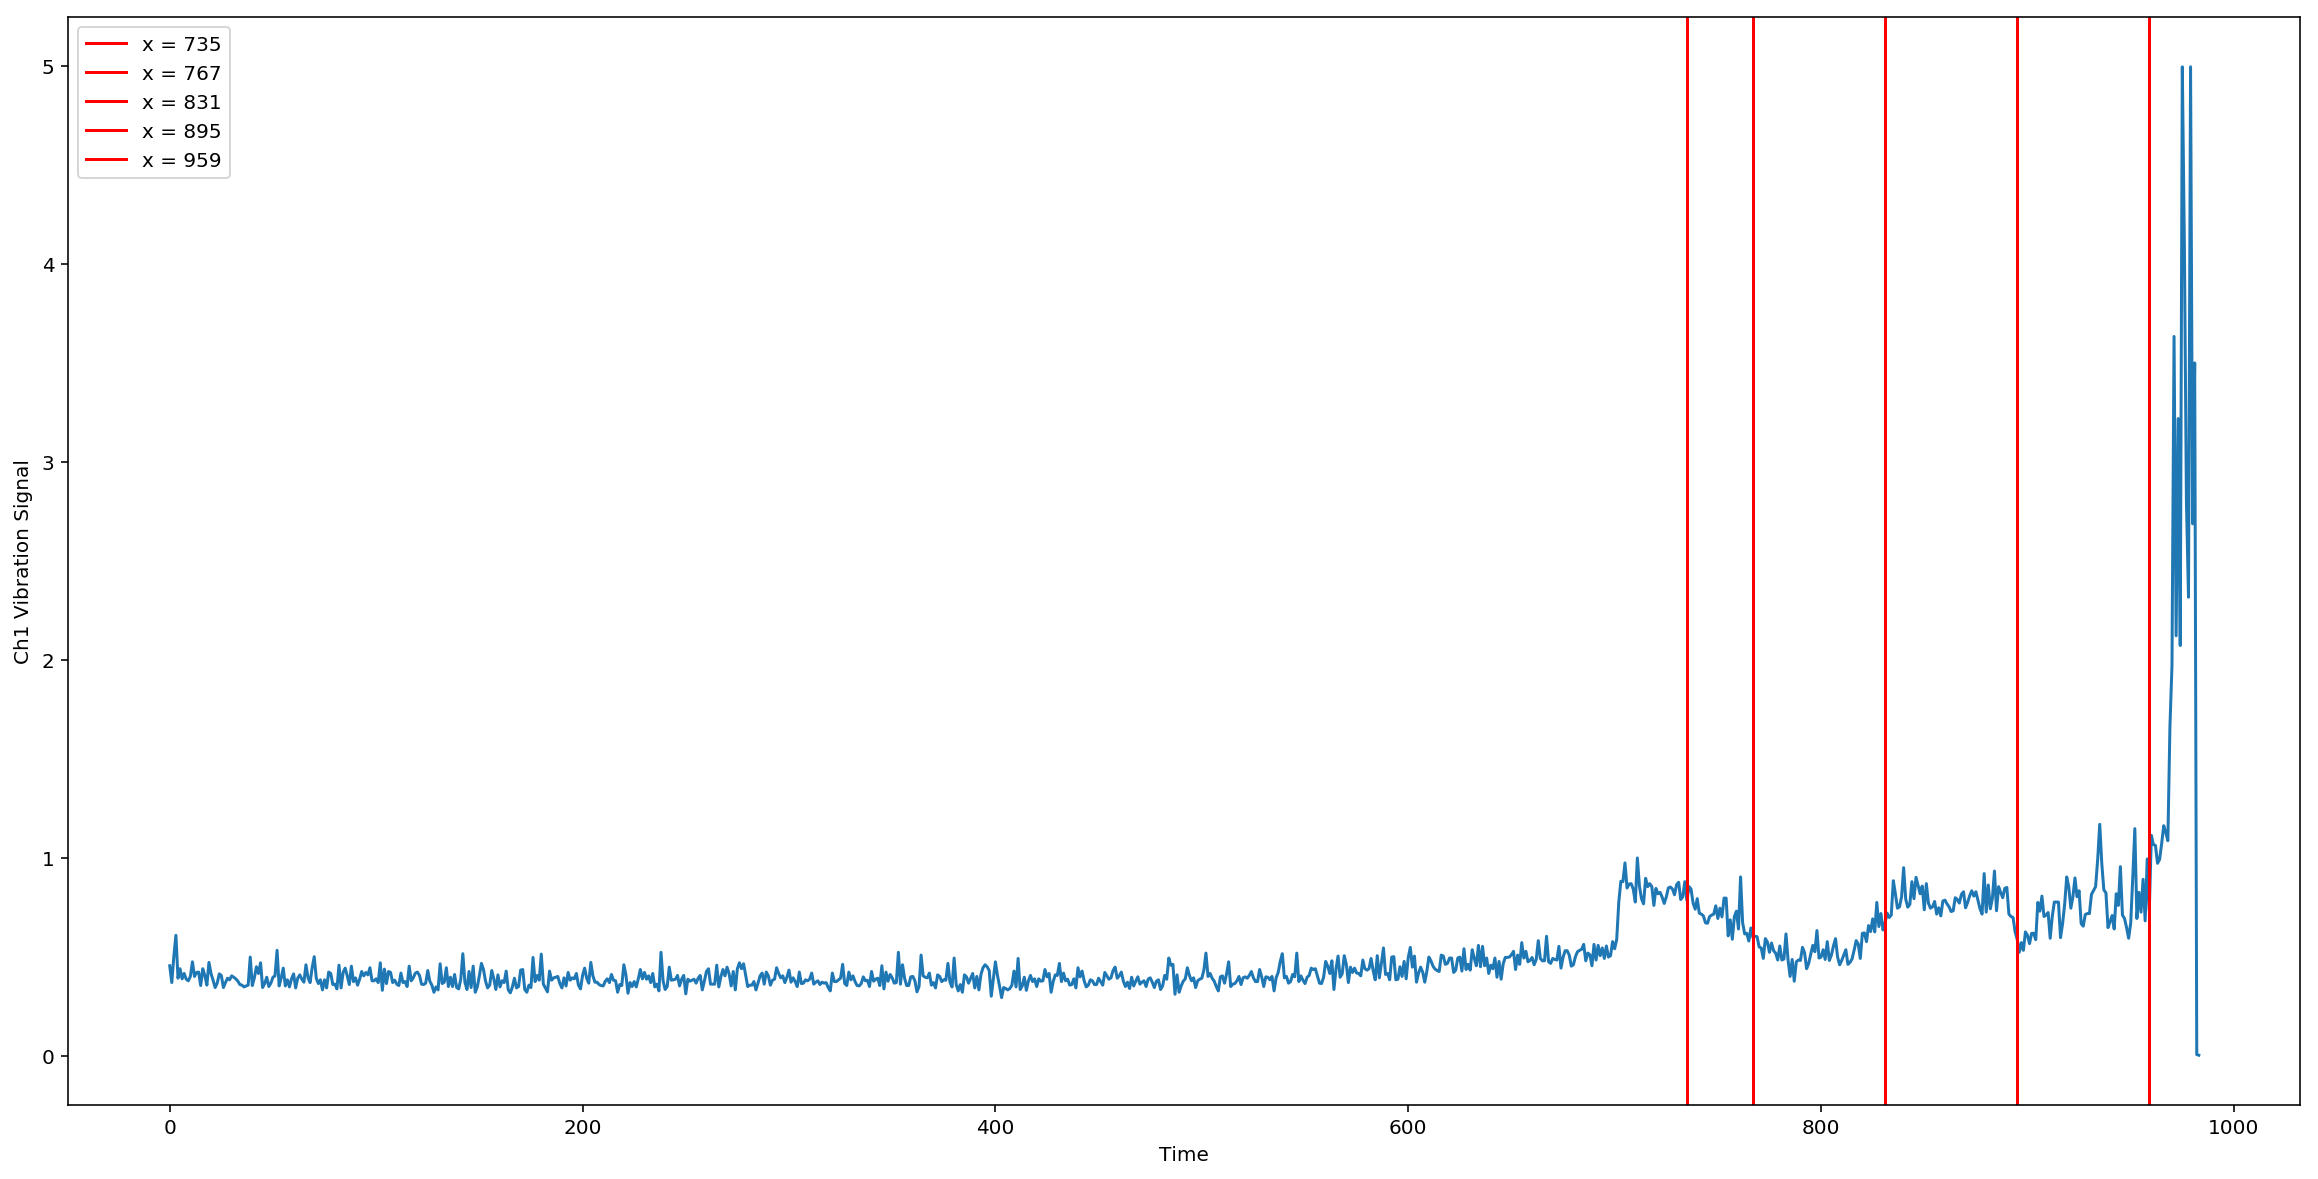

In [66]:
detector(channel = cd_df['Ch1'])

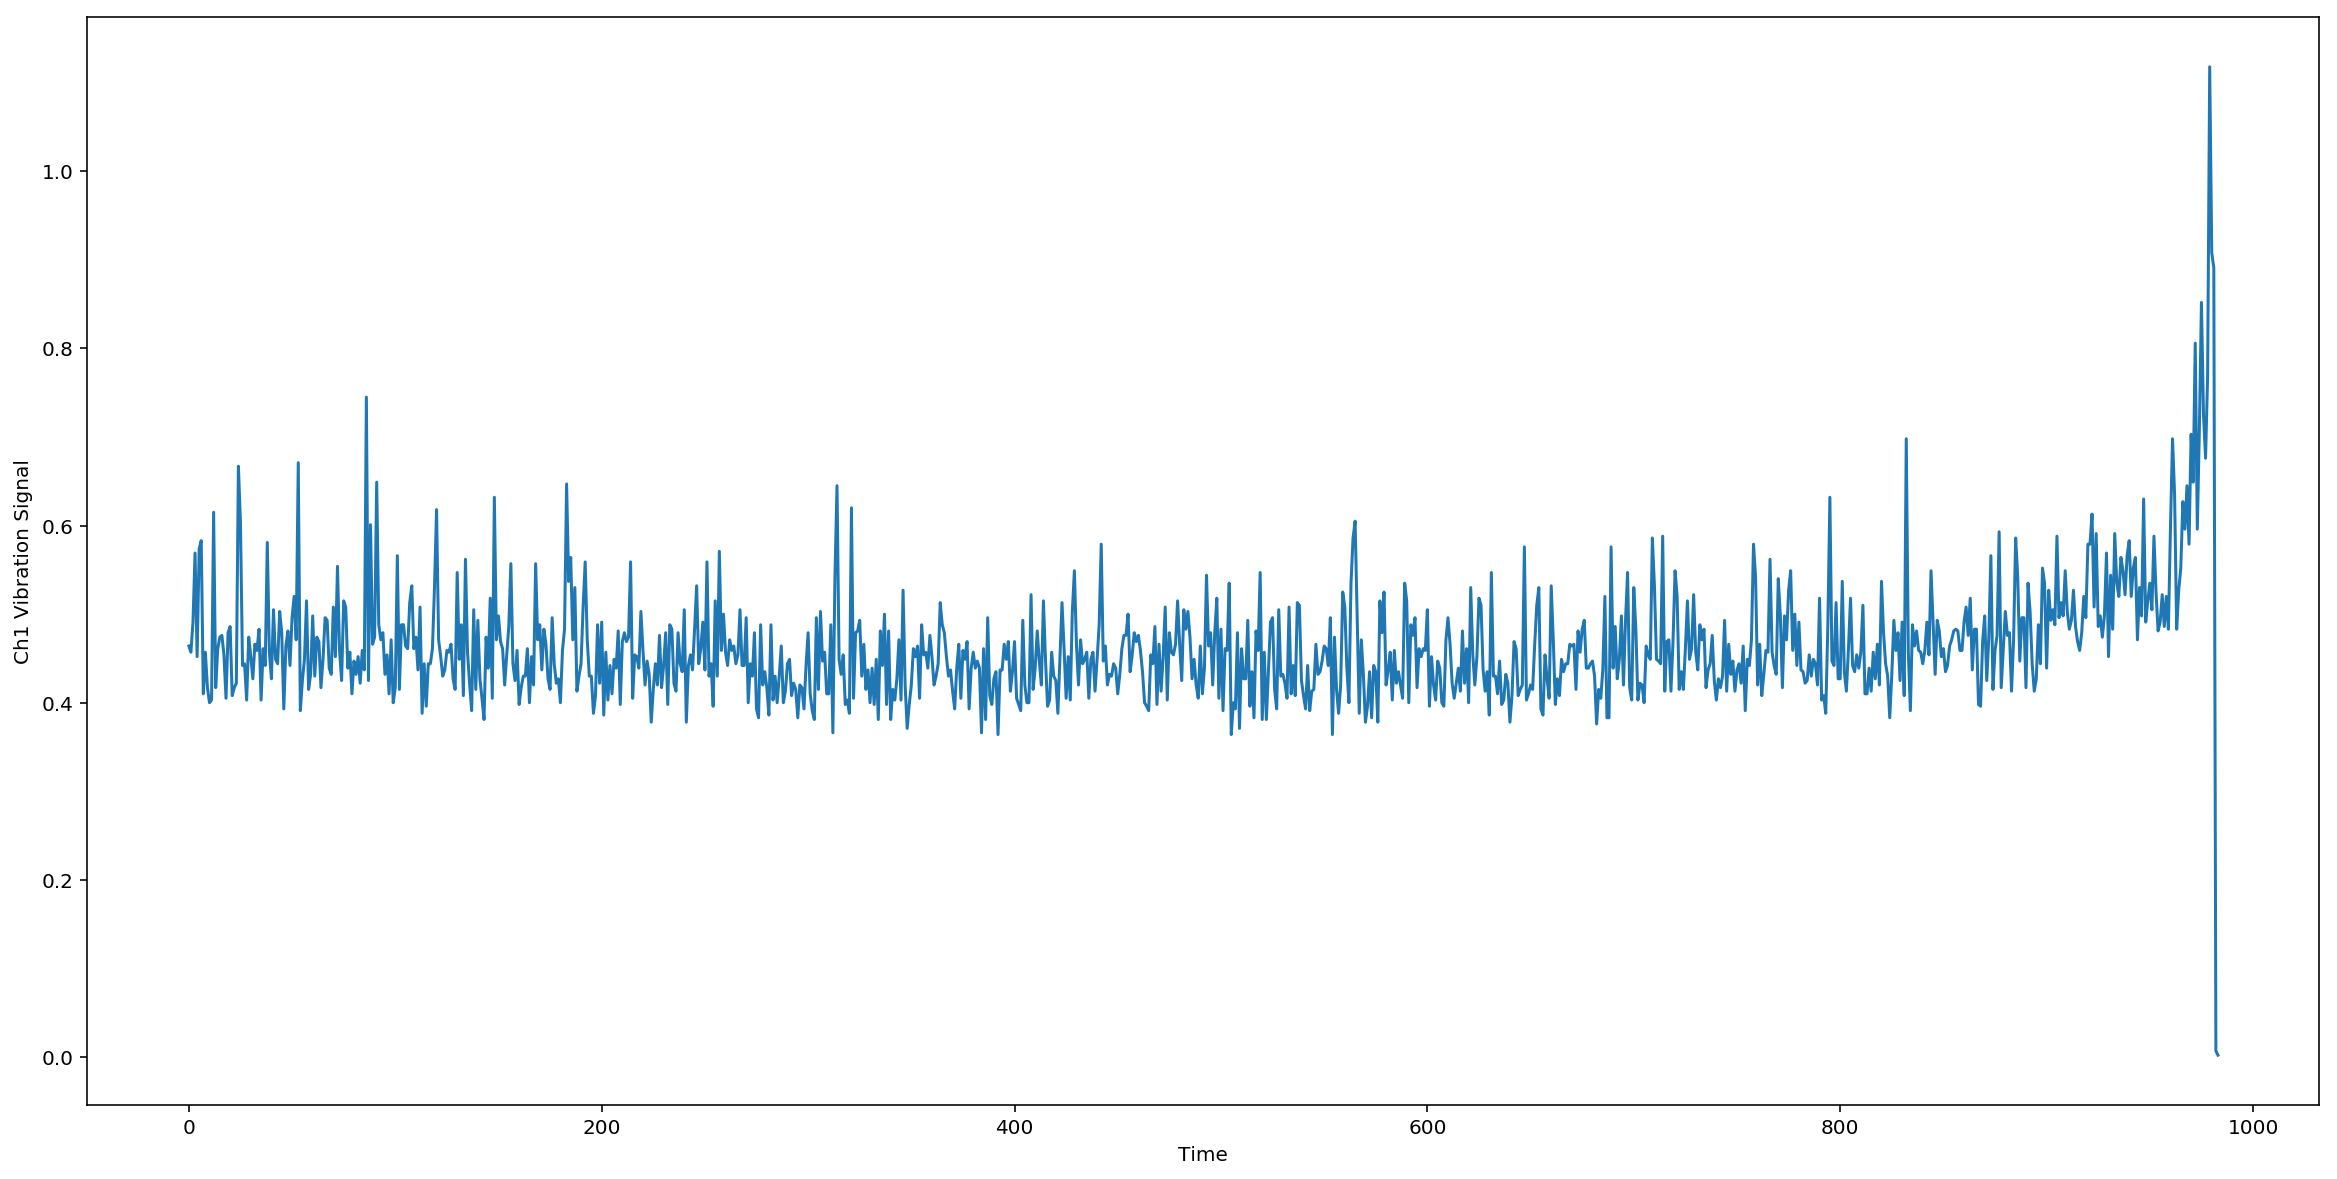

In [67]:
detector(channel = cd_df['Ch2'])

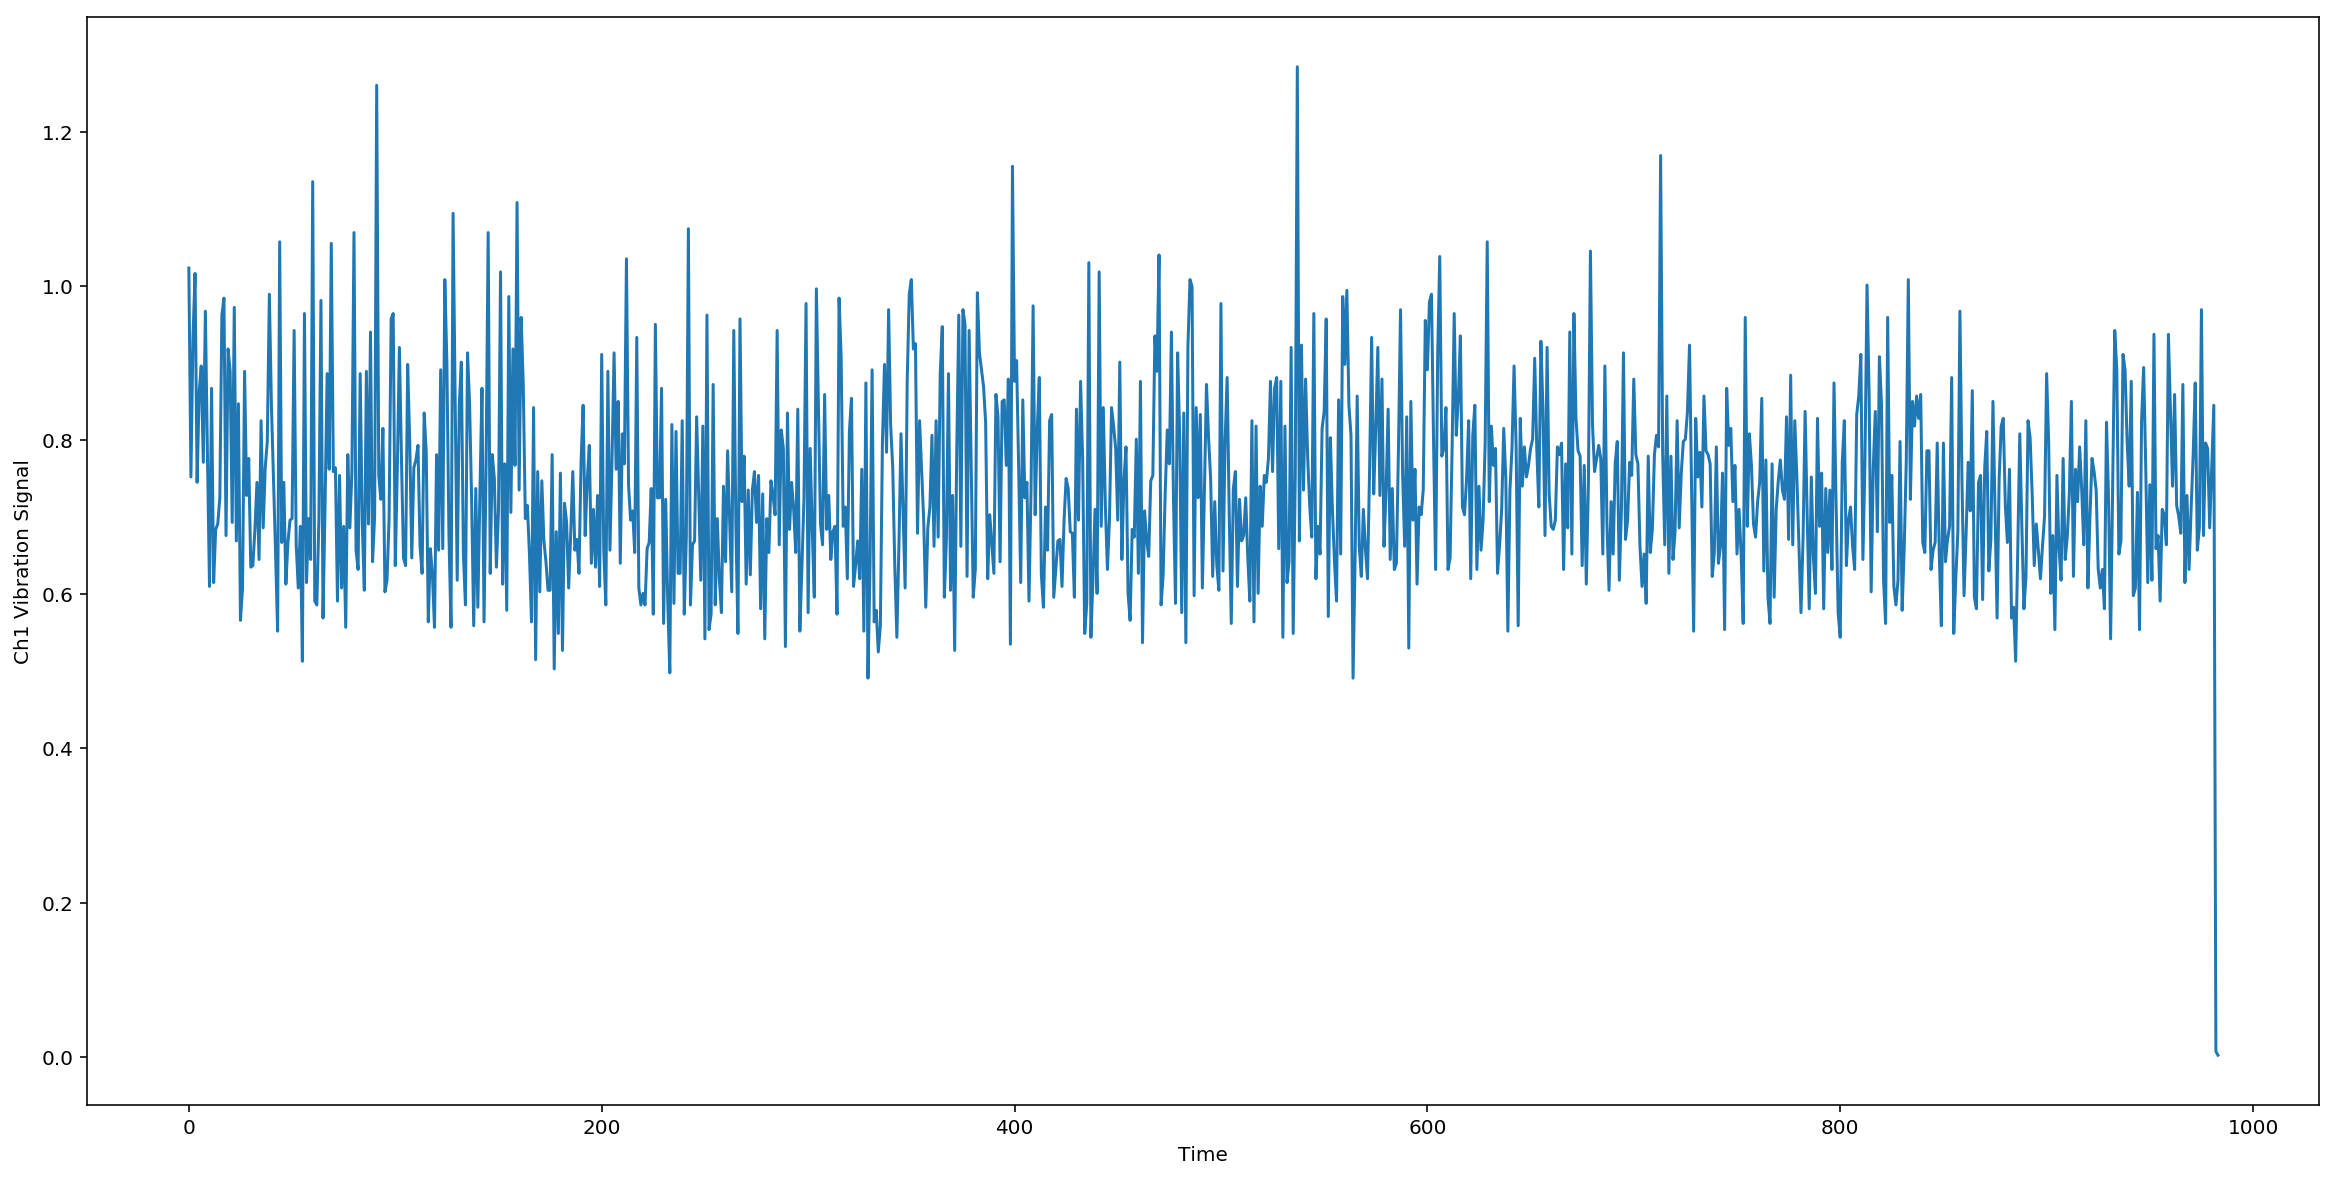

In [68]:
detector(channel = cd_df['Ch3'])

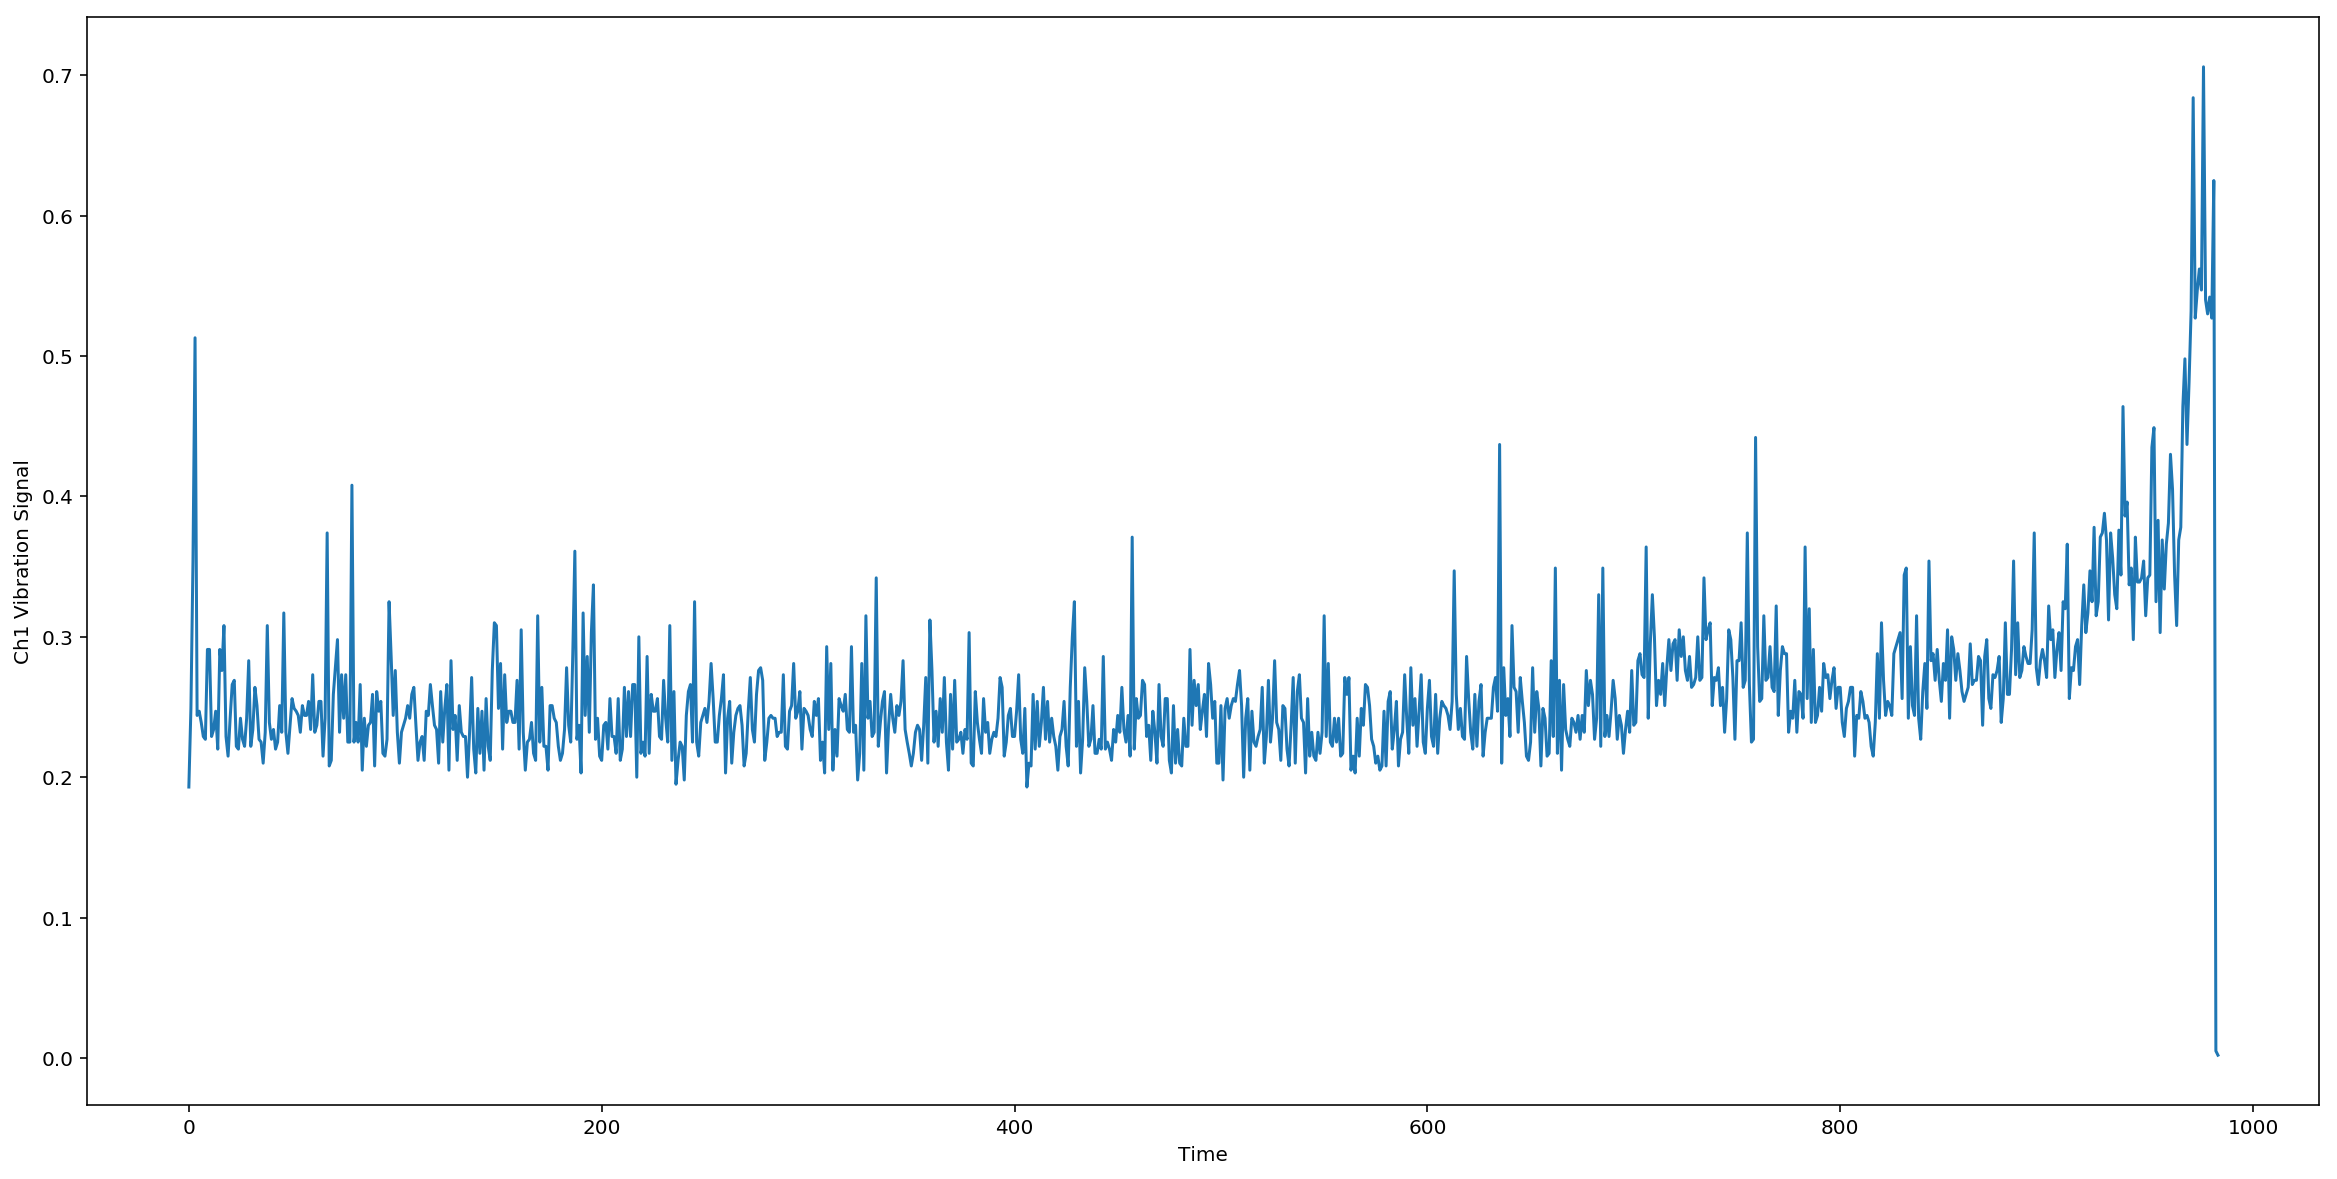

In [69]:
detector(channel = cd_df['Ch4'])

#### Use concept drift methods and find out if there is any drift in the data that can be detected. If so, what type of drift is that? Suggest specific actions to adapt your model to the new concept.

**Comment：** There were 5 concept drifts detected in Channel 1 (2nd Test), whereas the other channels did not show sign of concept drift. We believe the first drift is a sudden drift where the signal sectioned from healthy stage to unhealthy stage and as the bearing slowly degraded, some smaller sudden drifts and gradual drifts appears until the bearing completely failed.

Our model is trained on data from both healthy and unhealthy stage for the channel that is failing, therefore when test data (1st Tests) has a larger dataset for healthy stage, the trained model is not able to fit to that data.
We think that we should put a threshold to section the healthy & unhealthy stage base on the concept drift and then using only the unhealthy part of failed bearing and healthy stage of other bearing to train the data.